# Introduction
<a id="Introduction"></a>

This project is the ```Python``` equivalent of one of those life scenarios when you get out of your house, cross the street to buy groceries and, next thing you know, months have passed and you are now a goat herder in Nepal. It started originally as a simple, six-cell fit of a Linear Regression model. The problem was that the dataset I chose to do that fit on proved to be quirkier than I expected.

I generally dislike using fictional datasets. If there is no connection between the dataset and the real world, then data analysis or data science are to me as uncomplicated, linear, and ultimately irrelevant as playing a console game, only less fun. I also believe that the reality behind the numbers in a real-world dataset will, in some way, always make things difficult down the road, as opposed to a created dataset that either adheres to the rules we subject it to or is too random to regress.

With those thoughts in mind, I chose [this dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TPJYPC) from Harvard Dataverse, which was released for replication purposes of an at-the-time not yet released article by Gambacorta, L., Gambacorta, R. and R. Mihet [in this journal](https://sfs.org/review-of-corporate-finance-studies/).

What follows is a demonstration of the application of four different regression models on the data using ```Python```: a Simple Linear Regression model, an Elastic Net Regression model, a Random Forest model, and a Gradient Boosting Regression model. The four different methodologies for each model are described thoroughly, as well as the problems encountered. I first apply the models on the data without any significant transformation, and then reapply the same models on the same data but with certain variables log-transformed.

The focus is more on describing processes than on prediction accuracy. That is not to say that the results are mathematically incorrect. However, it will become clear during the examination of the dataset's variables that the original intention behind its creation was not model-fitting, especially not with the variables I chose to use.

Nevertheless, I consider it a good dataset for demonstrative purposes for many reasons: it is appropriately sized for both linear and non-linear algorithms, it has numerous issues that are not easily encountered in created datasets, the concepts behind the variables allow heavy manipulation, and finally, it *is* real-world data. As you will see, all of the above allowed me to perform a number of different experiments, which in turn forced me to deal with aspects of data analysis and machine learning that one would never encounter in a fictional dataset.

The models were not arbitrarily chosen either: I would say that the numbers (and logic) led me from one model to another. General Linear Models were included at some point, but after much consideration, I decided to cut everything down to two linear models with two different methodologies, and two non-linear algorithms. As far as the latter two are concerned, I am aware that the Random Forest algorithm may be a bit outdated when compared to models such as [Keras](https://www.tensorflow.org/tutorials) or [LightGBM](https://lightgbm.readthedocs.io/en/stable/), but I do consider it to be as pivotal as Simple Linear Regression, hence its inclusion and examination.

Keep in mind that I am not a statistician or a mathematician. What academic knowledge I have in statistics from my formal university education stops in Simple Linear Regression. I had to spend a significant amount of time in Stack Exchange, Cross Validated, Stack Overflow, and many other forums to solve the issues I encountered. I attempted to describe these difficulties as best I could, as well as the solutions I found for them. Links are provided when available.

Because the focus is on analytic description, several methods and objects that are focused on maximizing efficiency (such as ```scikit-learn``` pipelines) are avoided. It's also important to note that this is a demonstration of ```Python``` code, not a rigorous academic study. So adjust your expectations appropriately (and, of course, steal away chunks of code if you feel like it).

I understand that this is, perhaps, way too long for anyone to read in its entirety without serious incentive. So for anyone who reads it in its entirety, there will be cake in the end.

### Table of Contents:
- 1. [Imports and First Look of Dataset](#chapter_1)
- 2. [Helper Functions](#chapter_2)
- 3. [Variable Examination, Selection and Encoding](#chapter_3)
- 4. [Regression With Original Variables](#chapter_4)
    - 4.1. [Error Selection and Baseline: Dummy Regressor](#chapter_4.1)
    - 4.2. [Linear Regression](#chapter_4.2)
    - 4.3. [Dealing with (and Rejecting) Scaling and/or Centering Data](#chapter_4.3)
    - 4.4. [Non-Linear Regression](#chapter_4.4)
- 5. [Regression With Transformation of Variables](#chapter_5)
    - 5.1. [Choosing the Appropriate Transformation](#chapter_5.1)
    - 5.2. [Simple Linear Regression with Log-Transformed Variables](#chapter_5.2)
    - 5.3. [Elastic Net Regression with Log-Transformed Variables](#chapter_5.3)
    - 5.4. [Random Forest with Log-Transformed Variables](#chapter_5.4)
    - 5.5. [Gradient Boosting Regression with Log-Transformed Variables](#chapter_5.5)
- 6. [Final Evaluation of All Models, Prediction Intervals and Cake Maybe](#chapter_6)

# 1. Imports and First Look of Dataset
<a id="chapter_1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import patsy as pats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import lognorm, norm, kstest
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, OneHotEncoder,\
RobustScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedKFold 
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,\
max_error, mean_absolute_percentage_error, PredictionErrorDisplay
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score
sns.set_theme()

In [2]:
inv_type_data = pd.read_csv("fintech_data_rcfs.csv")

In [3]:
inv_type_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52129 entries, 0 to 52128
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RISFIN          52129 non-null  int64  
 1   ANNO            52129 non-null  int64  
 2   PESO            52129 non-null  float64
 3   AF2             52129 non-null  float64
 4   AF3             52129 non-null  float64
 5   AF1             52129 non-null  float64
 6   TIPOFAM         52129 non-null  int64  
 7   COLDIS          52129 non-null  int64  
 8   PAZQ            52129 non-null  int64  
 9   IREG            52129 non-null  int64  
 10  SESSO           52129 non-null  int64  
 11  ETA5            52129 non-null  int64  
 12  QUALP3          52129 non-null  int64  
 13  ACOM4C          52129 non-null  int64  
 14  CLYEQ2          52129 non-null  int64  
 15  STRAN           52129 non-null  int64  
 16  STUDIO5         52129 non-null  int64  
 17  FINTOTHAT       52129 non-null 

In [4]:
# Check for duplicated values
inv_type_data.duplicated().any()

False

As we can see above, we have a very 'clean' dataset: there are no NaN values, the data types are separated into int64 and float64, and there are no duplicates. Neat. 

# 2. Helper Functions 
<a id="chapter_2"></a>

Following is a list of all the helper functions I use in this project. I include the chapter they are used in, as well as a brief description.

### [Chapter 3](#chapter_3) functions:
<a id="chapter_3_functions"></a>

Function which plots the univariate distributions of all variables, *in lieu* of high level ```seaborn``` pairwise functions that provide a lot more information but are also much 'heavier':

In [5]:
# Plot univariate distributions of all variables
def plot_all_vars_distributions(dataframe):
    fig = plt.figure(figsize=(20, 70))
    
    for n, column in enumerate(dataframe.columns):
        ax = plt.subplot(len(dataframe.columns), 2, n+1)
        sns.kdeplot(dataframe, x=column)
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.5)

Correlation Matrix with Kendall Tau method for variables which do not have normal distributions:

In [6]:
# Kendall Tau Correlation Matrix for distributions other than normal
def kendall_corrmat(dataframe):
    
    fig = plt.figure(figsize=(20, 20))
    correlation = dataframe.corr(method="kendall")
    cormatrix = sns.heatmap(correlation, xticklabels=True, yticklabels=True, linewidth=.5, annot=True)
    
    return cormatrix

Variance inflation factor test:

In [7]:
# Check variance inflation of variables with our dependent variable
def check_vif(dataframe, dependent_var):
    Needed_DF = sm.add_constant(dataframe)
    Needed_DF.drop(dependent_var, axis=1, inplace=True)
    return pd.Series([variance_inflation_factor(Needed_DF.values, i) 
                      for i in range(Needed_DF.shape[1])], 
                      index=Needed_DF.columns)

Homoscedasticity test:

In [8]:
# Check homoscedasticity of variables with dependent variable
def homoscedasticity_test(dataframe, dependent):
    
    test =  pd.Series([bool(pg.homoscedasticity(dataframe, dependent, column)["equal_var"].values) 
                       for column in dataframe.columns], index=dataframe.columns)
    
    return  test

### [Chapter 4](#chapter_4) functions:
<a id="chapter_4_functions"></a>

Functions that are used repeatedly in chapter 4 to ease backward elimination of variables:

In [9]:
# Drop variable from both train and test datasets
def drop_variable(train, test, column):
    train.drop(column, axis=1, inplace=True)
    test.drop(column, axis=1, inplace=True)
    train.drop_duplicates(inplace=True)
    test.drop_duplicates(inplace=True)

In [10]:
# Linear regression using statsmodels with patsy formula
def linear_regression(data, dependent_var):
    all_columns = "+".join(data.drop(dependent_var, axis =1))
    formula = dependent_var + "~" + all_columns 
    model = smf.ols(formula=formula, data=data)
    results = model.fit()
    predictions = results.get_prediction().summary_frame()
    print(results.summary())

Weights out of a Simple Linear Regression model's residuals. The methodology can be found [here](https://www.einblick.ai/python-code-examples/weighted-least-squares-regression-statsmodels/), related discussions can be found [here](https://stats.stackexchange.com/questions/97832/how-do-you-find-weights-for-weighted-least-squares-regression) and [here](https://stackoverflow.com/questions/46861158/robust-linear-regression-results-in-python-and-stata-do-not-agree):

In [11]:
def calculate_ln_weights(data, dependent_var):
    # Fit simple linear regression model
    all_columns = "+".join(data.drop(dependent_var, axis =1))
    formula = dependent_var + "~" + all_columns 
    ols_model = smf.ols(formula=formula, data=data)
    ols_results = ols_model.fit(cov_type="HC1")
    
    # Absolute values of residuals
    y_resid = [abs(resid) for resid in ols_results.resid]
    
    # Add constant according to statsmodels documentation to the fitted values
    # of the OLS model
    x_resid = sm.add_constant(ols_results.fittedvalues)
    
    # Create OLS model, fit, and print results
    mod_resid = sm.OLS(y_resid, x_resid)
    res_resid = mod_resid.fit()
    
    # Estimate of std. dev.
    mod_fv = res_resid.fittedvalues
    
    # Calculate weights
    weights = 1 / (mod_fv**2)
    
    return weights

Weighted regression function for backward elimination:

In [12]:
def weighted_linear_regression(data, dependent_var):
    # Fit simple linear regression model
    all_columns = "+".join(data.drop(dependent_var, axis =1))
    formula = dependent_var + "~" + all_columns 
    ols_model = smf.ols(formula=formula, data=data)
    ols_results = ols_model.fit(cov_type="HC1")
    
    # Absolute values
    y_resid = [abs(resid) for resid in ols_results.resid]
    
    # Add constant according to statsmodels documentation to the fitted values
    # of the OLS model
    x_resid = sm.add_constant(ols_results.fittedvalues)
    
    # Create OLS model, fit, and print results
    mod_resid = sm.OLS(y_resid, x_resid)
    res_resid = mod_resid.fit()
    
    # Estimate of std. dev. (sigma)
    mod_fv = res_resid.fittedvalues
    
    # Calculate weights
    weights = 1 / (mod_fv**2)
    
    # Fit weighted linear regression model
    wls_model = smf.wls(formula=formula, data=data, weights=weights)
    wls_results = wls_model.fit()
    print(wls_results.summary())

Model scores for a variety of error metrics. A more comprehensive discussion about errors can be found [here](#chapter_4.2):

In [13]:
def model_score(unfit_model, xtrain, ytrain, ytest, ypred, round_int=3): 
    # Method inspired by https://github.com/INRIA/scikit-learn-mooc
    # Define scores of interest our of scikit learn metrics
    model_mean_r2_score = cross_val_score(unfit_model, xtrain, ytrain, cv=5).mean()
    model_r2_score_std = cross_val_score(unfit_model, xtrain, ytrain, cv=5).std()
    model_root_mean_squared_error = mean_squared_error(ytest, ypred, squared=False)
    model_mean_squared_error = mean_squared_error(ytest, ypred)
    model_mean_absolute_error = mean_absolute_error(ytest, ypred)
    model_max_error = max_error(ytest, ypred)
    
    # See scikit learn doc for definition of MAPE and why it can be 130%
    model_mean_absolute_percentage_error = mean_absolute_percentage_error(ytest, ypred)*100
    
    # Create dataframe with all variables
    score_df = pd.DataFrame([model_mean_absolute_error, model_max_error, 
                             model_mean_absolute_percentage_error,
                             model_mean_r2_score, model_r2_score_std,
                             model_root_mean_squared_error, 
                             model_mean_squared_error],
                            index=["Mean Absolute Error", 
                                   "Max Error",
                                   "MAPE",
                                   "Mean R2 Score after 5 CV",
                                   "R2 Score Standard Deviation",
                                   "Root Mean Squared Error",
                                   "Mean Squared Error"], columns=["Score Values"])
    return score_df.round(round_int)

Regression Error visualization function, showing both "Residual vs Predicted" and "Actual vs Predicted", as well as a QQ plot:

In [14]:
def visualize_results(y_true, y_pred, model_residuals):
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = plt.subplot(131)
    display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
    display.plot(ax=ax1)
    ax1.set(title="Residuals Plot: Residual vs Predicted")

    ax2 = plt.subplot(132)
    display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
    display.plot(ax=ax2, kind="actual_vs_predicted")
    ax2.set(title="Residuals Plot: Actual vs Predicted")

    ax3 = plt.subplot(133)
    sm.qqplot(model_residuals, fit=True, line="45", ax=ax3)
    ax3.set(title="Quantile-Quantile Plot");

Function for hyperparameters' tuning evaluation:

In [15]:
def show_param_cv_results(parameters, cv_object): 
    # Inspired by a similar function used in INRIA's modules: https://github.com/INRIA
    # Define columns
    columns = [f"param_{name}" for name in parameters.keys()]
    columns += ["R2 Score", "R2 Standard Deviation", 
                "Mean Absolute Error", "Absolute Error Standard Deviation"]
    
    # Turn cv_results into a dataframe
    cv_results = pd.DataFrame(cv_object.cv_results_)
    
    # Map columns with appropriate metric
    cv_results["R2 Score"] = cv_results["mean_test_r2"]
    cv_results["R2 Standard Deviation"] = cv_results["std_test_r2"]
    cv_results["Mean Absolute Error"] = -cv_results["mean_test_neg_mean_absolute_error"]
    cv_results["Absolute Error Standard Deviation"] =  cv_results["std_test_neg_mean_absolute_error"]
    
    return cv_results[columns].sort_values(by="Mean Absolute Error")    

### [Chapter 5](#chapter_5) functions:
<a id="chapter_5_functions"></a>

Two one-time-use functions to evaluate all possible transformations of our variables:

In [16]:
def compare_transformations(variable):
    
    # For naming in titles
    vars_names = variable.columns.tolist()
    
     # Square root transform
    test_1 = np.sqrt(variable)
    
    # Log transform (non 0)
    test_2 = np.log(variable)
    
    # box-cox transform (non 0) 
    pt = PowerTransformer(method="box-cox", standardize=True) 
    skl_boxcox = pt.fit_transform(variable)
    test_3 = pd.DataFrame(data=skl_boxcox, columns=variable.columns)
    
    # Yeo-Jonhson transform
    pt2 = PowerTransformer(method="yeo-johnson", standardize=True) 
    skl_yeojohnson = pt2.fit_transform(variable)
    test_4 = pd.DataFrame(data=skl_yeojohnson, columns=variable.columns)
    
    # QuantileTransformer
    qt = QuantileTransformer(output_distribution="normal") 
    skl_qtt = qt.fit_transform(variable)
    test_5 = pd.DataFrame(data=skl_qtt, columns=variable.columns)
    
    # Flatten values to 1D for plots
    x = variable.values.flatten()
    x1 = test_1.values.flatten()
    x2 = test_2.values.flatten()
    x3 = test_3.values.flatten()
    x4 = test_4.values.flatten()
    x5 = test_5.values.flatten()
    
    # Plot univariate distributions of Total Assets and Financial Returns for each transformation
    fig = plt.figure(figsize=(15, 15))
    
    ax1 = plt.subplot(321)
    sns.histplot(variable, x=x)
    sns.rugplot(variable, x=x)
    ax1.set_title("Normal Values", pad=15, fontsize="large")   
    
    ax2 = plt.subplot(322)
    sns.histplot(test_1, x=x1, kde=True)
    sns.rugplot(test_1, x=x1)
    ax2.set_title("Square Root Values", pad=15, fontsize="large")   
    
    
    ax3 = plt.subplot(323)
    
    sns.histplot(test_2, x=x2, kde=True)
    sns.rugplot(test_2, x=x2)
    ax3.set_title("Log-Transform", pad=15, fontsize="large")   
    
    ax4 = plt.subplot(324)
    
    sns.histplot(test_3, x=x3, kde=True)
    sns.rugplot(test_3, x=x3)
    ax4.set_title("Box-Cox Transform", pad=15, fontsize="large")
    
    ax5 = plt.subplot(325)
    
    sns.histplot(test_4, x=x4, kde=True)
    sns.rugplot(test_4, x=x4)
    ax5.set_title("Yeo-Johnson Transform", pad=15, fontsize="large")
    
    ax6 = plt.subplot(326)
    sns.histplot(test_5, x=x5, kde=True)
    sns.rugplot(test_5, x=x5)
    ax6.set_title("Quantile Transform", pad=15, fontsize="large")
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    
    
    plt.suptitle(f"Comparison of {vars_names[0]} Distributions", size="xx-large"); 

In [17]:
def compare_transformations_regressions(variable, x, y):
    
    # For naming in titles
    vars_names = variable.columns.tolist()
    
    # Square root transform
    test_1 = np.sqrt(variable)
    
    # Log transform (non 0)
    test_2 = np.log(variable)
    
    # box-cox transform (non 0) 
    pt = PowerTransformer(method="box-cox", standardize=True) 
    skl_boxcox = pt.fit_transform(variable)
    test_3 = pd.DataFrame(data=skl_boxcox, columns=variable.columns)
    
    # Yeo-Jonhson transform
    pt2 = PowerTransformer(method="yeo-johnson", standardize=True) 
    skl_yeojohnson = pt2.fit_transform(variable)
    test_4 = pd.DataFrame(data=skl_yeojohnson, columns=variable.columns)
    
    # Quantile Transform
    qt = QuantileTransformer(output_distribution="normal") 
    skl_qtt = qt.fit_transform(variable)
    test_5 = pd.DataFrame(data=skl_qtt, columns=variable.columns)   
    
    # Plot regression lines and residuals of Total Assets and Financial Returns for each transformation
    fig = plt.figure(figsize=(15, 15))
    
    ax1 = plt.subplot(321)
    sns.regplot(variable, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(variable, x=x, y=y)
    ax1.set_title("Normal Values", pad=15, fontsize="large")   
    
    ax2 = plt.subplot(322)
    sns.regplot(test_1, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(test_1, x=x, y=y)
    ax2.set_title("Square Root Values", pad=15, fontsize="large")   
    
    ax3 = plt.subplot(323)
    
    sns.regplot(test_2, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(test_2, x=x, y=y)
    ax3.set_title("Log-Transform", pad=15, fontsize="large")   
    
    ax4 = plt.subplot(324)
    
    sns.regplot(test_3, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(test_3, x=x, y=y)
    ax4.set_title("Box-Cox Transform with Standardization", pad=15, fontsize="large")   
    
    ax5 = plt.subplot(325)
    
    sns.regplot(test_4, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(test_4, x=x, y=y)
    ax5.set_title("Yeo-Jonhson Transform", pad=15, fontsize="large")   
    
    ax6 = plt.subplot(326)
    
    sns.regplot(test_5, x=x, y=y, line_kws={"color": "firebrick"})
    sns.residplot(test_5, x=x, y=y)
    ax6.set_title("Quantile Transform", pad=15, fontsize="large")   
    
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.9,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    
    
    plt.suptitle(f"Regression Lines Comparison of Normal/Transformed Values of\
    \n{vars_names[0]} and {vars_names[1]}", size="xx-large"); 

See the conversation about back-transforming log-transformed variables in [chapter 5](#chapter_5.2):

In [18]:
def duans_smearing_bias_correction(sigma_squared_hat):
    bias_correction = (np.exp(2 * sigma_squared_hat) - 1) / 2
    return bias_correction

# 3. Variable Examination, Selection and Encoding 
<a id="chapter_3"></a>

To ease the description and comprehension of the dataset, we are going to rename it based on the information contained in the [supporting document that the dataset's creators released](https://dataverse.harvard.edu/file.xhtml?fileId=7196857&version=1.0):

In [19]:
inv_type_data_dict = {"RISFIN": "Risk_Aversion",  # of Investor
                      "ANNO": "Year", 
                      "PESO": "Survey_Weights", 
                      "AF2": "Medium_Risk_Assets", #In the household portfolio
                      "AF3": "High_Risk_Assets", #In the household portfolio
                      "AF1": "Low_Risk_Assets", #In the household portfolio
                      "TIPOFAM": "Household_Type",
                      "COLDIS": "Remote_Bank_Connection", 
                      "PAZQ": "Household_Owns_Stocks", 
                      "IREG": "Region", 
                      "SESSO": "Sex", 
                      "ETA5": "Age_Class", 
                      "QUALP3": "Work_Status", 
                      "ACOM4C": "Municipality_Size", 
                      "CLYEQ2": "Equivalised_Income_Quintile",  # of Investor
                      "STRAN": "Born_Abroad", # Investor
                      "STUDIO5": "Unknown_Variable", 
                      "FINTOTHAT": "Index_of_Financial_Literacy",  # of Investor
                      "YCF_L": "Financial_Returns", # In the household portfolio
                      "AF_L": "Total_Assets", # In the household portfolio
                      "ROR": "Rate_of_Return", # of financial assets in the household portfolio
                      "QHRISK": "Risky_Assets_Share", # of financial assets in the household portfolio
                      "CLFL2": "Financial_Literacy_Quartile", # of Investor
                      "HHFINTOT": "Sophisticated_Investor",  # of Investor
                      "LLFINTOT": "Unsophisticated_Investor",  # of Investor
                      "HDIGF": "Bank_Digi_Services", # of Bank (randomized)
                      "DIGFHAT": "Bank_Digi_Services_Level_Index", #of Bank (randomized)
                      "DIGFHATREG": "Bank_Digi_Services_Reg_Average", # of Bank (randomized)
                      "UNSHDIGF": "unsophisticated*fintech llfintot*hdigf",
                      "UNSREGDIGFHAT": "unsophisticated*regionfintech llfintot*digfhatreg", 
                      "SOPHHDIGF": "sophitsticated*fintech",
                      "UNSREGDIGFHAT2": "unsophisticated*regionfintech^2"}

In [20]:
# Rename according to dictionary
inv_type_data.rename(columns=inv_type_data_dict, inplace=True)

In [21]:
inv_type_data.describe()

Risk_Aversion          Year  Survey_Weights  Medium_Risk_Assets  \
count   52129.000000  52129.000000    52129.000000        5.212900e+04   
mean        3.434940   2011.502235        0.998651        4.213245e+03   
std         0.736314      4.772101        1.050789        5.982641e+04   
min         1.000000   2004.000000        0.000119        0.000000e+00   
25%         3.000000   2008.000000        0.341081        0.000000e+00   
50%         4.000000   2012.000000        0.627074        0.000000e+00   
75%         4.000000   2014.000000        1.262917        0.000000e+00   
max         4.000000   2020.000000       16.083864        1.022645e+07   

       High_Risk_Assets  Low_Risk_Assets  Household_Type  \
count      5.212900e+04     5.212900e+04    52129.000000   
mean       2.347880e+04     2.078583e+04        3.216252   
std        4.506352e+05     1.617691e+05        1.295187   
min        0.000000e+00     0.000000e+00        1.000000   
25%        0.000000e+00     2.000000e+03        2.000000   
50%        0.000000e+00     6.012746e+03        3.000000   
75%        0.000000e+00     1.525908e+04        4.000000   
max        7.198886e+07     1.822862e+07        6.000000   

       Remote_Bank_Connection  Household_Owns_Stocks        Region  ...  \
count            52129.000000           52129.000000  52129.000000  ...   
mean                 0.223235               0.060926      9.559075  ...   
std                  0.416418               0.239196      5.826509  ...   
min                  0.000000               0.000000      1.000000  ...   
25%                  0.000000               0.000000      5.000000  ...   
50%                  0.000000               0.000000      9.000000  ...   
75%                  0.000000               0.000000     15.000000  ...   
max                  1.000000               1.000000     20.000000  ...   

       Financial_Literacy_Quartile  Sophisticated_Investor  \
count                 52129.000000            52129.000000   
mean                      2.355790                0.302135   
std                       1.046111                0.459188   
min                       1.000000                0.000000   
25%                       1.000000                0.000000   
50%                       2.000000                0.000000   
75%                       3.000000                1.000000   
max                       4.000000                1.000000   

       Unsophisticated_Investor  Bank_Digi_Services  \
count              52129.000000        52129.000000   
mean                   0.264824            0.502531   
std                    0.441244            0.289748   
min                    0.000000            0.000012   
25%                    0.000000            0.250632   
50%                    0.000000            0.503513   
75%                    1.000000            0.753506   
max                    1.000000            0.999995   

       Bank_Digi_Services_Level_Index  Bank_Digi_Services_Reg_Average  \
count                    52129.000000                    52129.000000   
mean                         0.501415                        0.498624   
std                          0.289268                        0.022327   
min                          0.000015                        0.344810   
25%                          0.248134                        0.482700   
50%                          0.502359                        0.498840   
75%                          0.752258                        0.511503   
max                          1.000000                        0.595689   

       unsophisticated*fintech llfintot*hdigf  \
count                            52129.000000   
mean                                 0.132620   
std                                  0.266399   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.056663   
max               

In [22]:
inv_type_data.head()

Risk_Aversion  Year  Survey_Weights  Medium_Risk_Assets  High_Risk_Assets  \
0              4  2004        1.458515                 0.0           0.00000   
1              2  2004        0.933546                 0.0        9106.90566   
2              2  2004        0.409546             60000.0       40000.00000   
3              4  2004        1.286450                 0.0           0.00000   
4              4  2004        1.281139                 0.0           0.00000   

   Low_Risk_Assets  Household_Type  Remote_Bank_Connection  \
0      1915.245951               4                       0   
1      3000.000000               4                       0   
2     50000.000000               3                       0   
3      3107.004663               4                       0   
4      1196.888574               4                       0   

   Household_Owns_Stocks  Region  ...  Financial_Literacy_Quartile  \
0                      0       1  ...                            4   
1                      1       1  ...                            3   
2                      0       1  ...                            4   
3                      0       1  ...                            4   
4                      0       1  ...                            3   

   Sophisticated_Investor  Unsophisticated_Investor  Bank_Digi_Services  \
0                       1                         0            0.362924   
1                       0                         0            0.831059   
2                       1                         0            0.183824   
3                       1                         0            0.077893   
4                       0                         0            0.707254   

   Bank_Digi_Services_Level_Index  Bank_Digi_Services_Reg_Average  \
0                        0.745195                        0.512285   
1                        0.276277                        0.512285   
2                        0.728883                        0.512285   
3                        0.734318                        0.512285   
4                        0.764080                        0.512285   

   unsophisticated*fintech llfintot*hdigf  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   unsophisticated*regionfintech llfintot*digfhatreg  sophitsticated*fintech  \
0                                                0.0                0.362924   
1                                                0.0                0.000000   
2                                                0.0                0.183824   
3                                                0.0                0.077893   
4                                                0.0                0.000000   

   unsophisticated*regionfintech^2  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  

[5 rows x 32 columns]

In [23]:
inv_type_data.columns

Index(['Risk_Aversion', 'Year', 'Survey_Weights', 'Medium_Risk_Assets',
       'High_Risk_Assets', 'Low_Risk_Assets', 'Household_Type',
       'Remote_Bank_Connection', 'Household_Owns_Stocks', 'Region', 'Sex',
       'Age_Class', 'Work_Status', 'Municipality_Size',
       'Equivalised_Income_Quintile', 'Born_Abroad', 'Unknown_Variable',
       'Index_of_Financial_Literacy', 'Financial_Returns', 'Total_Assets',
       'Rate_of_Return', 'Risky_Assets_Share', 'Financial_Literacy_Quartile',
       'Sophisticated_Investor', 'Unsophisticated_Investor',
       'Bank_Digi_Services', 'Bank_Digi_Services_Level_Index',
       'Bank_Digi_Services_Reg_Average',
       'unsophisticated*fintech llfintot*hdigf',
       'unsophisticated*regionfintech llfintot*digfhatreg',
       'sophitsticated*fintech', 'unsophisticated*regionfintech^2'],
      dtype='object')

The variable we are interested in is "Financial_Returns". We are therefore looking to analyze the rest of the variables' effects on it, define their relationship mathematically, and perform predictions based on that relationship. 

Right off the bat, we can observe the first potential issues with the dataset. To begin with, there is no information on the variable "STUDIO5", most probably an omission from the creators of the dataset. I assume it represents investor education, but I am not certain.

We have the wrong type of encoding for numerous categorical variables such as "Risk_Aversion, "Gender", "Age_Class" and "Work_Status". To be able to use these variables properly we have to ```onehotencode``` them 
and leave one category out (you can find more on this on ```onehotencoder```'s [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)). 

It is unclear what unit the continuous variables are measured in, i.e. the variables "Low-Medium-High_Risk_Assets", "Total_Assets" and "Financial_Returns". It would seem logical to assume that the unit of measurement is the Euro, but they each have 6 decimals instead of the normal 3. We could assume scientific notation is at play but that is not certain. Either way, for the purposes of this project, we are going to assume that the measurement unit is the Euro. 

All interaction terms use the randomized values from the variables created from banks' data and are therefore by definition unrelated to the rest of the dataset. On top of that, there are a number of variables that seem to be useful for categorization purposes only, such as "Year", "Household-Type", "Region" and "Municipality_Size". None of them will be used in this project, as we will consider all data as equal observations in the past 20 years (inflation adjustments are purposely ignored here for the sake of simplification).

Finally, several variables seem to be descriptions of how risky the portfolios are, which obviously makes us suspicious about multicollinearity between our independent variables. The following cells clarify that.

**You can find all the custom functions used in this chapter in [Chapter 3 Functions](#chapter_3_functions).**

<AxesSubplot: >

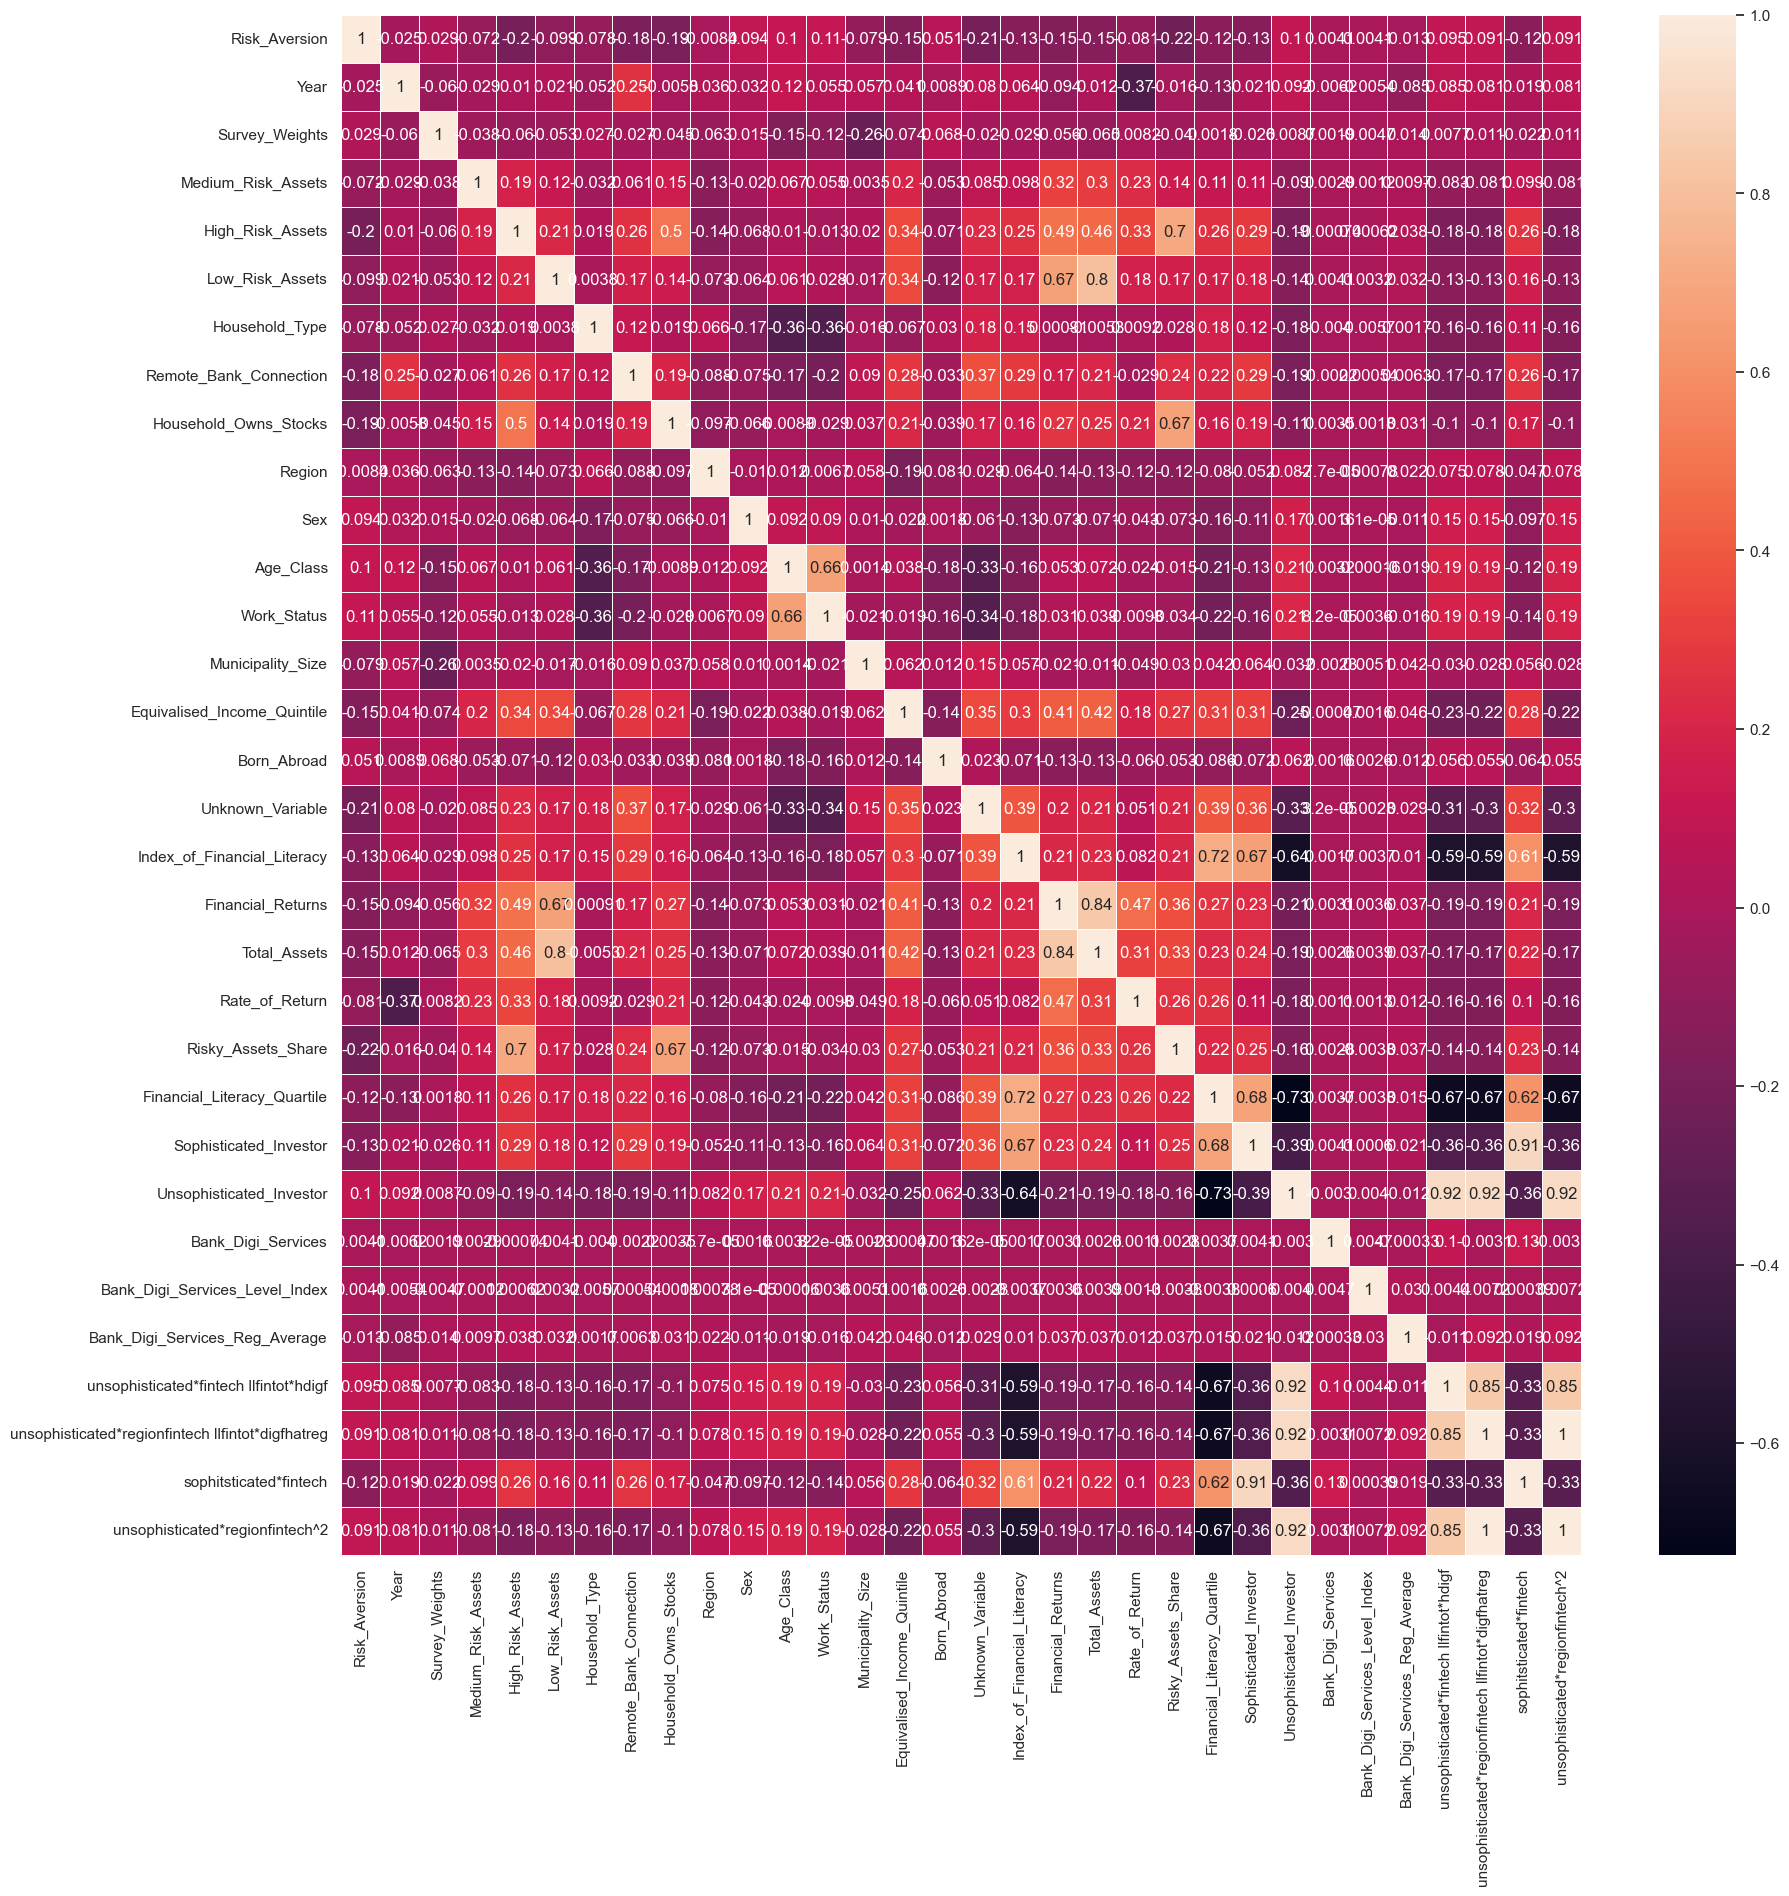

In [24]:
kendall_corrmat(inv_type_data)

We can see scattered pockets of high correlation. Obviously, all interaction terms are correlated, as one would expect, but we also have a strong correlation between "Risky_Assets_Share" and "High_Risk_Assets", as well as between "High_Risk_Assets" and "Total_Assets". We also observe a correlation between variables describing investor sophistication, such as "Index_of_Financial_Literacy", "Financial_Literacy_Quartile" and "Sophisticated investor". We will look at all that a bit later. Next, we will take a look at the distributions of our variables: 

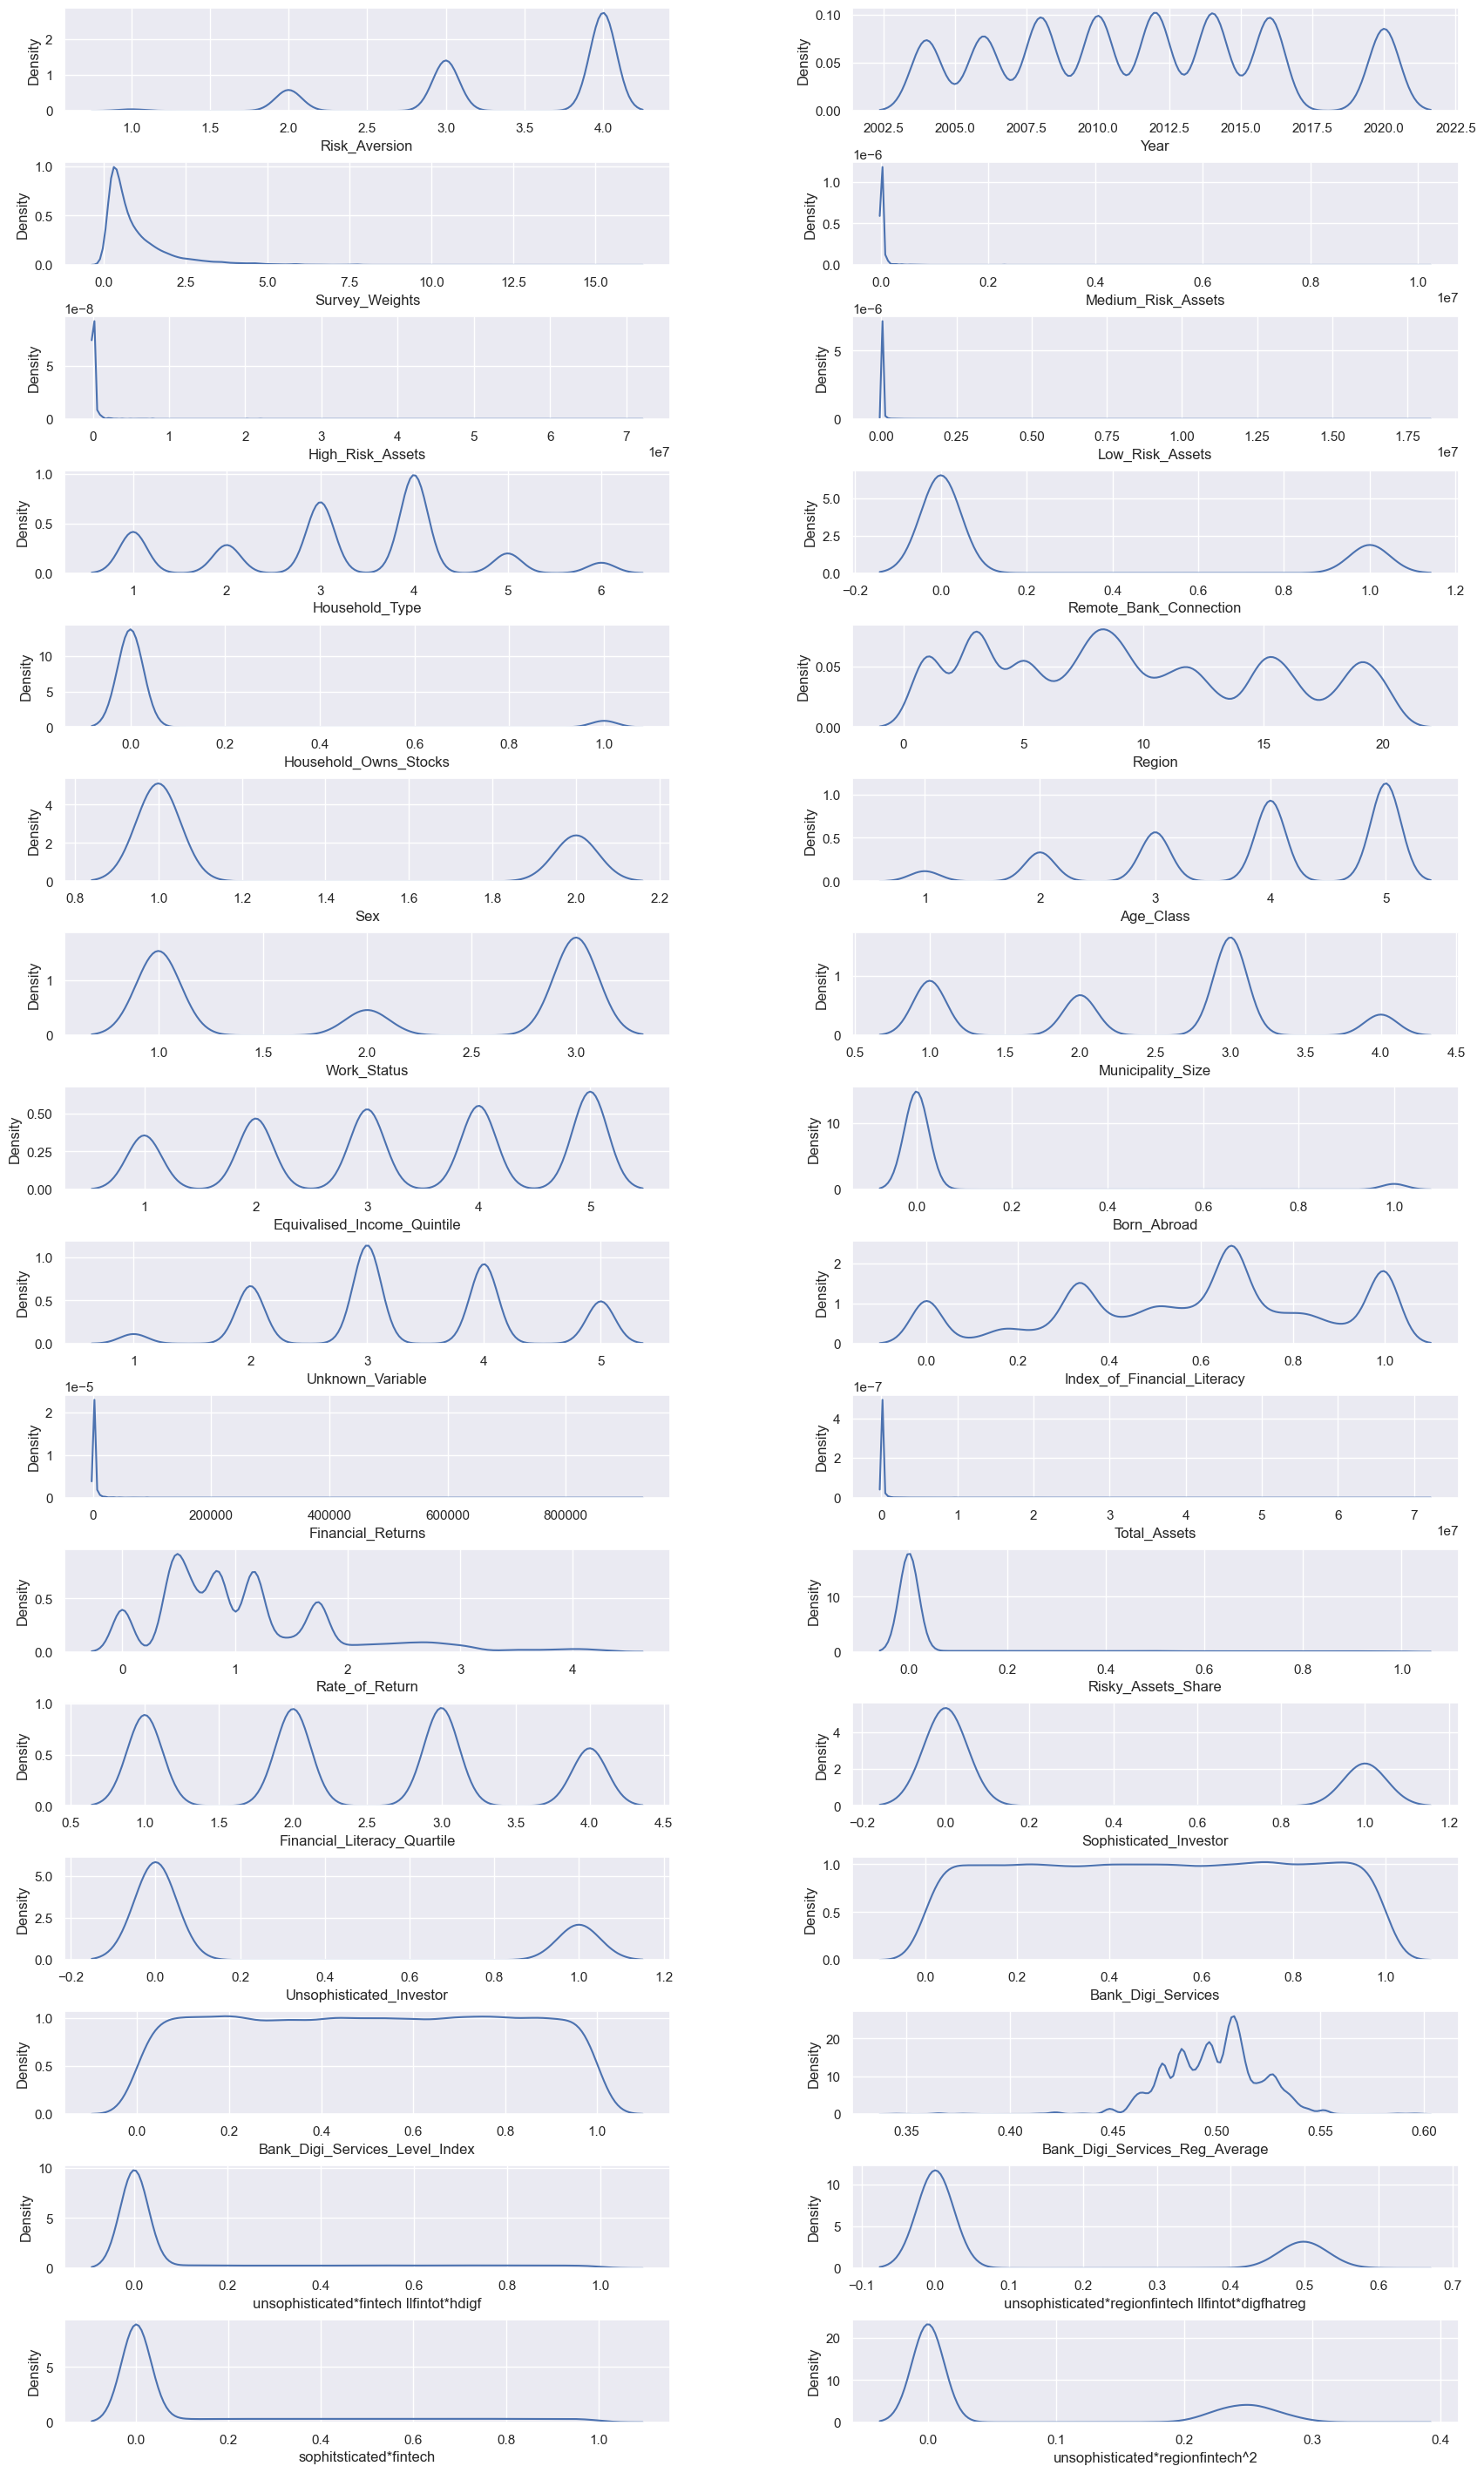

In [25]:
plot_all_vars_distributions(inv_type_data)

In [26]:
# Anderson-Darling test of whether dependent variable has normal distribution
pg.anderson(inv_type_data["Financial_Returns"], dist="norm")

(False, 1.0)

In [27]:
# Anderson-Darling test of whether dependent variable has exponential distribution
pg.anderson(inv_type_data["Financial_Returns"], dist="expon")

(False, 15.0)

Quite evidently, but also supported by the relevant test functions' results, our dependent variable is extremely right-skewed. It also appears are all "Assets" variables have the exact same right skewed distribution. There's a lot I would say about this if I were to look at this distribution as a social scientist, but I will not get into this fight right now. 

For the purposes of this project, we can simply acknowledge that the dependent variable does not follow a normal distribution (from the looks of it, it could be Poisson or Gamma, possibly zero-inflated). The rest of the variables either have a bimodal or multimodal distribution, as is the case of categorical variables, or uniform distributions, as is the case of variables that have randomized values.

Thankfully, the distribution of the dependent variable itself does not necessarily affect the accuracy of least squares. What could be a potential problem is if the error term is not normally distributed. We also have a natural lower bound in 0 (which had me initially thinking of using a GLM instead), but we will deal with that later. Up next, a Principal Component Analysis is performed: 

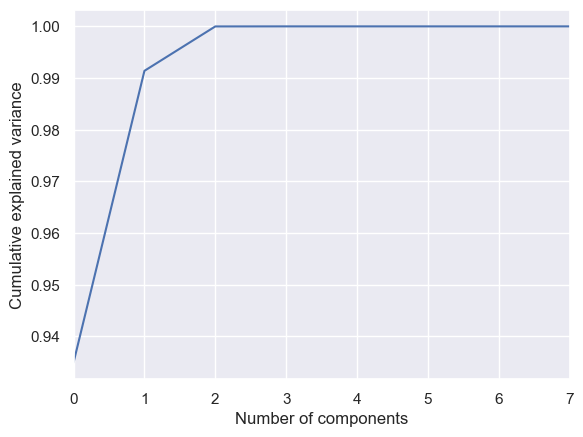

In [28]:
# Principal Component Analysis, code copied from Jake VanderPlas 
# https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

pca = PCA().fit(inv_type_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 7)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance");

It appears that the entirety of the variance of all our variables can be explained by as few as only two features (independent variables). Nevertheless, we will not be performing any kind of automated dimensionality reduction, since I would like to follow a more traditional, observational approach in examining the variables, especially for Linear Regression models.

Now that we have a clearer picture of the data, I am going to be performing some heavy data manipulation. The idea the to bring the dataset to an as simple as possible form while maintaining the original essence of the variables. First up, we drop the random variables, as well as the grouping variables and the survey weights (we will be using our own for weighted regression tasks):

In [29]:
# Create copy 
inv_type_data_1rst_ver = inv_type_data.copy()

# Drop variables
inv_type_data_1rst_ver.drop(["Year", "Survey_Weights", "Household_Type", "Region", "Municipality_Size",
                             "unsophisticated*fintech llfintot*hdigf",
                             "unsophisticated*regionfintech llfintot*digfhatreg",
                             "sophitsticated*fintech", "unsophisticated*regionfintech^2"], axis=1, inplace=True)

# Define interaction terms, though randomized and useless
interaction_terms = inv_type_data.loc[:, ["unsophisticated*fintech llfintot*hdigf",
                                          "unsophisticated*regionfintech llfintot*digfhatreg",
                                          "sophitsticated*fintech", "unsophisticated*regionfintech^2"]].copy()

In [30]:
# Check for duplicates
inv_type_data_1rst_ver.duplicated().any()

False

In [31]:
inv_type_data_1rst_ver.columns

Index(['Risk_Aversion', 'Medium_Risk_Assets', 'High_Risk_Assets',
       'Low_Risk_Assets', 'Remote_Bank_Connection', 'Household_Owns_Stocks',
       'Sex', 'Age_Class', 'Work_Status', 'Equivalised_Income_Quintile',
       'Born_Abroad', 'Unknown_Variable', 'Index_of_Financial_Literacy',
       'Financial_Returns', 'Total_Assets', 'Rate_of_Return',
       'Risky_Assets_Share', 'Financial_Literacy_Quartile',
       'Sophisticated_Investor', 'Unsophisticated_Investor',
       'Bank_Digi_Services', 'Bank_Digi_Services_Level_Index',
       'Bank_Digi_Services_Reg_Average'],
      dtype='object')

Next, we will keep only some of the variables that describe specific aspects of the data while dropping others with similar observations. We will drop "Rate_of_Return" since we will not be using rates and that relationship can be described by "Total_Assets" and "Financial_Returns". 

We will also drop the unknown variable, as well as any variables dealing with sophistication, keeping only the "Financial_Literacy_Quartile" as an indicator of financial understanding and sophistication. Finally, we will drop all the randomized variables, which are unrelated to the rest of the dataset:

In [32]:
# Create copy
inv_type_data_2nd_ver = inv_type_data_1rst_ver.copy()

# Drop variables
inv_type_data_2nd_ver.drop(["Rate_of_Return", "Unknown_Variable", "Sophisticated_Investor", 
                            "Unsophisticated_Investor", "Index_of_Financial_Literacy",
                            "Bank_Digi_Services", "Bank_Digi_Services_Level_Index",
                            "Bank_Digi_Services_Reg_Average"], axis=1, inplace=True)

In [33]:
# Check for duplicates
inv_type_data_2nd_ver.duplicated().any()

True

In [34]:
# Drop duplicates
inv_type_data_2nd_ver.drop_duplicates(inplace=True)

<AxesSubplot: >

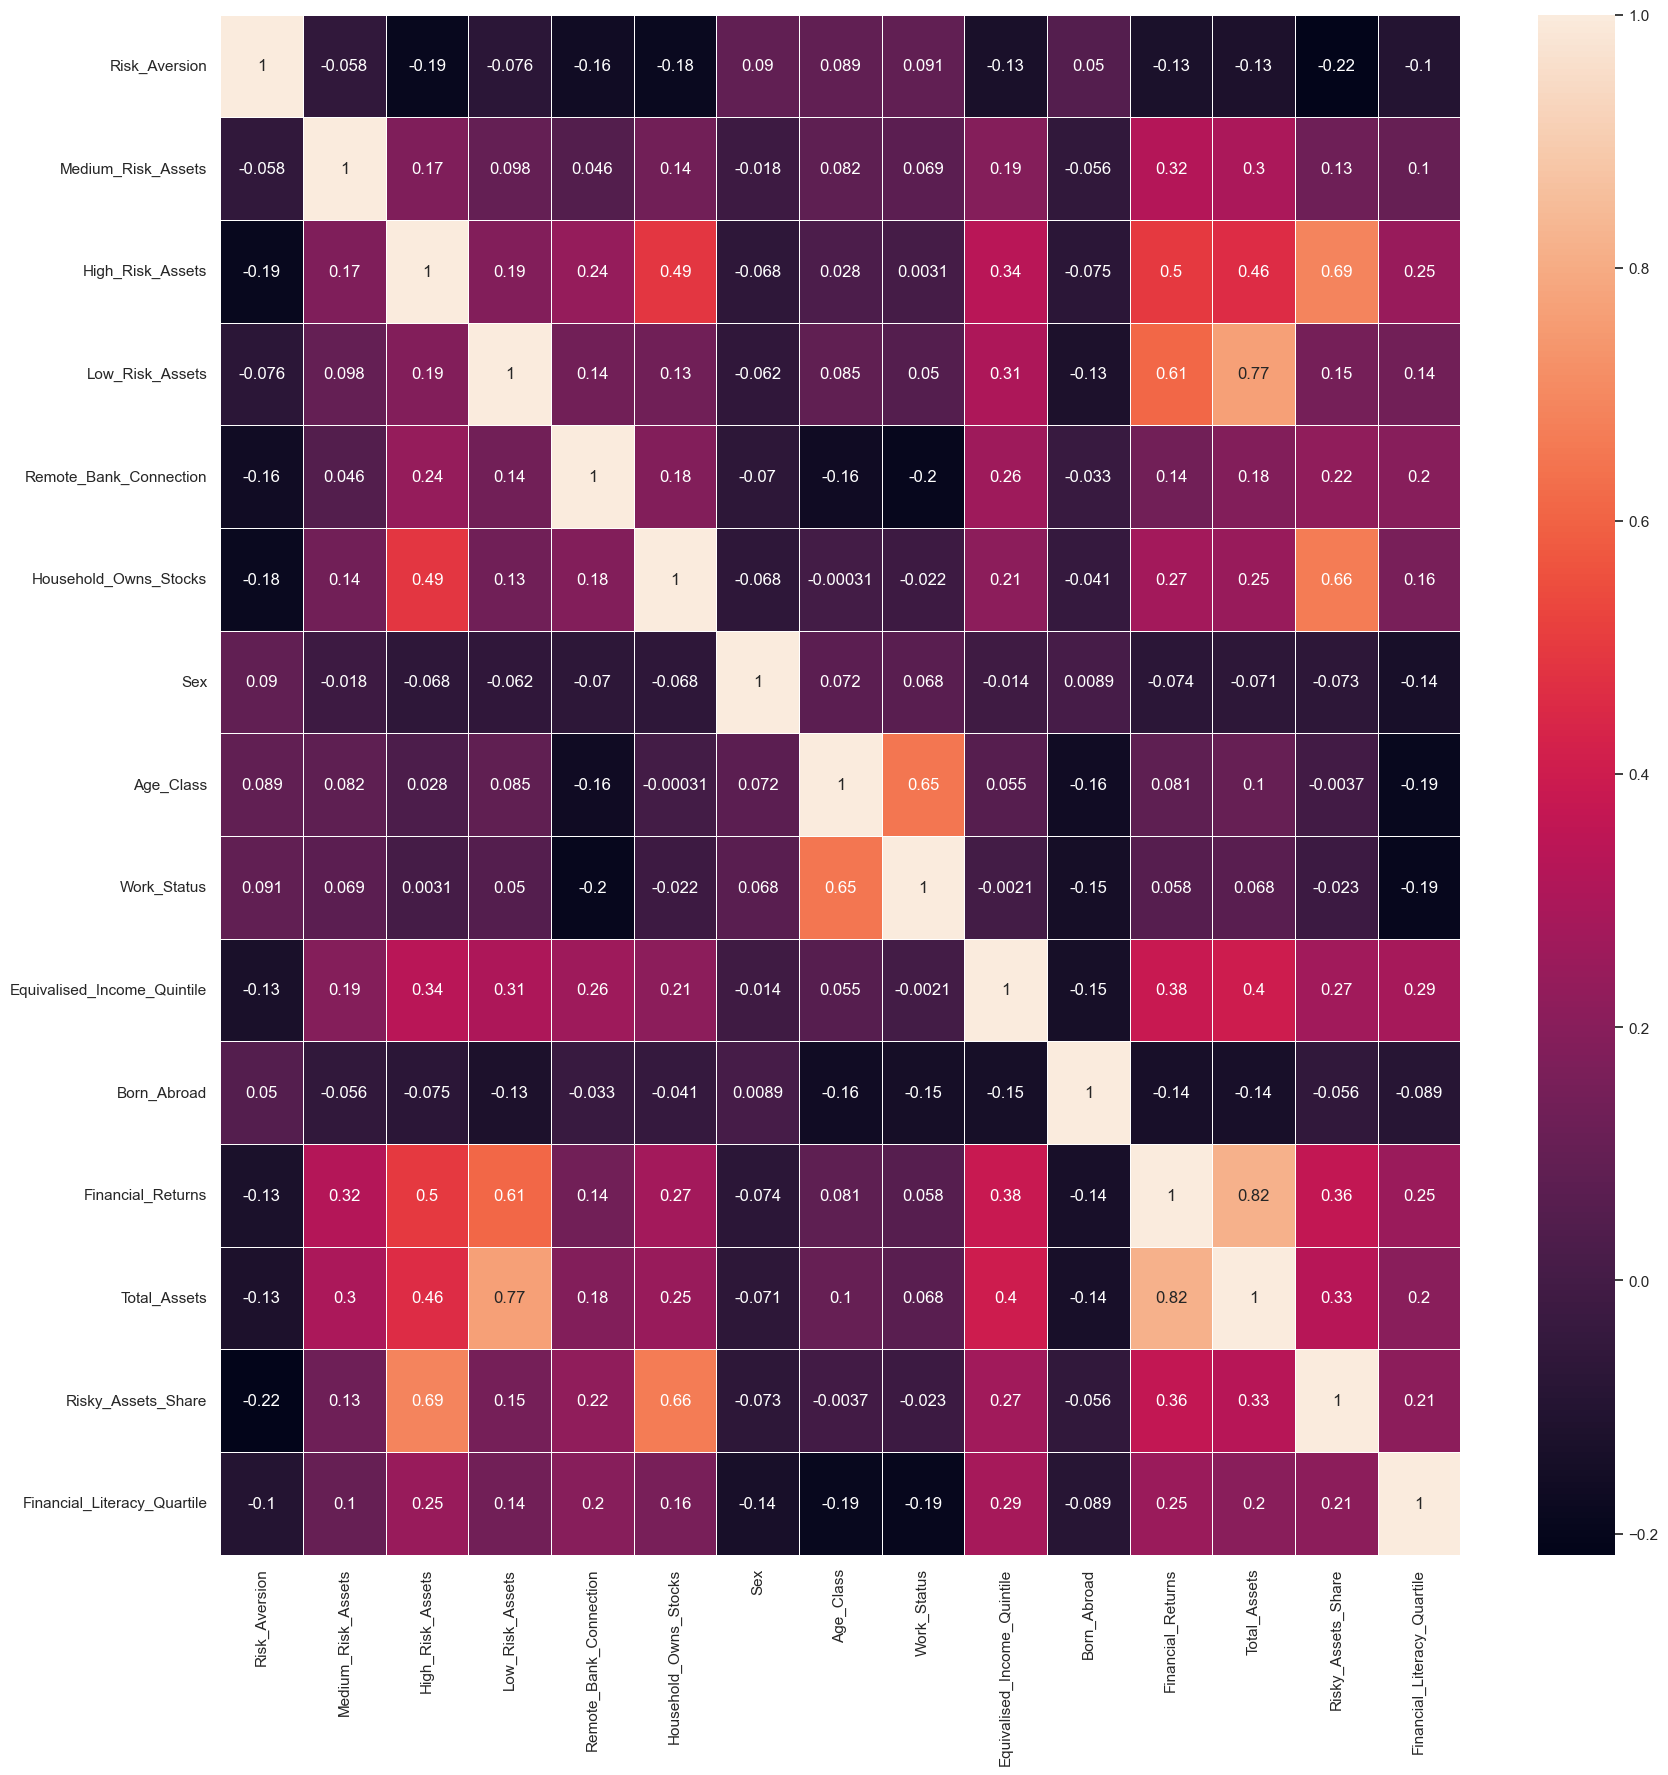

In [35]:
kendall_corrmat(inv_type_data_2nd_ver)

Now we have to look a bit closer at the variables describing assets:

In [36]:
# Create variable to compare with Total_Assets
total_assets = inv_type_data_2nd_ver["Low_Risk_Assets"] + inv_type_data_2nd_ver["Medium_Risk_Assets"] + \
               inv_type_data_2nd_ver["High_Risk_Assets"]

In [37]:
# Compare Total_Assets with sum of Risk Asset variables
round(inv_type_data_2nd_ver["Total_Assets"], 1).equals(round(total_assets, 1))

True

In [38]:
# Check for multicollinearity between the four Asset variables
check_vif(inv_type_data_2nd_ver, "Financial_Returns")

C:\Users\Unknown\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


const                          54.639969
Risk_Aversion                   1.089870
Medium_Risk_Assets                   inf
High_Risk_Assets                     inf
Low_Risk_Assets                      inf
Remote_Bank_Connection          1.184807
Household_Owns_Stocks           1.401433
Sex                             1.036977
Age_Class                       1.942541
Work_Status                     1.929289
Equivalised_Income_Quintile     1.310618
Born_Abroad                     1.076892
Total_Assets                         inf
Risky_Assets_Share              1.441313
Financial_Literacy_Quartile     1.277013
dtype: float64

We can see from the above cells that "Total_Assets" is basically the sum of "Low" plus "Medium" plus "High_Risk_Assets", which explains the "inf" value we get when we check for multicollinearity. We will therefore drop the three risk variables, keeping only the "Risky_Assets_Share" and "Household_Owns_Stocks" variables as indicators of portfolio risk: 

In [39]:
# Drop variables
inv_type_data_2nd_ver.drop(["Medium_Risk_Assets", "High_Risk_Assets", "Low_Risk_Assets"], axis=1, inplace=True)

In [40]:
# Recheck for multicollinearity
check_vif(inv_type_data_2nd_ver, "Financial_Returns")

const                          54.620214
Risk_Aversion                   1.089732
Remote_Bank_Connection          1.183809
Household_Owns_Stocks           1.394435
Sex                             1.036804
Age_Class                       1.942052
Work_Status                     1.928922
Equivalised_Income_Quintile     1.305024
Born_Abroad                     1.076851
Total_Assets                    1.029062
Risky_Assets_Share              1.423572
Financial_Literacy_Quartile     1.276723
dtype: float64

<AxesSubplot: >

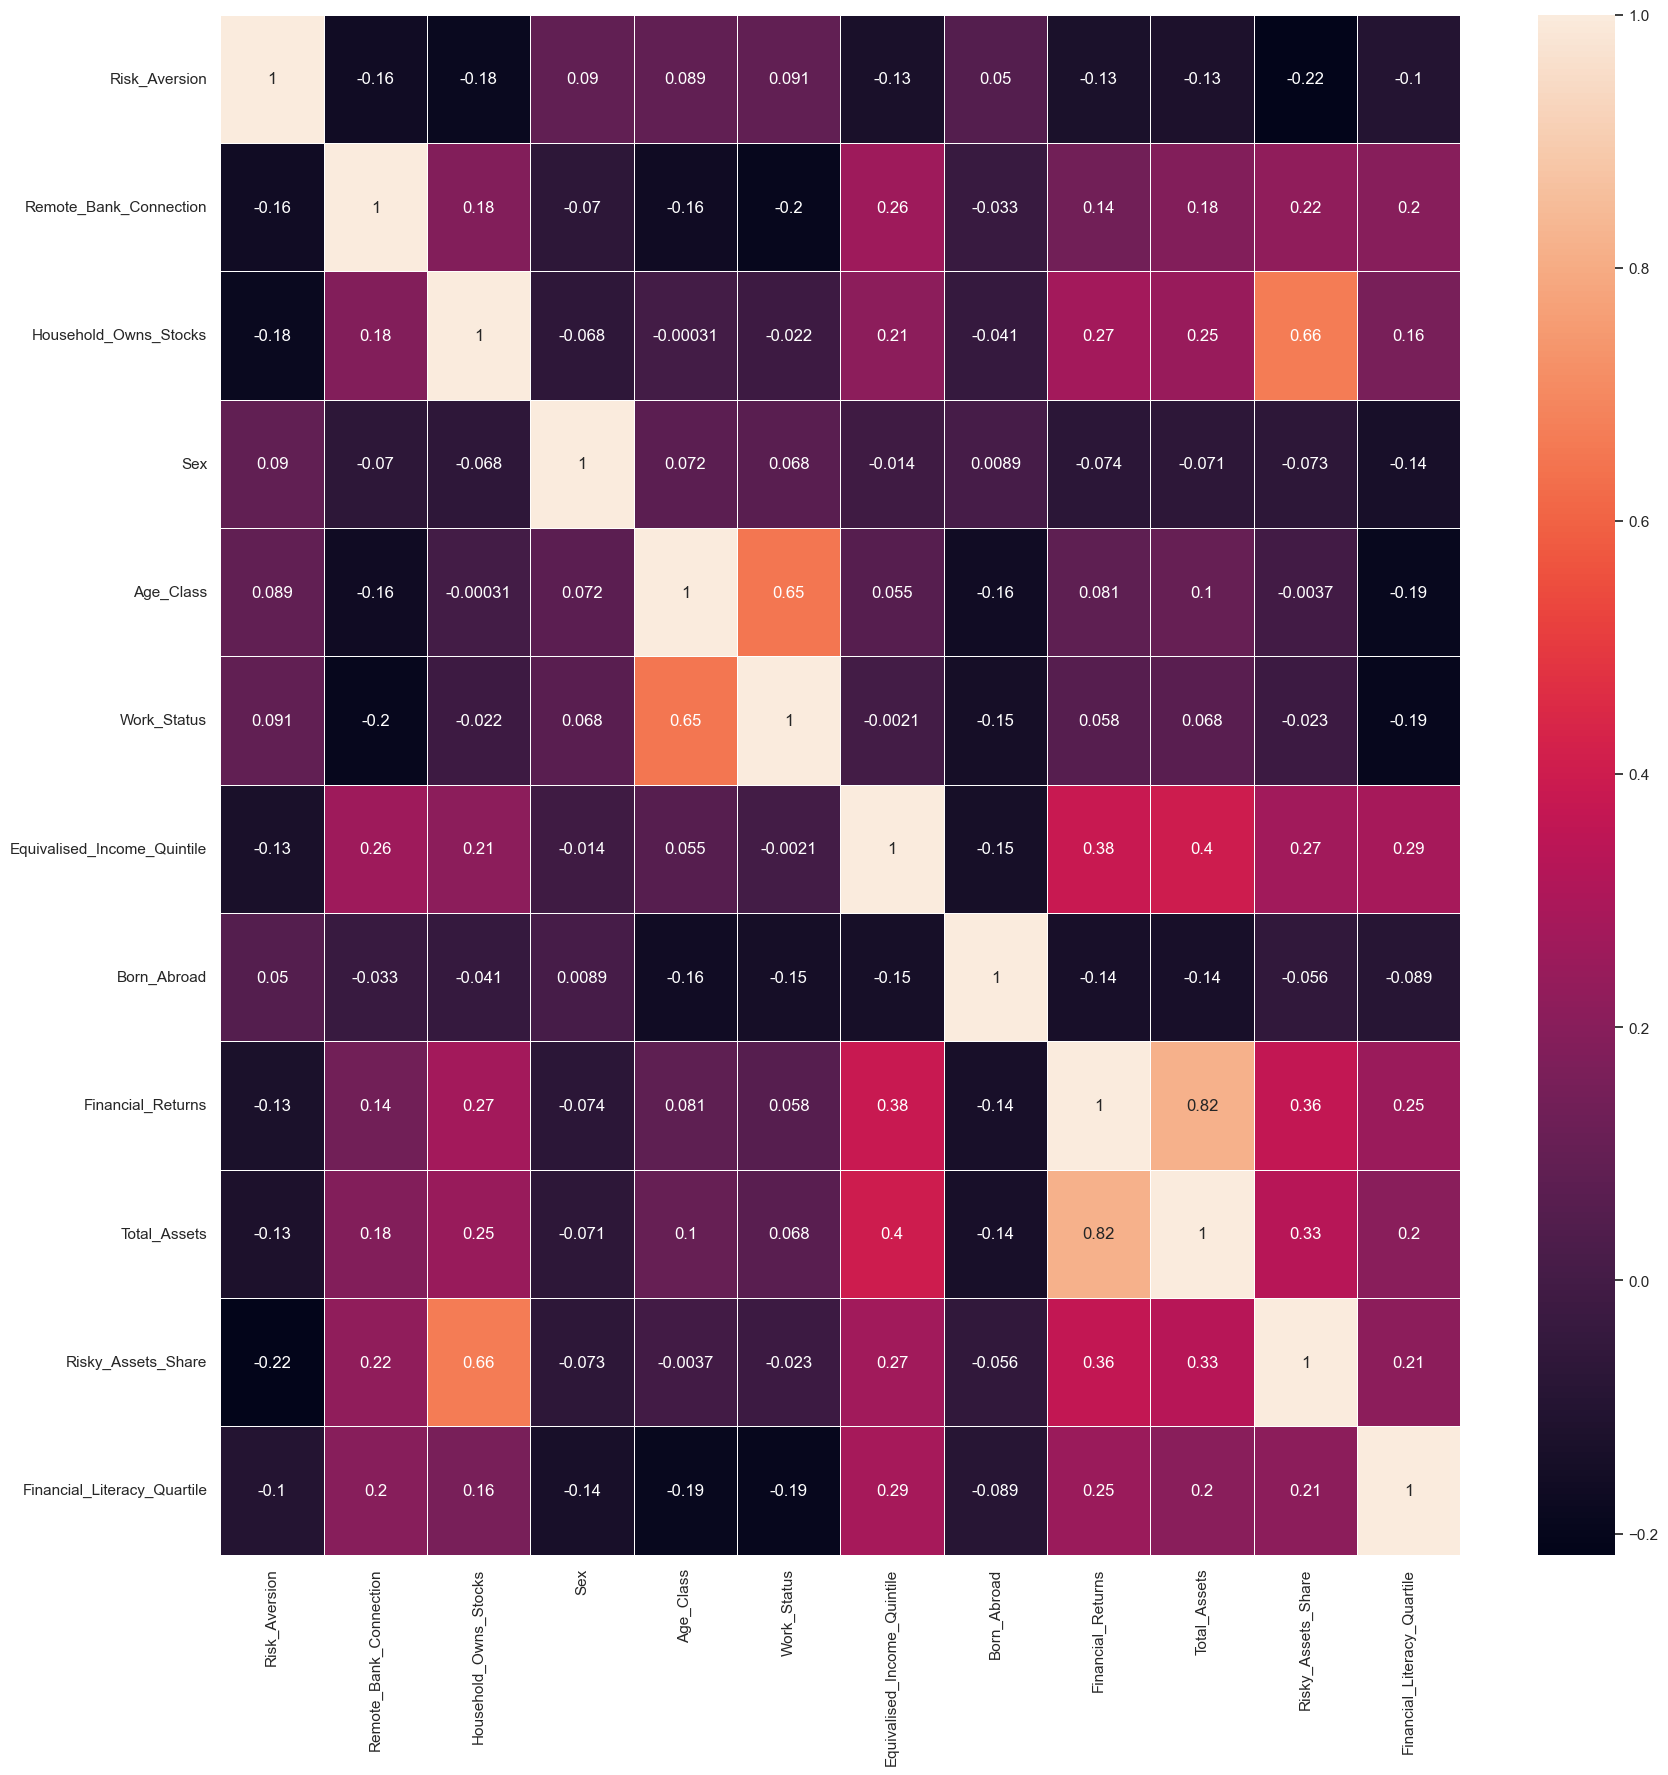

In [41]:
kendall_corrmat(inv_type_data_2nd_ver)

Before I deal with the categorical variables, I will examine the only ratio we have in our dataset, the "Risky_Assets_Share". First, I will check the percentage of observations that follow the [age-old investment rule of not investing more than 10% in high-risk assets](https://www.fca.org.uk/investsmart/understanding-high-risk-investments):

In [42]:
# Check how many individuals had risky assets consisting more than 10% of their total assets
len(inv_type_data_1rst_ver.loc[inv_type_data_1rst_ver["Risky_Assets_Share"] > 0.10])

5362

The vast majority of the portfolios follow the 10% rule. In the following cell, we will change that into a categorical which will explore whether the observation violates that rule. In order to correctly ```onehotencode``` the rest of the categorical variables by using ```scikit-learn```'s ```onehotencoder```, we will first turn all integers into strings describing the categories of each variable:

In [43]:
# Replace all ordinal variables with strings to allow for further manipulation
inv_type_data_2nd_ver["Risk_Aversion"].replace({1: "no_risk_aversion",
                                                2: "low_risk_aversion",
                                                3: "medium_risk_aversion",
                                                4: "high_risk_aversion"}, inplace=True)

inv_type_data_2nd_ver["Age_Class"].replace({1: "30_and_under",
                                            2: "31-40",
                                            3: "41-50",
                                            4: "51-65",
                                            5: "over_65"}, inplace=True)

inv_type_data_2nd_ver["Equivalised_Income_Quintile"].replace({1: "First_Quantile",
                                                              2: "Second_Quantile",
                                                              3: "Third_Quantile",
                                                              4: "Fourth_Quantile",
                                                              5: "Fifth_Quantile"}, inplace=True)


inv_type_data_2nd_ver["Sex"].replace({1: "Male",   # How... progressive of you, Bank of Italy.
                                      2: "Female"}, inplace=True)


inv_type_data_2nd_ver["Work_Status"].replace({1: "Employee",
                                              2: "Self_employed",
                                              3: "Not_employed"}, inplace=True)


inv_type_data_2nd_ver["Work_Status"].replace({1: "Employee",
                                              2: "Self_employed",
                                              3: "Not_employed"}, inplace=True)

# Manipulate column to represent 10% high risk rule
for ratio in inv_type_data_2nd_ver["Risky_Assets_Share"].values:
    if ratio > 0.10:
        inv_type_data_2nd_ver["Risky_Assets_Share"].replace(ratio, 1, inplace=True)
    else:
        inv_type_data_2nd_ver["Risky_Assets_Share"].replace(ratio, 0, inplace=True)

In [44]:
# Rename column to properly reflect the new values
inv_type_data_2nd_ver.rename({"Risky_Assets_Share": "High_Risk_Rule_Violated"}, axis=1, inplace=True)

In [45]:
inv_type_data_2nd_ver

Risk_Aversion  Remote_Bank_Connection  Household_Owns_Stocks  \
0        high_risk_aversion                       0                      0   
1         low_risk_aversion                       0                      1   
2         low_risk_aversion                       0                      0   
3        high_risk_aversion                       0                      0   
4        high_risk_aversion                       0                      0   
...                     ...                     ...                    ...   
52124  medium_risk_aversion                       1                      0   
52125    high_risk_aversion                       1                      0   
52126     low_risk_aversion                       1                      1   
52127  medium_risk_aversion                       1                      0   
52128  medium_risk_aversion                       0                      0   

          Sex     Age_Class    Work_Status Equivalised_Income_Quintile  \
0        Male  30_and_under       Employee              Fifth_Quantile   
1        Male         41-50       Employee              Fifth_Quantile   
2        Male         51-65   Not_employed              Fifth_Quantile   
3      Female         31-40       Employee              Fifth_Quantile   
4        Male         51-65       Employee              Third_Quantile   
...       ...           ...            ...                         ...   
52124    Male         51-65       Employee              Fifth_Quantile   
52125    Male         31-40  Self_employed              Fifth_Quantile   
52126    Male         51-65  Self_employed              Fifth_Quantile   
52127  Female         51-65       Employee              Fifth_Quantile   
52128    Male         41-50       Employee              Third_Quantile   

       Born_Abroad  Financial_Returns   Total_Assets  High_Risk_Rule_Violated  \
0                0          15.891242    1915.245951                      0.0   
1                0         307.032743   12106.905660                      1.0   
2                0        3512.961650  150000.000000                      0.0   
3                0          25.779542    3107.004663                      0.0   
4                0           9.930863    1196.888574                      0.0   
...            ...                ...            ...                      ...   
52124            0          10.469156    2500.000000                      0.0   
52125            0          67.977404   16232.779757                      0.0   
52126            0         649.766498   64372.523887                      1.0   
52127            0           0.000000       0.000000                      0.0   
52128            0          11.479153    2741.183925                      0.0   

       Financial_Literacy_Quartile  
0                                4  
1                                3  
2                                4  
3                                4  
4                                3  
...                            ...  
52124                            1  
52125                            3  
52126                            3  
52127                            2  
52128                            2  

[46356 rows x 12 columns]

Next, we will apply the ```onehotencoder``` to our data. Instead of using the ```drop``` attribute, we perform further, heavy manipulation to reduce the number of variables while keeping the original essence as intact as possible. Note that I will keep the verbose names from ```onehotencoder``` to make the manipulation easier to comprehend, though this is the only time I will do so:

In [46]:
# Properly re-encode categorical variables
encoding = make_column_transformer((OneHotEncoder(),
                                    ["Risk_Aversion", "Age_Class", "Sex", 
                                     "Work_Status", "Equivalised_Income_Quintile",
                                     "Financial_Literacy_Quartile"]), remainder="passthrough")

cat_encoded = encoding.fit_transform(inv_type_data_2nd_ver)
inv_type_data_3rd_ver = pd.DataFrame(cat_encoded, columns=encoding.get_feature_names_out())

In [47]:
inv_type_data_3rd_ver

onehotencoder__Risk_Aversion_high_risk_aversion  \
0                                                  1.0   
1                                                  0.0   
2                                                  0.0   
3                                                  1.0   
4                                                  1.0   
...                                                ...   
46351                                              0.0   
46352                                              1.0   
46353                                              0.0   
46354                                              0.0   
46355                                              0.0   

       onehotencoder__Risk_Aversion_low_risk_aversion  \
0                                                 0.0   
1                                                 1.0   
2                                                 1.0   
3                                                 0.0   
4                                                 0.0   
...                                               ...   
46351                                             0.0   
46352                                             0.0   
46353                                             1.0   
46354                                             0.0   
46355                                             0.0   

       onehotencoder__Risk_Aversion_medium_risk_aversion  \
0                                                    0.0   
1                                                    0.0   
2                                                    0.0   
3                                                    0.0   
4                                                    0.0   
...                                                  ...   
46351                                                1.0   
46352                                                0.0   
46353                                                0.0   
46354                                                1.0   
46355                                                1.0   

       onehotencoder__Risk_Aversion_no_risk_aversion  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
46351                                            0.0   
46352                                            0.0   
46353                                            0.0   
46354                                            0.0   
46355                                            0.0   

       onehotencoder__Age_Class_30_and_under  onehotencoder__Age_Class_31-40  \
0                                        1.0                             0.0   
1                                        0.0                             0.0   
2                                        0.0                             0.0   
3                                        0.0                             1.0   
4                                        0.0                             0.0   
...                                      ...                             ...   
46351                                    0.0                             0.0   
46352                                    0.0                             1.0   
46353                                    0.0                             0.0   
46354                                    0.0                             0.0   
46355                                    0.0                             0.0   

       onehotencoder__Age_Class_41-50  onehotencoder__Age_Class_51-65  \
0                                 0.0                             0.0   
1                                 1.0                             0.0   
2                                 0.0              

In [48]:
# Heavy column manipulation to reflect similar variables
inv_type_data_3rd_ver["Is_Risk_Averse"] = inv_type_data_3rd_ver["onehotencoder__Risk_Aversion_high_risk_aversion"] +\
                                          inv_type_data_3rd_ver["onehotencoder__Risk_Aversion_medium_risk_aversion"] 

inv_type_data_3rd_ver["Age_under_40"] = inv_type_data_3rd_ver["onehotencoder__Age_Class_30_and_under"] +\
                                        inv_type_data_3rd_ver["onehotencoder__Age_Class_31-40"]

inv_type_data_3rd_ver["Has_Employment"] = inv_type_data_3rd_ver["onehotencoder__Work_Status_Employee"] +\
                                          inv_type_data_3rd_ver["onehotencoder__Work_Status_Self_employed"]

inv_type_data_3rd_ver["Med_to_Low_Income"] = inv_type_data_3rd_ver["onehotencoder__Equivalised_\
Income_Quintile_First_Quantile"] + inv_type_data_3rd_ver["onehotencoder__Equivalised_\
Income_Quintile_Second_Quantile"] + inv_type_data_3rd_ver["onehotencoder__Equivalised_\
Income_Quintile_Third_Quantile"]


inv_type_data_3rd_ver["Is_Financially_Literate"]  = inv_type_data_3rd_ver["onehotencoder__\
Financial_Literacy_Quartile_3"] + inv_type_data_3rd_ver["onehotencoder__\
Financial_Literacy_Quartile_4"]

In [49]:
# Drop categories will be replaced by our created categorical variables
inv_type_data_3rd_ver.drop(["onehotencoder__Risk_Aversion_high_risk_aversion", 
                            "onehotencoder__Risk_Aversion_low_risk_aversion",
                            "onehotencoder__Risk_Aversion_medium_risk_aversion", 
                            "onehotencoder__Risk_Aversion_no_risk_aversion",
                            "onehotencoder__Age_Class_30_and_under",
                            "onehotencoder__Age_Class_31-40", 
                            "onehotencoder__Age_Class_41-50",
                            "onehotencoder__Age_Class_51-65", 
                            "onehotencoder__Age_Class_over_65",
                            "onehotencoder__Work_Status_Employee",
                            "onehotencoder__Work_Status_Not_employed",
                            "onehotencoder__Work_Status_Self_employed",
                            "onehotencoder__Equivalised_Income_Quintile_Fifth_Quantile", 
                            "onehotencoder__Equivalised_Income_Quintile_First_Quantile", 
                            "onehotencoder__Equivalised_Income_Quintile_Fourth_Quantile",
                            "onehotencoder__Equivalised_Income_Quintile_Second_Quantile",
                            "onehotencoder__Equivalised_Income_Quintile_Third_Quantile",
                            "onehotencoder__Financial_Literacy_Quartile_1",
                            "onehotencoder__Financial_Literacy_Quartile_2",
                            "onehotencoder__Financial_Literacy_Quartile_3",
                            "onehotencoder__Financial_Literacy_Quartile_4",
                            "onehotencoder__Sex_Male"], axis=1, inplace=True)

In [50]:
inv_type_data_3rd_ver

onehotencoder__Sex_Female  remainder__Remote_Bank_Connection  \
0                            0.0                                0.0   
1                            0.0                                0.0   
2                            0.0                                0.0   
3                            1.0                                0.0   
4                            0.0                                0.0   
...                          ...                                ...   
46351                        0.0                                1.0   
46352                        0.0                                1.0   
46353                        0.0                                1.0   
46354                        1.0                                1.0   
46355                        0.0                                0.0   

       remainder__Household_Owns_Stocks  remainder__Born_Abroad  \
0                                   0.0                     0.0   
1                                   1.0                     0.0   
2                                   0.0                     0.0   
3                                   0.0                     0.0   
4                                   0.0                     0.0   
...                                 ...                     ...   
46351                               0.0                     0.0   
46352                               0.0                     0.0   
46353                               1.0                     0.0   
46354                               0.0                     0.0   
46355                               0.0                     0.0   

       remainder__Financial_Returns  remainder__Total_Assets  \
0                         15.891242              1915.245951   
1                        307.032743             12106.905660   
2                       3512.961650            150000.000000   
3                         25.779542              3107.004663   
4                          9.930863              1196.888574   
...                             ...                      ...   
46351                     10.469156              2500.000000   
46352                     67.977404             16232.779757   
46353                    649.766498             64372.523887   
46354                      0.000000                 0.000000   
46355                     11.479153              2741.183925   

       remainder__High_Risk_Rule_Violated  Is_Risk_Averse  Age_under_40  \
0                                     0.0             1.0           1.0   
1                                     1.0             0.0           0.0   
2                                     0.0             0.0           0.0   
3                                     0.0             1.0           1.0   
4                                     0.0             1.0           0.0   
...                                   ...             ...           ...   
46351                                 0.0             1.0           0.0   
46352                                 0.0             1.0           1.0   
46353                                 1.0             0.0           0.0   
46354                                 0.0             1.0           0.0   
46355                                 0.0             1.0           0.0   

       Has_Employment  Med_to_Low_Income  Is_Financially_Literate  
0                 1.0                0.0                      1.0  
1                 1.0                0.0                      1.0  
2                 0.0                0.0                      1.0  
3                 1.0                0.0                      1.0  
4                 1.0                1.0                      1.0  
...               ...                ...                      ...  
46351             1.0                0.0                      0.0  
46352             1.0                0.0                      1.0  
46353             1.0                0.0                      1.0  

In [51]:
# Dictionary for better describing variables
investor_categorical_dict = {"onehotencoder__Sex_Female": "Is_Female", 
                              "remainder__Total_Assets": "Total_Assets",
                              "remainder__Financial_Returns": "Financial_Returns",
                              "remainder__High_Risk_Rule_Violated": "High_Risk_Rule_Violated",
                              "remainder__Remote_Bank_Connection": "Remote_Bank_Connection", 
                              "remainder__Household_Owns_Stocks": "Household_Owns_Stocks",
                              "remainder__Born_Abroad": "Born_Abroad"}

In [52]:
inv_type_data_4rth_ver = inv_type_data_3rd_ver.copy()
inv_type_data_4rth_ver.rename(columns=investor_categorical_dict, inplace=True)

In [53]:
# Check for duplicates
inv_type_data_4rth_ver.duplicated().any()

True

In [54]:
# Drop duplicates
inv_type_data_4rth_ver.drop_duplicates(inplace=True)

<AxesSubplot: >

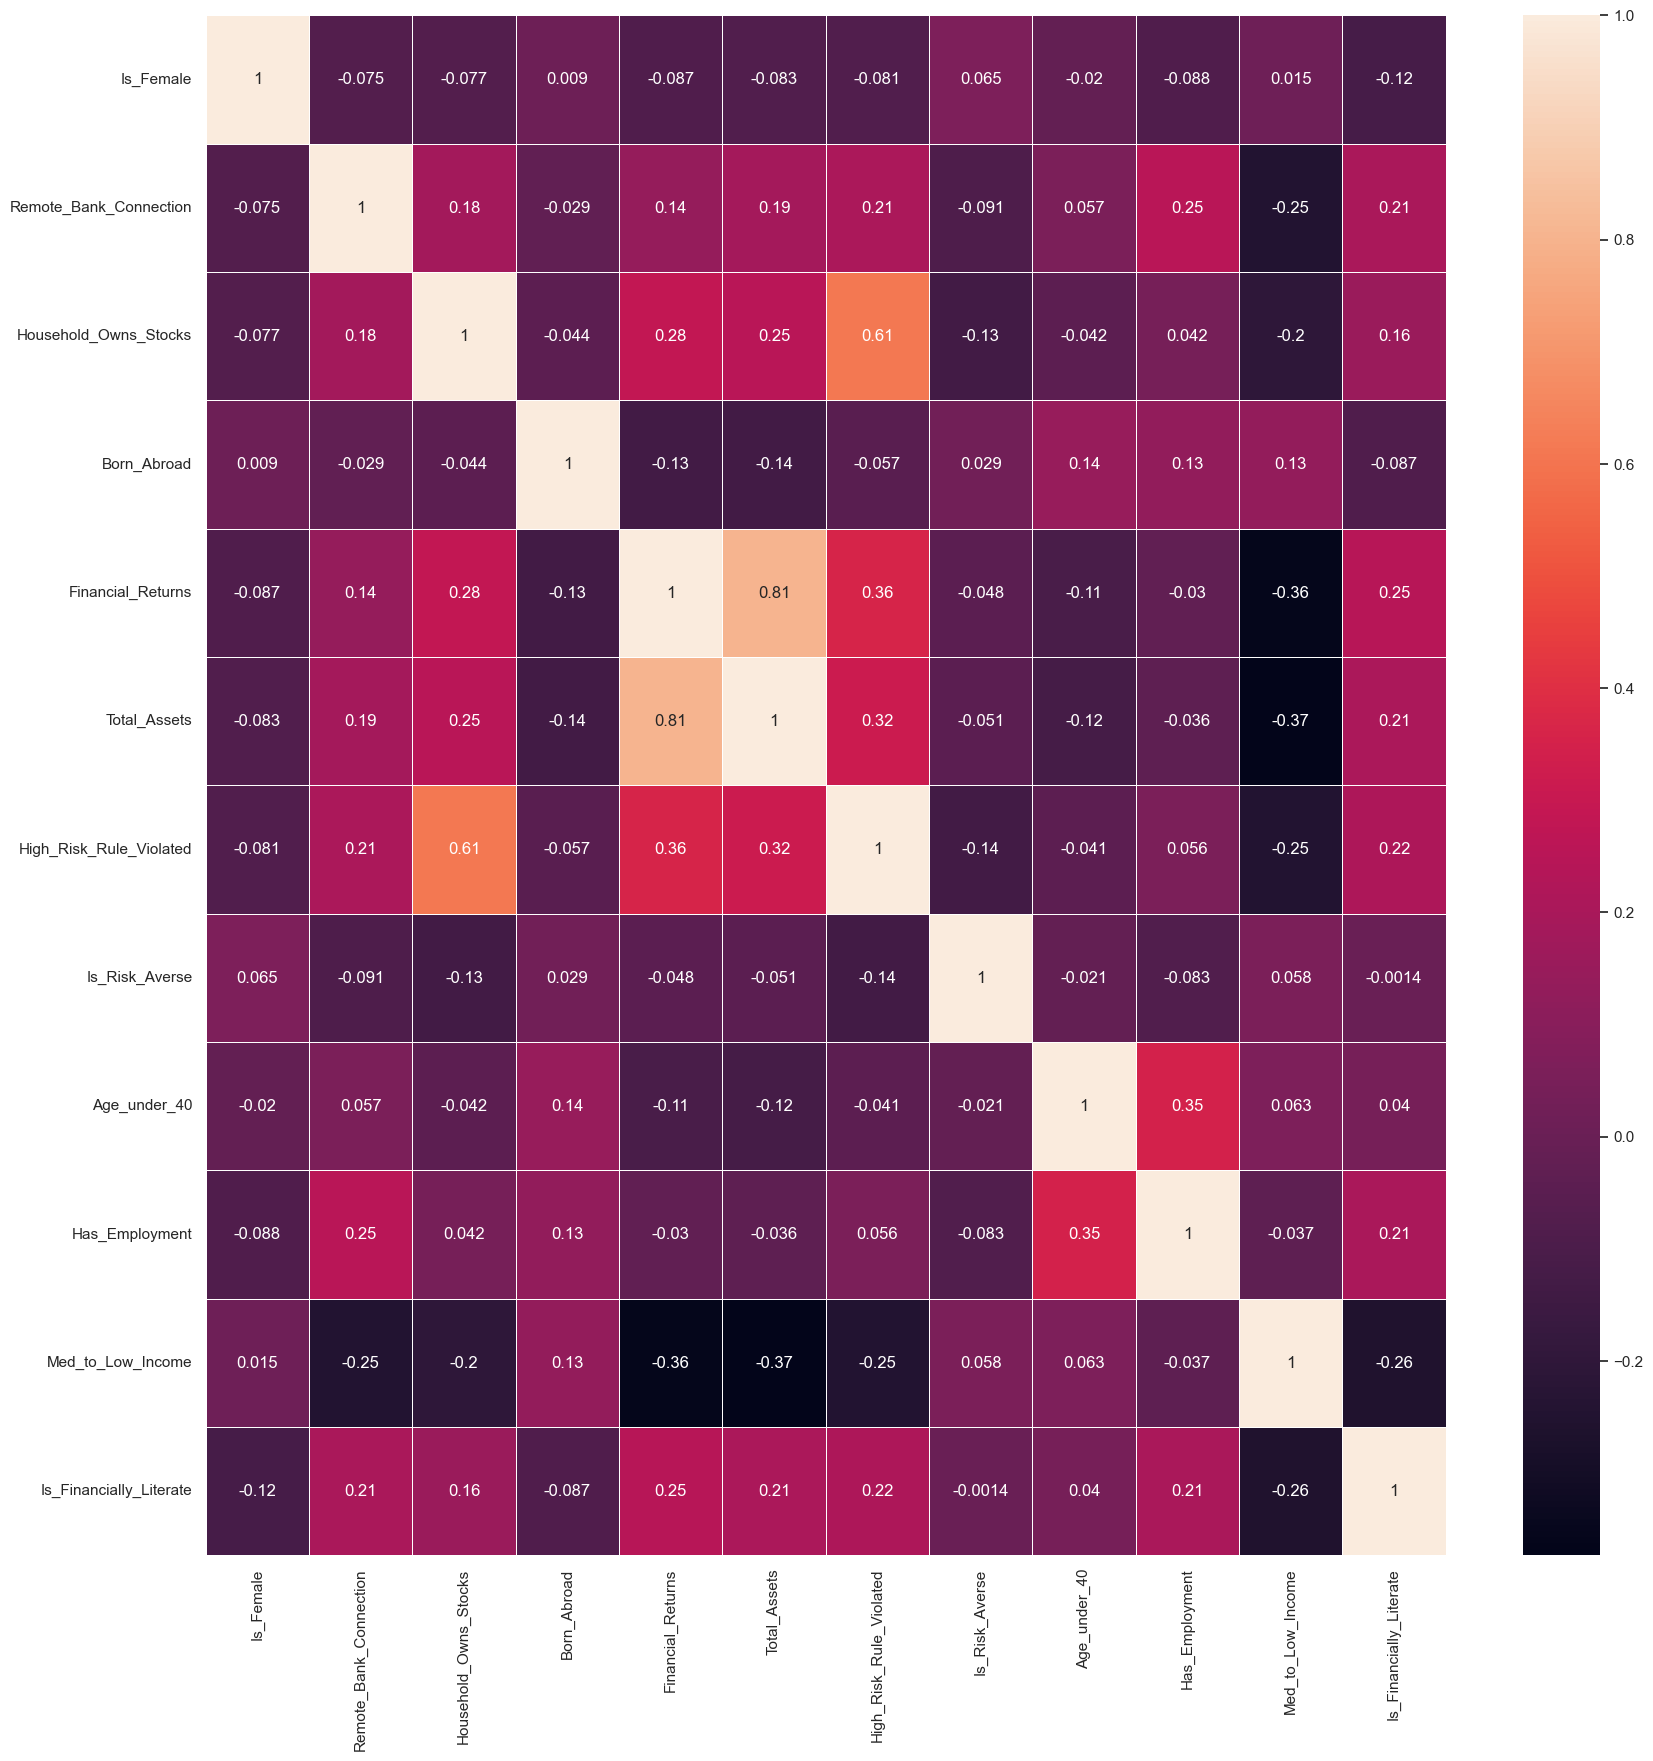

In [55]:
kendall_corrmat(inv_type_data_4rth_ver)

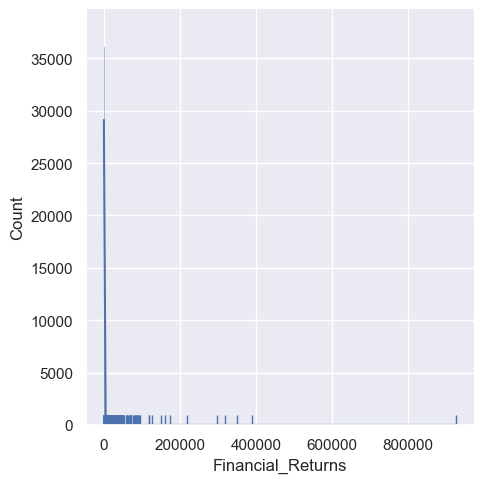

In [56]:
# Plot distribution of dependent variable
sns.displot(inv_type_data_4rth_ver, x="Financial_Returns", kde=True, bins=500, rug=True);

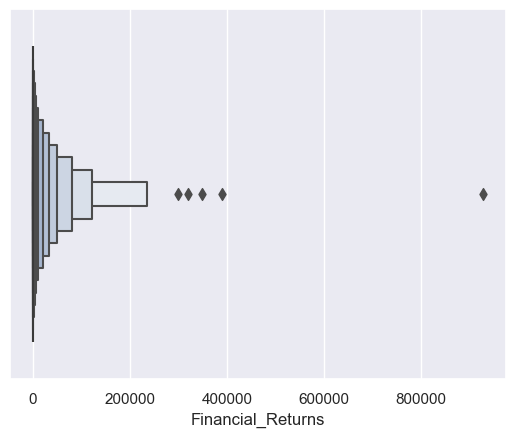

In [57]:
sns.boxenplot(inv_type_data_4rth_ver, x="Financial_Returns", scale="linear");

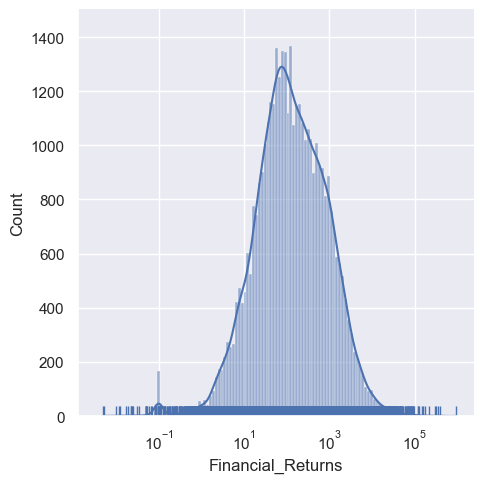

In [58]:
# Create test df to see distribution of log-transformed dependent variable
test_for_dis = inv_type_data_4rth_ver.copy()
test_for_dis["Financial_Returns"].replace(0, 0.1, inplace=True)

sns.displot(test_for_dis, x="Financial_Returns", log_scale=True, kde=True, rug=True);

In [59]:
# Kolmogorov–Smirnov test for lognormal distribution
kstest(test_for_dis["Financial_Returns"], "lognorm", lognorm.fit(test_for_dis["Financial_Returns"]))

KstestResult(statistic=0.014859920347505107, pvalue=5.883235790806931e-08, statistic_location=95.722640318, statistic_sign=1)

At this point, the next few calculations will prove something which might not seem logical at first. Bear with me:

In [60]:
# Check number of individuals who did not invest
len(inv_type_data_1rst_ver.loc[inv_type_data_1rst_ver["Total_Assets"] == 0])

4686

In [61]:
# Check number of individuals with no returns
len(inv_type_data_1rst_ver.loc[inv_type_data_1rst_ver["Financial_Returns"] == 0])

4686

In [62]:
# Check if all observations of individuals with no returns match those with no investments
no_assets = inv_type_data_1rst_ver.loc[inv_type_data_1rst_ver["Total_Assets"] == 0]

no_returns = inv_type_data_1rst_ver.loc[inv_type_data_1rst_ver["Financial_Returns"] == 0]

no_assets.equals(no_returns)

True

Our data have massive outliers, and even though they look better when logged, the Kolmogorov-Smirnov test shows that they are not lognormal. 

Additionally, the observations with zeroes in "Financial_Returns" are the exact same as the ones with zeroes in "Total_Assets". What this means is that the dataset does not include people who *did* invest, but either suffered losses or made no profit. It only includes those who invested and won and those who did not invest at all. 

If that seems like an unintuitive thing to do, that's because it is. If the zeroes meant either losses or no returns from investments, it would make sense to incorporate them into our regression, probably by using a zero-inflated General Linear Model or by encoding our dependent variable in 1/0 to make it categorical.  In that last case, the traditional approach would be to calculate two regressions: a Logistic Regression to understand the correlation between independent variables and a categorical (binary) dependent variable signifying those who won and those who lost, and a Simple Linear Regression to understand the relationship between independent variables and the "Financial_Returns" variable.

That was the course I originally took. It wasn't until I fit a Logistic Regression with my dependent variable transformed into a categorical that I realized what the zeroes in "Financial_Returns" actually meant. And that was only because the ```statsmodels``` Logistic Regression model kept warning me about "quasi-separation", i.e. one independent variable perfectly separates the dependent variable (0 total assets perfectly matched 0 total returns). 

In any case, what we are therefore dealing with here is a bimodal distribution of two entirely different variables squeezed into one: one variable describing the actual "Financial_Returns" and one describing whether people invested or not (or rather, describing people who did NOT invest). As such, we will drop the observations with zeroes in "Financial_Returns" to avoid their influence on our models:

In [63]:
# Drop observations that have made no investment
final_investor_vars = inv_type_data_4rth_ver.drop(
    inv_type_data_4rth_ver[inv_type_data_4rth_ver["Financial_Returns"] == 0].index).reset_index(drop=True).copy()

In [64]:
# Check for duplicates
final_investor_vars.duplicated().any()

False

In [65]:
# Final Variables
final_investor_vars

Is_Female  Remote_Bank_Connection  Household_Owns_Stocks  Born_Abroad  \
0            0.0                     0.0                    0.0          0.0   
1            0.0                     0.0                    1.0          0.0   
2            0.0                     0.0                    0.0          0.0   
3            1.0                     0.0                    0.0          0.0   
4            0.0                     0.0                    0.0          0.0   
...          ...                     ...                    ...          ...   
39077        1.0                     1.0                    0.0          0.0   
39078        0.0                     1.0                    0.0          0.0   
39079        0.0                     1.0                    0.0          0.0   
39080        0.0                     1.0                    1.0          0.0   
39081        0.0                     0.0                    0.0          0.0   

       Financial_Returns   Total_Assets  High_Risk_Rule_Violated  \
0              15.891242    1915.245951                      0.0   
1             307.032743   12106.905660                      1.0   
2            3512.961650  150000.000000                      0.0   
3              25.779542    3107.004663                      0.0   
4               9.930863    1196.888574                      0.0   
...                  ...            ...                      ...   
39077         666.204819  156501.000000                      0.0   
39078          10.469156    2500.000000                      0.0   
39079          67.977404   16232.779757                      0.0   
39080         649.766498   64372.523887                      1.0   
39081          11.479153    2741.183925                      0.0   

       Is_Risk_Averse  Age_under_40  Has_Employment  Med_to_Low_Income  \
0                 1.0           1.0             1.0                0.0   
1                 0.0           0.0             1.0                0.0   
2                 0.0           0.0             0.0                0.0   
3                 1.0           1.0             1.0                0.0   
4                 1.0           0.0             1.0                1.0   
...               ...           ...             ...                ...   
39077             1.0           0.0             1.0                0.0   
39078             1.0           0.0             1.0                0.0   
39079             1.0           1.0             1.0                0.0   
39080             0.0           0.0             1.0                0.0   
39081             1.0           0.0             1.0                1.0   

       Is_Financially_Literate  
0                          1.0  
1                          1.0  
2                          1.0  
3                          1.0  
4                          1.0  
...                        ...  
39077                      1.0  
39078                      0.0  
39079                      1.0  
39080                      1.0  
39081                      0.0  

[39082 rows x 12 columns]

In [66]:
# Separate dataset to train and test, the latter being 20% of the former
all_vars_unscaled_train, all_vars_unscaled_test = train_test_split(final_investor_vars, 
                                                                   test_size=0.2, 
                                                                   shuffle=True, random_state=0)

In [67]:
# Separation required for scikit learn, but not for statsmodels
all_vars_unscaled_ytrain = all_vars_unscaled_train["Financial_Returns"]
all_vars_unscaled_Xtrain = all_vars_unscaled_train.drop(["Financial_Returns"], axis=1)
all_vars_unscaled_ytest = all_vars_unscaled_test["Financial_Returns"]
all_vars_unscaled_Xtest = all_vars_unscaled_test.drop(["Financial_Returns"], axis=1)

# 4. Regression With Original Variables
<a id="chapter_4"></a>

## 4.1 Error Selection and Baseline: Dummy Regressor
<a id="chapter_4.1"></a>

As one could logically deduce by looking at the variables in the dataset, there is little hope for actual, accurate future prediction of the dependent variable. It would be hard to believe that we can accurately predict a portfolio's returns based only on the initial assets, their risk, and some information about the investor.

I do not think that that was the reason the variable "Financial_Returns" was added to the dataset. Instead, I think the original intention was to gauge whether investor sophistication and bank services affected financial returns, which is very far from actually building a forecasting model based on this data. The article containing this dataset has not, at the time of writing this project, been released yet, so I do not know if my guess is correct.

Nevertheless, nothing stops me from using that data to fit any model, as long as we accept that we cannot have perfect results. So, at this point, it is worth talking a little bit about how to perform model evaluation. ```Scikit-learn``` provides numerous scorers for prediction, while ```statsmodels``` comes with its own results interface.

Our first issue here is that the [R2 score does not seem to work for non-linear models](https://statisticsbyjim.com/regression/r-squared-invalid-nonlinear-regression/), and my purpose is to compare both linear and non-linear models. Another problem is that the Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) do not make any sense for currency. Root Mean Squared Error of Euro? Nope.

While I include the MSE, the RMSE, and R2 in the [function](#chapter_4_functions) that returns model results, I believe the most reasonable metrics for this dataset would be the Mean Absolute Error (MAE) and the Mean Absolute Percentage Error (MAPE). The first would offer us an average error in our original values, euros, and the second would allow us to see how far off our prediction is from the truth (having no zeroes in our dependent variable also helps in MAPE). For a thorough explanation of MAPE, you can read [this post](https://stephenallwright.com/interpret-mape/). Max error could also offer some additional insight since our data has massive outliers. As such these three error types appear at the top of the results dataframe and should be given more consideration compared to the rest.

Next, we will create and fit a Dummy model to our data to act as a baseline. The strategy will be based on the median, since our dependent variable is right-skewed, and the median is more accurate than the mean in right-skewed distributions.

In [68]:
# Strategy is "median" because distribution is right skewed 
dummy_regr = DummyRegressor(strategy="median")
lm_dummy_median = dummy_regr.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
dummy_median_predict = lm_dummy_median.predict(all_vars_unscaled_Xtest)
dummy_median_residuals = (all_vars_unscaled_ytest - dummy_median_predict)
dummy_median_score = lm_dummy_median.score(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

**You can find all the custom functions used in this chapter in [Chapter 4 functions](#chapter_4_functions).**

In [69]:
# Calculate all scores and rename appropriately
dummy_median_model_scores = model_score(dummy_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, 
                                        all_vars_unscaled_ytest, 
                                        dummy_median_predict, round_int=1)
dummy_median_model_scores.rename({"Score Values": "Dummy Median Model Scores"}, axis=1, inplace=True)
dummy_median_model_scores

Dummy Median Model Scores
Mean Absolute Error                              811.9
Max Error                                     298537.7
MAPE                                            1073.2
Mean R2 Score after 5 CV                          -0.0
R2 Score Standard Deviation                        0.0
Root Mean Squared Error                         5350.2
Mean Squared Error                          28624755.2

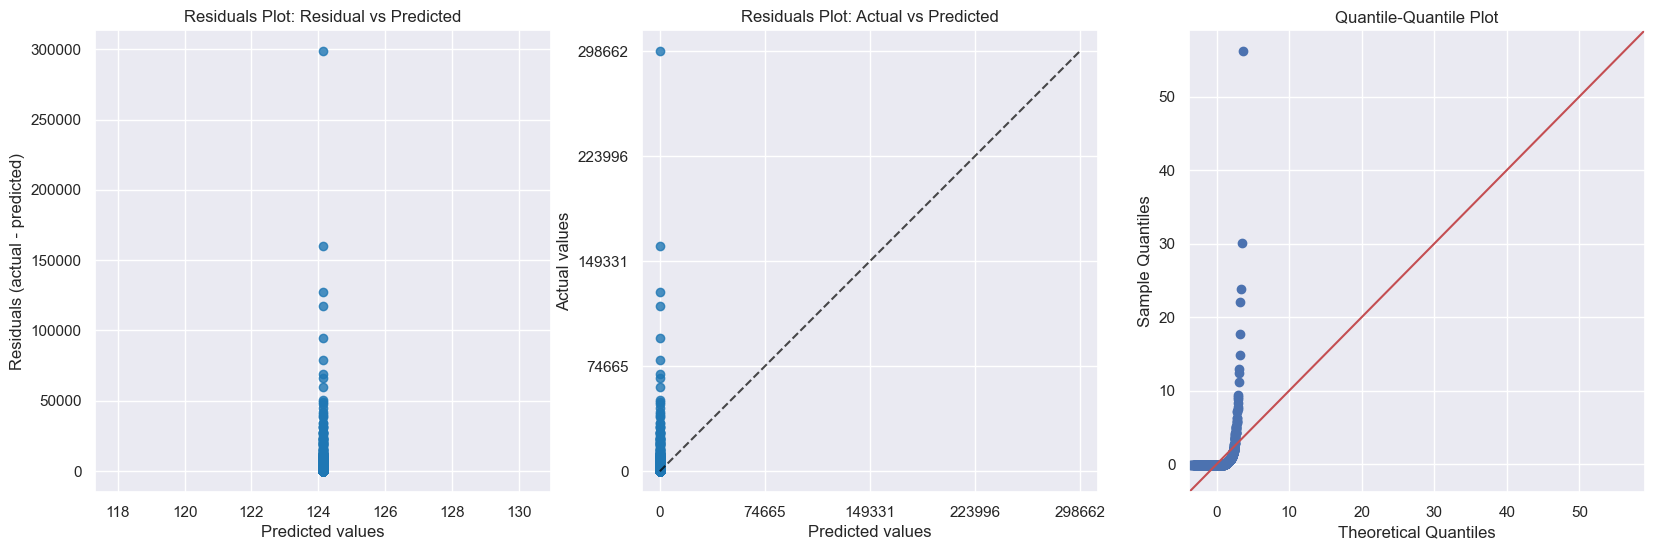

In [70]:
visualize_results(all_vars_unscaled_ytest, dummy_median_predict, dummy_median_residuals)

## 4.2 Linear Regression 
<a id="chapter_4.2"></a>

### Simple Linear Regression

My intention for the next step is to use the classic method of backward elimination of variables with high p-values. The issue presented during this process is the appearance of duplicate values in our fairly large sample.

The effect of duplicates in a sample depends on the model used and differs from model to model. In linear regression, [duplicates reduce p-values and standard errors of variables](https://stats.stackexchange.com/questions/216003/what-are-the-consequences-of-copying-a-data-set-for-ols), but they do not affect the coefficient of determination. Ergo, their elimination will result in relatively inflated p-values and standard errors.

I prefer to err on the side of caution, so I will drop the duplicates appearing from this process.  

In [71]:
# Copy so we can use the original dataset with all variables for non-linear regression
unscaled_train = all_vars_unscaled_train.copy()
unscaled_test = all_vars_unscaled_test.copy()

**You can find all the custom functions used in this chapter in [Chapter 4 functions](#chapter_4_functions).**

In [72]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:25   Log-Likelihood:            -2.9698e+05
No. Observations:               31265   AIC:                         5.940e+05
Df Residuals:                   31253   BIC:                         5.941e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [73]:
drop_variable(unscaled_train, unscaled_test, "Born_Abroad")

In [74]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.216e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:26   Log-Likelihood:            -2.9406e+05
No. Observations:               30940   AIC:                         5.881e+05
Df Residuals:                   30929   BIC:                         5.882e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [75]:
drop_variable(unscaled_train, unscaled_test, "Age_under_40")

In [76]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.321e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:26   Log-Likelihood:            -2.8789e+05
No. Observations:               30256   AIC:                         5.758e+05
Df Residuals:                   30246   BIC:                         5.759e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [77]:
drop_variable(unscaled_train, unscaled_test, "Is_Risk_Averse")

In [78]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.456e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:26   Log-Likelihood:            -2.8241e+05
No. Observations:               29648   AIC:                         5.648e+05
Df Residuals:                   29639   BIC:                         5.649e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [79]:
drop_variable(unscaled_train, unscaled_test, "Is_Female")

In [80]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.592e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:27   Log-Likelihood:            -2.7098e+05
No. Observations:               28383   AIC:                         5.420e+05
Df Residuals:                   28375   BIC:                         5.420e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [81]:
# New separation with fewer variables
unscaled_ytrain = unscaled_train["Financial_Returns"]
unscaled_Xtrain = unscaled_train.drop(["Financial_Returns"], axis=1)
unscaled_ytest = unscaled_test["Financial_Returns"]
unscaled_Xtest = unscaled_test.drop(["Financial_Returns"], axis=1)

In [82]:
linear_regression(unscaled_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.592e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:20:27   Log-Likelihood:            -2.7098e+05
No. Observations:               28383   AIC:                         5.420e+05
Df Residuals:                   28375   BIC:                         5.420e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [83]:
# Define model and fit to data, define predictions and residuals
lin_regr = LinearRegression()
lin_model_unscaled = lin_regr.fit(unscaled_Xtrain, unscaled_ytrain)
unscaled_y_pred = lin_model_unscaled.predict(unscaled_Xtest)
unscaled_model_residuals = (unscaled_ytest - unscaled_y_pred)

# Define score, intercept and coefficients
unscaled_model_score = round(lin_model_unscaled.score(unscaled_Xtrain, unscaled_ytrain), 3)
unscaled_model_intercept = round(lin_model_unscaled.intercept_.item(), 4)
unscaled_model_coefficients = pd.DataFrame(zip(unscaled_Xtrain.columns, lin_model_unscaled.coef_))

# Show score, intercept and coefficients
print(f"The model's R2 score is {unscaled_model_score} with an intercept of \
{unscaled_model_intercept}. \nThe coefficients of the independent variables are: {unscaled_model_coefficients}.")

The model's R2 score is 0.797 with an intercept of 154.6049. 
The coefficients of the independent variables are:                          0           1
0   Remote_Bank_Connection -216.945714
1    Household_Owns_Stocks  702.647397
2             Total_Assets    0.009840
3  High_Risk_Rule_Violated  413.906640
4           Has_Employment -118.483796
5        Med_to_Low_Income -160.243274
6  Is_Financially_Literate  282.214904.


In [84]:
cross_validate(lin_regr, unscaled_Xtrain, unscaled_ytrain, cv=5)

{'fit_time': array([0.02011514, 0.01466727, 0.02016687, 0.01679635, 0.01219845]),
 'score_time': array([0.01012802, 0.00506854, 0.0050137 , 0.        , 0.01009965]),
 'test_score': array([0.8227547 , 0.62569216, 0.41351751, 0.7023199 , 0.5451392 ])}

In [85]:
unscaled_model_scores = model_score(lin_regr, unscaled_Xtrain, unscaled_ytrain, unscaled_ytest, 
                                    unscaled_y_pred, round_int=2)
unscaled_model_scores.rename({"Score Values": "Unscaled Model Scores"}, axis=1, inplace=True)
unscaled_model_scores

Unscaled Model Scores
Mean Absolute Error                         539.83
Max Error                                 85585.64
MAPE                                       1244.77
Mean R2 Score after 5 CV                      0.62
R2 Score Standard Deviation                   0.14
Root Mean Squared Error                    2776.42
Mean Squared Error                      7708527.24

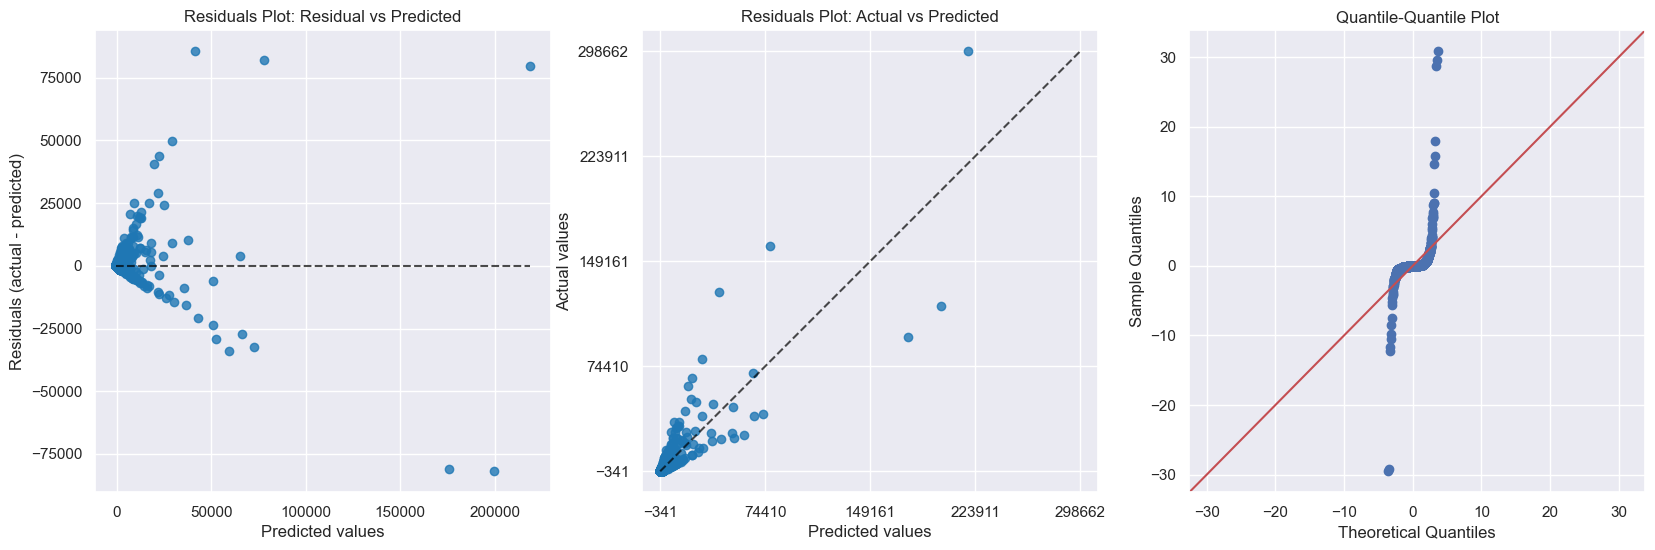

In [86]:
visualize_results(unscaled_ytest, unscaled_y_pred, unscaled_model_residuals)

In [87]:
homoscedasticity_test(unscaled_train, "Financial_Returns")

C:\Users\Unknown\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3189: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


Remote_Bank_Connection     False
Household_Owns_Stocks      False
Financial_Returns          False
Total_Assets               False
High_Risk_Rule_Violated    False
Has_Employment             False
Med_to_Low_Income          False
Is_Financially_Literate    False
dtype: bool

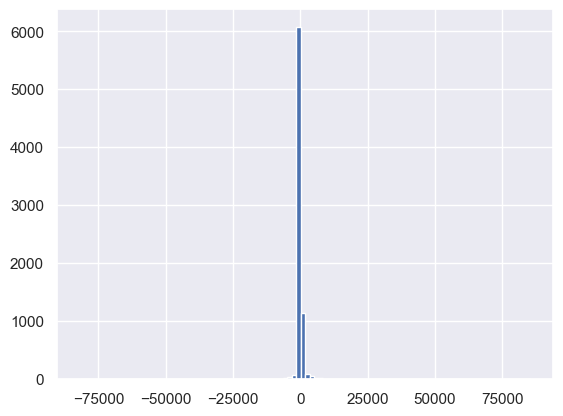

In [88]:
# Show histogram of residuals to determine whether we have normal errors
unscaled_model_residuals.hist(bins=100);

In [89]:
# Kolmogorov–Smirnov test on residuals
kstest(unscaled_model_residuals, "norm")

KstestResult(statistic=0.5710339901623871, pvalue=0.0, statistic_location=-3.131610147331312, statistic_sign=1)

Boy oh boy. This is *bad*. Let's see exactly how bad it is.

First the few good news. The r2 is decent. 0.79 is not at all bad for economics. The Durbin_Watson test's value is 1.999, i.e. very close to 2, indicating that our data does not exhibit autocorrelation. But that's as far are good things go.

We can very clearly see in the ```statsmodels``` results page that both the Omnibus and the Jarque-Bera tests report
massive numbers, indicating the nonnormality of the residuals, which is also supported by the graphs and the Kolmogorov–Smirnov test. 

The condition number is also huge, although this could be because of scaling issues instead of multicollinearity since we have already tested our data with a VIF test and there were no issues. 

The residuals are heteroscedastic, as proven both by the residual graphs and my custom function test. That indicates that our p-values are possibly [deflated](https://statisticsbyjim.com/regression/heteroscedasticity-regression/), which means that our model has variables that could be irrelevant to our dependent variable, and our coefficients are not as precise as they should be.

Prediction-wise, our MAE is ~539, which is better than our dummy baseline, but still awful. The MAPE, however, is a staggering 1244%, when [anything above 50%](https://stephenallwright.com/interpret-mape/) (that limit could actually be lower or higher, depending on the field) is a no-go. 

So to recap, we violate two assumptions of Linear Regression, that of homoscedastic errors and normality of residuals, and our predictions are horrible. Any further interpretation, including that of coefficients, is meaningless. The model is DED.

Let's see if Elastic Net Regression fares any better.

### Elastic Net Regression

According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), Elastic Net is the middle way between Lasso and Ridge regressions, combining L1 and L2 penalties.

In my mind, we move from statistics to machine learning when we start to use functions to calculate hyperparameters for models instead of just switching to another model. The Elastic Net regressor has such a function dedicated to it, though it is far less computationally demanding than the equivalent search functions of the other ```scikit-learn``` algorithms. The function calculates the appropriate alpha and lambda hyperparameters ([the "l1_ratio" sets the alpha hyperparameter and "alpha" sets the lambda parameter](https://machinelearningmastery.com/elastic-net-regression-in-python/)). 

Despite all of the above, it would be a mistake to expect significantly better results than what we had with Simple Linear Regression. Elastic Net is, after all, just a more refined version of the latter.

In [90]:
# Cross validate best parameters of elastic net for our data
elastic_cross_validation = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
elastic_model_cv = ElasticNetCV(cv=elastic_cross_validation)

elastic_model_cv.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

ElasticNetCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=42))

In [91]:
# Show best parameters
print("alpha: %f" % elastic_model_cv.alpha_)
print("l1_ratio_: %f" % elastic_model_cv.l1_ratio_)

alpha: 8252850.668430
l1_ratio_: 0.500000


In [92]:
# Define model with the best parameters, fit model and calculate predictions and residuals 
ela_net_reg = ElasticNet(alpha=elastic_model_cv.alpha_, l1_ratio=elastic_model_cv.l1_ratio_)
elastic_model_unscaled = ela_net_reg.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
elastic_ypred = elastic_model_unscaled.predict(all_vars_unscaled_Xtest)
elastic_residuals = (all_vars_unscaled_ytest - elastic_ypred)

# Define score, intercept and coefficients
unscaled_elastic_model_score = round(elastic_model_unscaled.score(all_vars_unscaled_Xtrain, 
                                                                  all_vars_unscaled_ytrain), 3)
unscaled_elastic_model_intercept = round(elastic_model_unscaled.intercept_.item(), 4)
unscaled_elastic_model_coefficients = pd.DataFrame(zip(all_vars_unscaled_Xtrain.columns, 
                                                       elastic_model_unscaled.coef_))
# Show score, intercept and coefficients
print(f"The model's R2 score is {unscaled_elastic_model_score} with an intercept of \
{unscaled_elastic_model_intercept}. \nThe coefficients of the independent variables are: \
{unscaled_elastic_model_coefficients}.")

The model's R2 score is 0.795 with an intercept of 202.7933. 
The coefficients of the independent variables are:                           0         1
0                 Is_Female -0.000000
1    Remote_Bank_Connection  0.000000
2     Household_Owns_Stocks  0.000000
3               Born_Abroad -0.000000
4              Total_Assets  0.009894
5   High_Risk_Rule_Violated  0.000000
6            Is_Risk_Averse -0.000000
7              Age_under_40 -0.000000
8            Has_Employment -0.000000
9         Med_to_Low_Income -0.000000
10  Is_Financially_Literate  0.000000.


In [93]:
cross_validate(elastic_model_unscaled, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, cv=5)

{'fit_time': array([0.03019285, 0.03008437, 0.02550292, 0.03080535, 0.03205466]),
 'score_time': array([0.00966144, 0.00501633, 0.00961614, 0.        , 0.0080936 ]),
 'test_score': array([0.82714287, 0.6038137 , 0.4355098 , 0.64847159, 0.58569877])}

In [94]:
unscaled_elastic_model_scores = model_score(elastic_model_unscaled, all_vars_unscaled_Xtrain, 
                                            all_vars_unscaled_ytrain, all_vars_unscaled_ytest, 
                                            elastic_ypred, round_int=3)
unscaled_elastic_model_scores.rename({"Score Values": "Unscaled Elastic Model Scores"}, axis=1, inplace=True)
unscaled_elastic_model_scores

Unscaled Elastic Model Scores
Mean Absolute Error                                556.186
Max Error                                        86009.201
MAPE                                              1835.619
Mean R2 Score after 5 CV                             0.620
R2 Score Standard Deviation                          0.126
Root Mean Squared Error                           2751.751
Mean Squared Error                             7572132.809

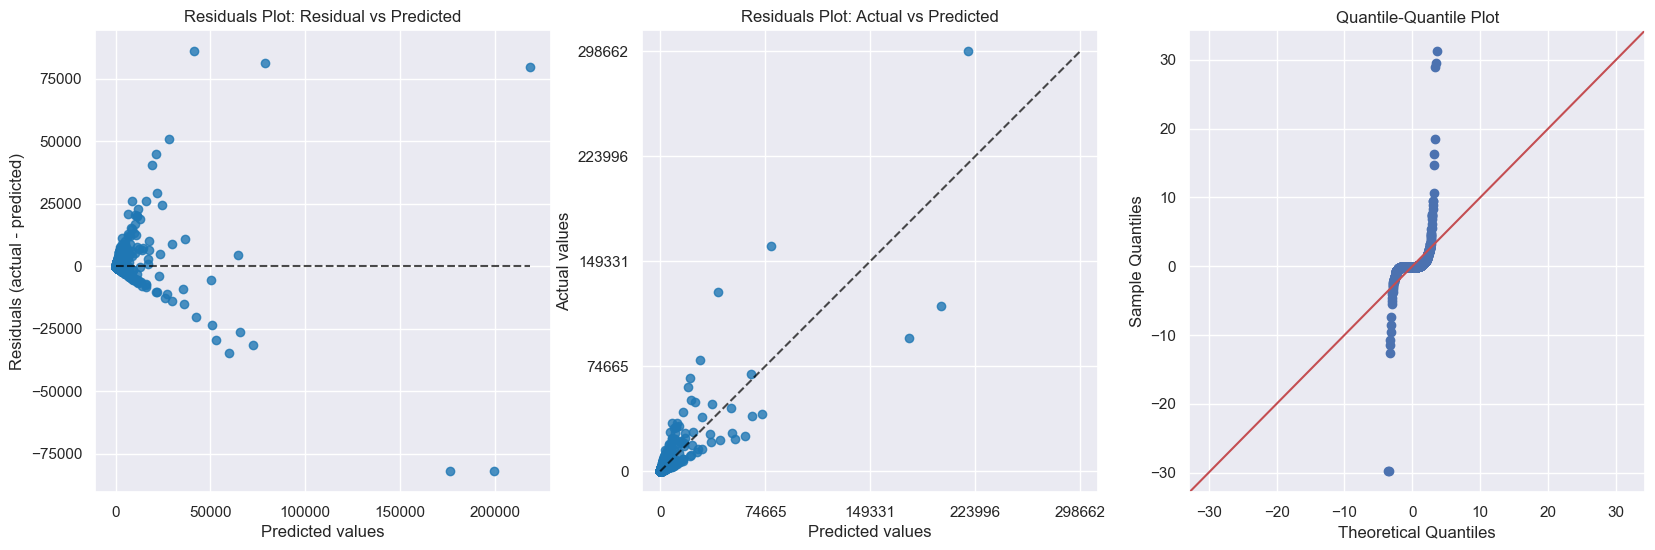

In [95]:
visualize_results(all_vars_unscaled_ytest, elastic_ypred, elastic_residuals)

In [96]:
# Kolmogorov–Smirnov test on residuals
kstest(elastic_residuals, "norm")

KstestResult(statistic=0.8012747339161655, pvalue=0.0, statistic_location=-3.8643191109723034, statistic_sign=1)

The results seem to be slightly worse than the previous model. 

A very interesting note is that the Elastic Net Regressor penalized *heavily* all variables except "Total_Assets", to the point where their coefficients are practically zero. That could be interpreted as that the effect size of "Total_Assets" is so massive that the rest are not even considered. Considering the overall picture, however, I would not trust anything I see here. 

### Weighted Linear Regression

At this point, and after seeing the terrible performance of our previous linear models, we may try one of the remedies for heteroscedastic errors: Weighted Linear Regression. As previously stated, we will not use the variable "Survey_Weights", but instead I calculate my own weights. You can check [Chapter 4 functions](#chapter_4_functions) for more information on the methodology of weight selection. Now, I will perform backward elimination again, this time with the weighted variables:

In [97]:
weighted_linear_regression(unscaled_train, "Financial_Returns")

                            WLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.653
Model:                            WLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     7612.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:06   Log-Likelihood:            -1.9879e+05
No. Observations:               28383   AIC:                         3.976e+05
Df Residuals:                   28375   BIC:                         3.977e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Weighted Regression very clearly shows us that our simple linear regression p-values were deflated and that, in reality, the two variables that describe whether the investor is employed and the size of their income are statistically insignificant.

In [98]:
# Copy so we can drop more variables
unscaled_train_weighted = unscaled_train.copy()
unscaled_test_weighted = unscaled_test.copy()

In [99]:
drop_variable(unscaled_train_weighted, unscaled_test_weighted, "Has_Employment")

In [100]:
weighted_linear_regression(unscaled_train_weighted, "Financial_Returns")

                            WLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.651
Model:                            WLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     8443.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:06   Log-Likelihood:            -1.9141e+05
No. Observations:               27159   AIC:                         3.828e+05
Df Residuals:                   27152   BIC:                         3.829e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [101]:
drop_variable(unscaled_train_weighted, unscaled_test_weighted, "Med_to_Low_Income")

In [102]:
weighted_linear_regression(unscaled_train_weighted, "Financial_Returns")

                            WLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.646
Model:                            WLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     9544.
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:07   Log-Likelihood:            -1.8552e+05
No. Observations:               26129   AIC:                         3.711e+05
Df Residuals:                   26123   BIC:                         3.711e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [103]:
# Separate X,y again with fewer variables
unscaled_ytrain_weighted = unscaled_train_weighted["Financial_Returns"]
unscaled_Xtrain_weighted = unscaled_train_weighted.drop(["Financial_Returns"], axis=1) 
unscaled_ytest_weighted = unscaled_test_weighted["Financial_Returns"]
unscaled_Xtest_weighted = unscaled_test_weighted.drop(["Financial_Returns"], axis=1)

In [104]:
weights = calculate_ln_weights(unscaled_train_weighted, "Financial_Returns")

In [105]:
# Define and fit model, calculate predictions and residuals
lin_model_weighted = lin_regr.fit(unscaled_Xtrain_weighted, unscaled_ytrain_weighted, sample_weight=weights)
unscaled_y_pred_weighted = lin_model_weighted.predict(unscaled_Xtest_weighted)
unscaled_model_residuals_weighted = (unscaled_ytest_weighted - unscaled_y_pred_weighted)

# Define model score, intercept and coefficients
weighted_model_score = round(lin_model_weighted.score(unscaled_Xtrain_weighted, unscaled_ytrain_weighted, 
                                                      sample_weight=weights), 3)
weighted_model_intercept = round(lin_model_weighted.intercept_.item(), 3)
weighted_model_coefficients = pd.DataFrame(zip(unscaled_Xtrain_weighted.columns, lin_model_weighted.coef_))

# Show model score, intercept and coefficients
print(f"The model's R2 score is {weighted_model_score} with an intercept of \
{weighted_model_intercept}. \nThe coefficients of the independent variables are: {weighted_model_coefficients}.")

The model's R2 score is 0.646 with an intercept of -16.493. 
The coefficients of the independent variables are:                          0           1
0   Remote_Bank_Connection  -40.968439
1    Household_Owns_Stocks  164.661514
2             Total_Assets    0.013431
3  High_Risk_Rule_Violated  212.138952
4  Is_Financially_Literate   52.759669.


In [106]:
cross_validate(lin_regr, unscaled_Xtrain_weighted, unscaled_ytrain_weighted, fit_params={"sample_weight": weights}, cv=5)

{'fit_time': array([0.02204156, 0.01999712, 0.0141778 , 0.01599908, 0.01671338]),
 'score_time': array([0.00399899, 0.00400186, 0.00799966, 0.00399947, 0.00803137]),
 'test_score': array([ 0.96605984,  0.53142392, -0.09089408,  0.68784775,  0.24292474])}

https://github.com/scikit-learn/scikit-learn/issues/4632 Weights not included in calculation of cross val (yet)

In [107]:
weighted_unscaled_model_scores = model_score(lin_regr, unscaled_Xtrain_weighted, 
                                             unscaled_ytrain_weighted, unscaled_ytest_weighted, 
                                             unscaled_y_pred_weighted, round_int=2)
weighted_unscaled_model_scores.rename({"Score Values": "Weighted Unscaled Model Scores"}, axis=1, inplace=True)
weighted_unscaled_model_scores

Weighted Unscaled Model Scores
Mean Absolute Error                                  518.34
Max Error                                         153467.56
MAPE                                                 282.44
Mean R2 Score after 5 CV                               0.62
R2 Score Standard Deviation                            0.14
Root Mean Squared Error                             3491.71
Mean Squared Error                              12192070.76

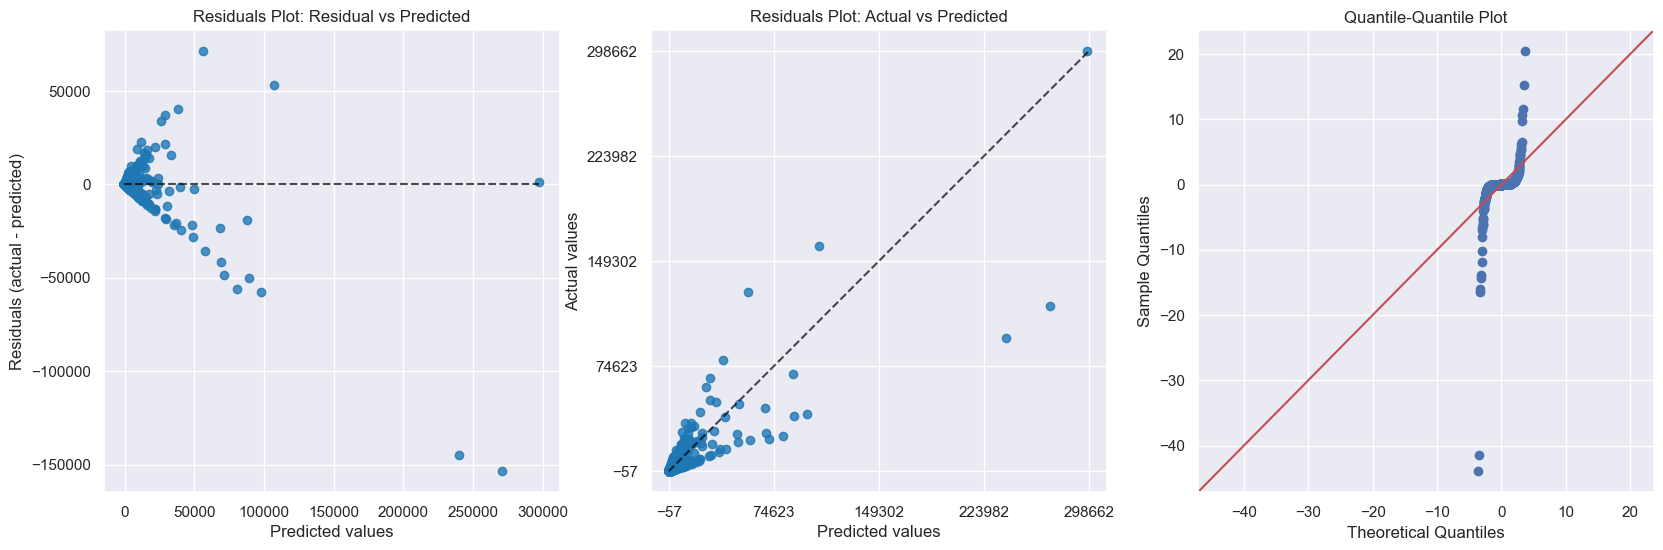

In [108]:
visualize_results(unscaled_ytest_weighted, unscaled_y_pred_weighted, unscaled_model_residuals_weighted)

<AxesSubplot: >

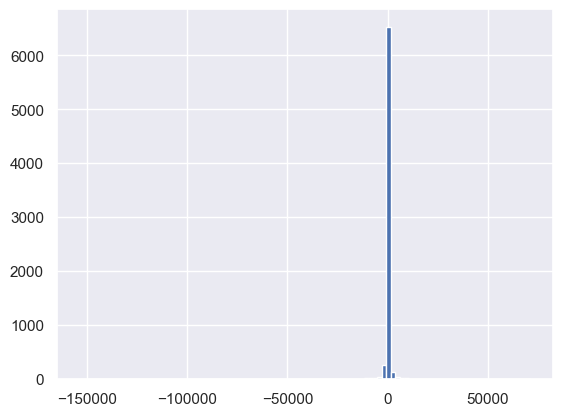

In [109]:
unscaled_model_residuals_weighted.hist(bins=100)

In [110]:
kstest(unscaled_model_residuals_weighted, "norm")

KstestResult(statistic=0.5777947404930599, pvalue=0.0, statistic_location=-2.777791881165328, statistic_sign=1)

What weighted regression has actually done is show us that our previous models were even worse than we thought. The R2 dropped from 0.79 to 0.64, indicating that the Simple Linear Regression model and the Elastic Net model were both overfit.

The AIC and BIC are better than in the Simple Linear Regression model, but the errors continue to be non-normal and heteroscedastic, despite the fact that this was the reason we applied weights in the first place.

Our predictions continue to be off, however, the MAPE has dropped to 282%. Still horrible, but just a bit better. Since fixing the model didn't seem to solve our issues, one might consider scaling the data instead.

## 4.3 Dealing with (and Rejecting) Scaling and/or Centering Data
<a id="chapter_4.3"></a>

Another attempt to improve our linear regression results would be to scale or center our data. In Linear Regression, scaling the variables does not improve model accuracy. What is worse, it complicates coefficient interpretation. Centering the data, however, is [sometimes preferred](https://statisticsbyjim.com/regression/standardize-variables-regression/) for better interpretation of the intercept in the real world.

The idea is that when data are centered, the coefficient shows us the y value when all x are at their means. If the data is uncentered, what it shows us is the y value when each x is at 0, which might not make any sense for many predictor variables (e.g. weight).

In ```scikit-learn```, we have many options to scale and center our data, out of which the following three are going to be considered here: ```MinMaxScaler```, ```StandardScaler``` and ```RobustScaler```. Because our data is rightly skewed, ```StandardScaler```, which subtracts the mean, would be severely impacted.  Additionally, because our dependent variable has massive outliers, both ```MinMaxScaler``` and ```StandardScaler``` would be inaccurate (especially ```MinMaxScaler```). Hence, our best option would probably be ```RobustScaler```, which uses the median instead of the mean in its calculations and the IQR instead of the standard deviation.

For the tests that follow, I will ignore the p-values altogether and focus only on the rest of the information that the ```statsmodels``` results object returns:

In [111]:
# Create min_max scaler
minmax_encoding = make_column_transformer((MinMaxScaler(),
                                           ["Is_Female", "Remote_Bank_Connection", "Household_Owns_Stocks",
                                            "Born_Abroad", "Financial_Returns", "Total_Assets",
                                            "High_Risk_Rule_Violated", "Is_Risk_Averse", "Age_under_40",
                                            "Has_Employment", "Med_to_Low_Income", "Is_Financially_Literate"]), 
                                           remainder="passthrough", verbose_feature_names_out=False)

# Fit and scale train
minmax_encoded_train = minmax_encoding.fit_transform(all_vars_unscaled_train)
mm_train = pd.DataFrame(minmax_encoded_train, columns=minmax_encoding.get_feature_names_out())

In [112]:
# Create standard scaler
standard_encoding = make_column_transformer((StandardScaler(),
                                             ["Is_Female", "Remote_Bank_Connection", "Household_Owns_Stocks",
                                              "Born_Abroad", "Financial_Returns", "Total_Assets",
                                              "High_Risk_Rule_Violated", "Is_Risk_Averse", "Age_under_40",
                                              "Has_Employment", "Med_to_Low_Income", "Is_Financially_Literate"]), 
                                             remainder="passthrough", verbose_feature_names_out=False)

# Fit and scale train
standard_trained = standard_encoding.fit_transform(all_vars_unscaled_train)
standard_train = pd.DataFrame(standard_trained, columns=standard_encoding.get_feature_names_out())

In [113]:
# Create robust scaler
robust_encoding = make_column_transformer((RobustScaler(),
                                           ["Is_Female", "Remote_Bank_Connection", "Household_Owns_Stocks",
                                            "Born_Abroad", "Financial_Returns", "Total_Assets",
                                            "High_Risk_Rule_Violated", "Is_Risk_Averse", "Age_under_40",
                                            "Has_Employment", "Med_to_Low_Income", "Is_Financially_Literate"]), 
                                           remainder="passthrough", verbose_feature_names_out=False)
# Fit and scale train
robust_train = robust_encoding.fit_transform(all_vars_unscaled_train)
robust_train = pd.DataFrame(robust_train, columns=robust_encoding.get_feature_names_out())

In [114]:
linear_regression(standard_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:15   Log-Likelihood:                -19416.
No. Observations:               31265   AIC:                         3.886e+04
Df Residuals:                   31253   BIC:                         3.896e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                4

We can see that, compared to the vanilla version, the Cond. No. in our model with standardized data improved markedly, thus confirming my assumption that the original problem was scaling and not multicollinearity. On the other hand, the AIC, BIC, and F-statistic have only slightly improved, while the Omnibus and Jarque Bera tests and the overall R-squared score have not changed at all from our original model.  

There is a debate when it comes to standardized coefficients and effect sizes. In general, it is assumed that, if standardized, the coefficients of the regression are unitless, and can therefore be compared with each other in order to find the [one which has the biggest effect](https://statisticsbyjim.com/basics/effect-sizes-statistics/) on our target variable. 

According to this interpretation of standardized coefficients, it would seem that, in our case, by far the most important variable is "Total_Assets", accounting for almost 89% of the effect our independent variables have on the dependent variable, a value which would is close to what the correlation matrix showed us previously. 

However, there is also the issue of possible confounding variables, which is why some analysts discard this use of standardized coefficients. Moreover, we already know that in our case the mean would be impacted by the massive outliers, so I am unsure if we can fully trust the standardized coefficients.

In [115]:
linear_regression(mm_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:15   Log-Likelihood:             1.3263e+05
No. Observations:               31265   AIC:                        -2.652e+05
Df Residuals:                   31253   BIC:                        -2.651e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The AIC and BIC show us that the model trained on data scaled with min/max scaling supposedly retains much more information than our other models. Again, we can see that Cond.No. has improved compared to the model with unscaled values.

On the other hand, the overall R score, the F statistic, the Jarque Bera, and the Omnibus tests remain unchanged. The intercepts have been completely transformed, so if we had to get the intercepts in normal y units, we would have to inverse-transform them.

It seems quite unnecessary, though, since our overall model accuracy has not improved at all compared to the model with the original values.

In [116]:
linear_regression(robust_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:16   Log-Likelihood:            -1.0462e+05
No. Observations:               31265   AIC:                         2.093e+05
Df Residuals:                   31253   BIC:                         2.094e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

We can see that it was the RobustScaler that had the lowest absolute values in both AIC and BIC, thus leading us to assume that this would be the best choice for scaling. But this type of scaling would again complicate the interpretation of coefficients in linear regression, without actually improving model accuracy at all.

We might instead be tempted to center the data in order to better explain the coefficient. Centering the data around 0 would mean that our strictly positive original "Financial_Returns" and "Total_Assets" variables would acquire negative values, while the original variance and distribution would be retained. It is debatable if it in any way helps our interpretation, as seen below:

In [117]:
# Create robust scaler which only centers data
centering_encoding = make_column_transformer((RobustScaler(with_scaling=False), # Centering only does not affect interpetation
                                              ["Is_Female", "Remote_Bank_Connection", "Household_Owns_Stocks",
                                               "Born_Abroad", "Financial_Returns", "Total_Assets",
                                               "High_Risk_Rule_Violated", "Is_Risk_Averse", "Age_under_40",
                                               "Has_Employment", "Med_to_Low_Income", "Is_Financially_Literate"]), 
                                              remainder="passthrough", verbose_feature_names_out=False)

# Fit and center train
centering_train = centering_encoding.fit_transform(all_vars_unscaled_train)
centered_train = pd.DataFrame(centering_train, columns=centering_encoding.get_feature_names_out())

In [118]:
linear_regression(centered_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:21:16   Log-Likelihood:            -2.9698e+05
No. Observations:               31265   AIC:                         5.940e+05
Df Residuals:                   31253   BIC:                         5.941e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

We have the exact same model as we did with our previous attempt with unscaled and uncentered original data, except for one big differce: our Intercept is now ~31. What would translate into in the case of our "Total_Assets" variable would be that investors who possess "Total_Assets" equal to the median values of our observations have a median of 31 euros returned from their investments. However, the p-value is far above the threshold, and even though p-values are usually ignored for intercepts, I am unsure if we can also ignore it in this case as well, or treat it as an indicator that the value might be misleading.

It would seem that, for our dataset, centering only tempts us to possibly incorrectly interpret our intercept while it doesn't really fix any of the more serious problems the model has. It would not really matter that much if I had only non linear algorithms to work with, since in their case the only thing that matters is prediction accuracy and there are no coefficients to interpret whatsoever. We would just train the models with the scaled data and then back-tranform the predictions using the ```inverse_tranform``` method of each scaler. 

But since we want to compare a linear regression model with non-linear algorithms, I will avoid performing any kind of scaling of the data at this point, so that we can interpret the results of non-linear models on the same terms as those of linear models. There is an entire chapter dedicated to a more meaningfull and effective transformation later. 

Either way, we can see that, even with scaling, our linear models suffer. Next, we will move on to non-linear algorithms. Originally, GLM models were included in this project, but they were removed since their results were unsatisfying. Instead, I decided to go straight into two ```scikit-learn``` algorithms and test them against the results of the linear models. 

# 4.4 Non- Linear Regression
<a id="chapter_4.4"></a>

Now moving fully into machine learning, you should be aware that the calculations will take **significantly** more time to complete. Some of the following cells, especially the ones testing hyperparameters, may take from 1 to 20 minutes to run depending on the operating system.

What we should also note is that non-linear regression algorithms have much less informative results. With no coefficients to interpret, our focus shifts to prediction. In that sense, the only way we can evaluate our results is by using the custom helper function to calculate the different types of errors.

For both non-linear algorithms, I first apply a default model, followed by hyperparameter tuning and reapplication of the model with the best hyperparameters.

## Random Forest

### Random Forest with Default Parameters

In [119]:
# Define default random forest, fit and calculate predictions and residuals
fo_regr = RandomForestRegressor(random_state=42) 
default_forest = fo_regr.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
default_forest_y_pred = default_forest.predict(all_vars_unscaled_Xtest)
default_forest_residuals = (all_vars_unscaled_ytest - default_forest_y_pred)

In [120]:
# Cv of R2 score
cross_validate(fo_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, cv=5)

{'fit_time': array([32.4203279 , 32.9386003 , 33.259835  , 32.76080155, 32.90093732]),
 'score_time': array([0.47376966, 0.48038101, 0.47930908, 0.55681801, 0.53493738]),
 'test_score': array([0.49370361, 0.57602965, 0.61324402, 0.5317029 , 0.40845385])}

In [121]:
default_forest_model_scores = model_score(fo_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, 
                                          all_vars_unscaled_ytest, default_forest_y_pred)
default_forest_model_scores.rename({"Score Values": "Default Forest Model Scores"}, axis=1, inplace=True)
default_forest_model_scores

Default Forest Model Scores
Mean Absolute Error                              435.463
Max Error                                     115585.323
MAPE                                              60.524
Mean R2 Score after 5 CV                           0.525
R2 Score Standard Deviation                        0.071
Root Mean Squared Error                         2800.842
Mean Squared Error                           7844714.657

As one would expect from a machine learning model much more advanced than linear regression, the results are better, but still far off anything that could be considered useful. The MAE is still awful and the MAPE is about 60%. Considering that the main purpose of Random Forests is to predict (but not extrapolate), we can rest assured this is a completely useless model. 

This is the point where machine learning differs, though. Instead of simply abandoning the model, we can start tuning its hyperparameters (i.e. the parameters that the model cannot learn itself) to achieve a better result.

### Forest Hyperparameter Tuning

The two relevant ```sickit-learn``` functions for hyperparameter tuning are ```RandomizedSearchCV``` and ```GridSearchCV```.

```RandomizedSearchCV``` tests random combinations of parameter distributions for a number of iterations that we set, while ```GridSearchCV``` tests all the combinations of all the specified parameters. Naturally, the latter takes a long time to complete.

What I do for this project is a combination of the two: first I use randomized searches to narrow down the potential grid search hyperparameter candidates (and possibly find a pattern of how the hyperparameters react and which ones affect the result the most), and then a grid search of fewer parameters to decide the final ones. This methodology is based on [this post](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/).

Note that I follow a similar procedure with GBR, but I noticed that the GBR parameters are coupled, so the original randomized search has more combinations. If we wanted, we could increase the iterations of ```RandomizedSearchCV``` to produce even better results, or we could just add all parameters to ```GridSearchCV``` and leave for a two-week vacation, leaving the computer to do the job (and pray nothing goes wrong).

In [122]:
# Get regressor parameters
fo_regr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [123]:
# First dict of hyperparameters
random_forest_param_distributions_1rst_iter = {"max_features": [1, 2, 3, 5, None],
                                               "max_leaf_nodes": [10, 100, 1000, None],
                                               "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100]}

In [124]:
# Randomly search hyperparameter combinations
randomized_forest_search = RandomizedSearchCV(fo_regr,
                                              param_distributions=random_forest_param_distributions_1rst_iter, 
                                              n_jobs=-1, random_state=42, 
                                              scoring=["neg_mean_absolute_error", "r2"], 
                                              refit="neg_mean_absolute_error")

randomized_forest_search.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_features': [1, 2, 3, 5, None],
                                        'max_leaf_nodes': [10, 100, 1000, None],
                                        'min_samples_leaf': [1, 2, 5, 10, 20,
                                                             50, 100]},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'])

**You can find all the custom functions used in this chapter in [Chapter 4 functions](#chapter_4_functions).**

In [125]:
show_param_cv_results(random_forest_param_distributions_1rst_iter , randomized_forest_search)

param_max_features param_max_leaf_nodes param_min_samples_leaf  R2 Score  \
0                  5                 None                     10  0.596146   
3               None                  100                      1  0.531628   
9                  5                 None                     20  0.495196   
6                  3                 None                     20  0.477545   
4                  2                 1000                      1  0.493571   
8                  5                 1000                    100  0.309910   
1                  3                  100                     20  0.477181   
7                  3                  100                    100  0.279509   
5                  1                  100                     50  0.280570   
2                  2                   10                     10  0.491881   

   R2 Standard Deviation  Mean Absolute Error  \
0               0.162356           421.605922   
3               0.075973           432.561194   
9               0.170520           443.694579   
6               0.182815           476.218186   
4               0.098578           483.510913   
8               0.139149           486.015386   
1               0.187653           498.737638   
7               0.136981           545.103803   
5               0.140194           603.482773   
2               0.166270           704.353486   

   Absolute Error Standard Deviation  
0                          45.297828  
3                          42.263505  
9                          48.212180  
6                          49.481662  
4                          49.272978  
8                          46.575615  
1                          50.402732  
7                          51.196152  
5                          57.215682  
2                          53.811784

Next we focus on the two most computationally intestive hyperparameters: ```n_estimators``` (i.e. number of trees) and ```min_samples_split```: 

In [126]:
# Second dict of hyperparameters
random_forest_param_distributions_2nd_iter = {"max_features": [5],
                                              "max_leaf_nodes": [None],
                                              "min_samples_leaf": [10, 1],
                                              "min_samples_split": [2, 250, 500, 750, 1000]}

In [127]:
randomized_forest_search_2nd_iter = RandomizedSearchCV(fo_regr,
                                                       param_distributions=random_forest_param_distributions_2nd_iter, 
                                                       n_jobs=-1, random_state=42, 
                                                       scoring=["neg_mean_absolute_error", "r2"], 
                                                       refit="neg_mean_absolute_error")

randomized_forest_search_2nd_iter.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_features': [5],
                                        'max_leaf_nodes': [None],
                                        'min_samples_leaf': [10, 1],
                                        'min_samples_split': [2, 250, 500, 750,
                                                              1000]},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'])

In [128]:
show_param_cv_results(random_forest_param_distributions_2nd_iter, randomized_forest_search_2nd_iter)

param_max_features param_max_leaf_nodes param_min_samples_leaf  \
0                  5                 None                     10   
5                  5                 None                      1   
6                  5                 None                      1   
1                  5                 None                     10   
7                  5                 None                      1   
2                  5                 None                     10   
3                  5                 None                     10   
8                  5                 None                      1   
4                  5                 None                     10   
9                  5                 None                      1   

  param_min_samples_split  R2 Score  R2 Standard Deviation  \
0                       2  0.596146               0.162356   
5                       2  0.534067               0.077910   
6                     250  0.537232               0.104378   
1                     250  0.582539               0.166825   
7                     500  0.523604               0.112344   
2                     500  0.571449               0.175224   
3                     750  0.551996               0.175954   
8                     750  0.509243               0.128060   
4                    1000  0.548609               0.173441   
9                    1000  0.488316               0.111456   

   Mean Absolute Error  Absolute Error Standard Deviation  
0           421.605922                          45.297828  
5           429.761767                          44.067335  
6           450.526948                          47.203410  
1           450.654837                          47.041625  
7           476.480606                          45.955590  
2           479.981335                          47.751501  
3           499.644338                          49.543636  
8           506.373183                          45.592170  
4           515.311630                          48.304332  
9           525.185024                          42.942675

In [129]:
# Dict for grid search of hyperparameters
random_forest_param_grid = {"max_features": [5], 
                            "max_leaf_nodes": [None],
                            "min_samples_leaf": [10],
                            "min_samples_split": [2],
                            "n_estimators": [50, 100, 500, 1000]}

In [130]:
# Search all combinations of given hyperparameters
grid_forest_search = GridSearchCV(fo_regr, param_grid=random_forest_param_grid, 
                                  n_jobs=-1, scoring=["neg_mean_absolute_error", "r2"], 
                                  refit="neg_mean_absolute_error")

grid_forest_search.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [5], 'max_leaf_nodes': [None],
                         'min_samples_leaf': [10], 'min_samples_split': [2],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [131]:
show_param_cv_results(random_forest_param_grid, grid_forest_search)

param_max_features param_max_leaf_nodes param_min_samples_leaf  \
1                  5                 None                     10   
3                  5                 None                     10   
2                  5                 None                     10   
0                  5                 None                     10   

  param_min_samples_split param_n_estimators  R2 Score  R2 Standard Deviation  \
1                       2                100  0.596146               0.162356   
3                       2               1000  0.586713               0.154953   
2                       2                500  0.585602               0.156342   
0                       2                 50  0.590391               0.158126   

   Mean Absolute Error  Absolute Error Standard Deviation  
1           421.605922                          45.297828  
3           422.301711                          45.969048  
2           422.874990                          46.107147  
0           423.267391                          43.830730

In [132]:
forest_best_params = grid_forest_search.best_params_

### Random Forest with Best Hyperparameters Fit and Evaluation

In [133]:
# Fit with best hyperparameters
fo_regr_best = RandomForestRegressor(**forest_best_params, random_state=42)
normal_random_forest = fo_regr_best.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
normal_forest_y_pred = normal_random_forest.predict(all_vars_unscaled_Xtest)
normal_forest_residuals = (all_vars_unscaled_ytest - normal_forest_y_pred)

In [134]:
# CV of R2 score
cross_validate(fo_regr_best, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, cv=5)

{'fit_time': array([7.96626949, 8.39745688, 7.92632079, 8.44138503, 7.86325407]),
 'score_time': array([0.24167061, 0.24367261, 0.25344992, 0.24973416, 0.24570894]),
 'test_score': array([0.27978622, 0.68595374, 0.68821098, 0.71874778, 0.60803339])}

In [135]:
forest_model_scores = model_score(fo_regr_best, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, 
                                  all_vars_unscaled_ytest, normal_forest_y_pred)
forest_model_scores.rename({"Score Values": "Forest Model Scores"}, axis=1, inplace=True)
forest_model_scores

Forest Model Scores
Mean Absolute Error                      426.040
Max Error                             157525.861
MAPE                                     124.719
Mean R2 Score after 5 CV                   0.596
R2 Score Standard Deviation                0.162
Root Mean Squared Error                 3076.956
Mean Squared Error                   9467661.109

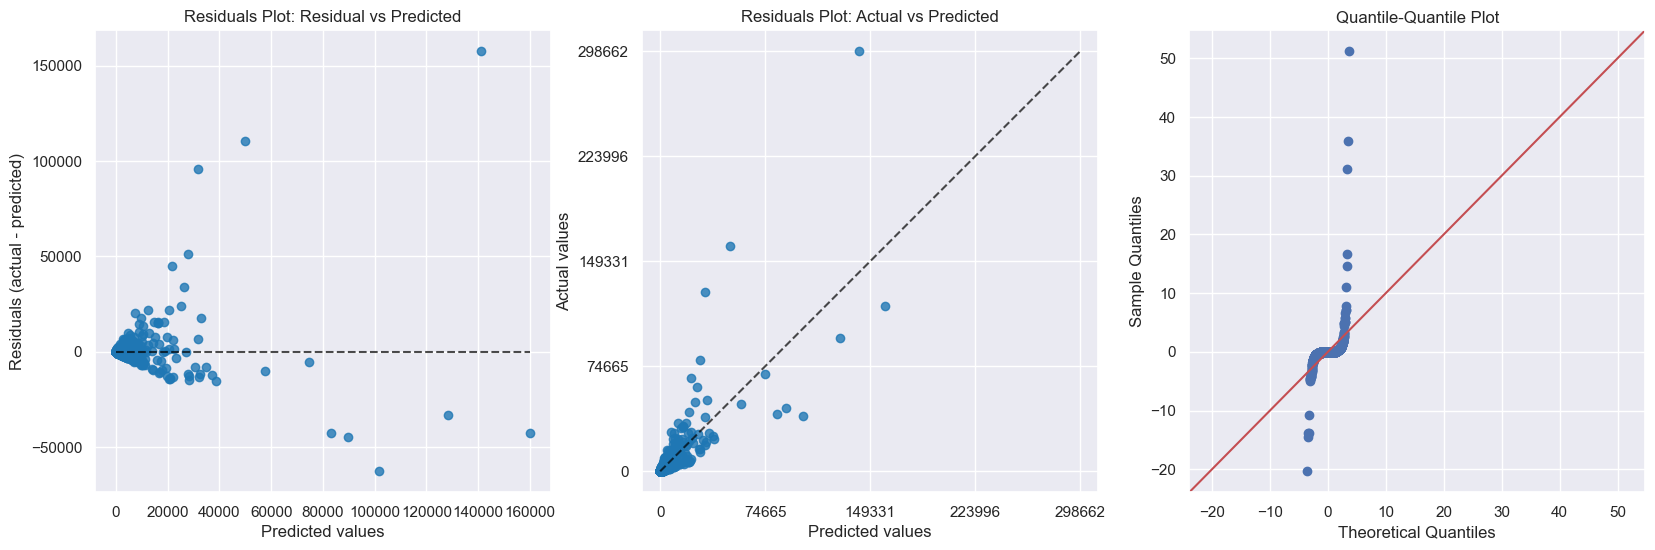

In [136]:
visualize_results(all_vars_unscaled_ytest, normal_forest_y_pred, normal_forest_residuals)

In [137]:
# Show which features were used the most in generation of trees
normal_forest_feature_importances = pd.DataFrame(zip(fo_regr_best.feature_names_in_, 
                                                     fo_regr_best.feature_importances_), 
                                                 columns=["Features", "Importance"]).round(4)
normal_forest_feature_importances

Features  Importance
0                 Is_Female      0.0012
1    Remote_Bank_Connection      0.0060
2     Household_Owns_Stocks      0.0226
3               Born_Abroad      0.0000
4              Total_Assets      0.9409
5   High_Risk_Rule_Violated      0.0164
6            Is_Risk_Averse      0.0039
7              Age_under_40      0.0004
8            Has_Employment      0.0009
9         Med_to_Low_Income      0.0047
10  Is_Financially_Literate      0.0029

Our hyperparameter tuning produced mixed results. The MAE improved very slightly, as did the R2, but all the other errors worsened. I think it's safe to say we did not make things better and, like a drunk ex at someone's doorstep, it's time for us to move on.

One interesting last thing to note is the variable "Total_Assets" offered 94% of the information the decision trees took into account to make decisions about splitting. The rest of the variables combined offered about 6%. That is consistent with the Principal Component Analysis we performed back in [chapter 3](#chapter_3).  

##  Gradient Boosting Regression

### Default GradientBoostingRegressor

In [138]:
# Define default random forest, fit and calculate predictions and residuals
gbr_reg = GradientBoostingRegressor(random_state=42)
default_gbr_regr = gbr_reg.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
default_gbr_y_pred = default_gbr_regr.predict(all_vars_unscaled_Xtest)
default_gbr_residuals = (all_vars_unscaled_ytest - default_gbr_y_pred)

In [139]:
# CV of r2 score
cross_validate(default_gbr_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, cv=5)

{'fit_time': array([5.69527388, 5.40201807, 5.30961156, 5.65289807, 5.37607312]),
 'score_time': array([0.01993418, 0.01819777, 0.0147934 , 0.01701474, 0.0141747 ]),
 'test_score': array([ 0.59347251,  0.55699486,  0.05471096,  0.65352479, -0.2723105 ])}

In [140]:
default_gbr_model_scores = model_score(default_gbr_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, 
                                       all_vars_unscaled_ytest, default_gbr_y_pred, round_int=2)
default_gbr_model_scores.rename({"Score Values": "Default GBR Model Scores"}, axis=1, inplace=True)
default_gbr_model_scores

Default GBR Model Scores
Mean Absolute Error                            426.63
Max Error                                   127292.73
MAPE                                           672.00
Mean R2 Score after 5 CV                         0.32
R2 Score Standard Deviation                      0.36
Root Mean Squared Error                       2899.90
Mean Squared Error                         8409402.52

### Gradient Boosting Regression Hyperparameter Tuning

[Gradient-boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is more complex, and its most important parameters are ```learning_rate``` and ```n_estimators```. You can find more information about how to tune its hyperparameters on [INRIA's GitHub page](https://github.com/INRIA/scikit-learn-mooc).

One additional note for gradient boosting is the use of early stopping by manipulating the ```n_iter_no_change```, ```tol```, and  ```validation_fraction``` parameters to reduce training time and memory usage. You can read more about it in the [documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html).

In [141]:
gbr_reg.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [142]:
# Dict of hyperparameters for randomized search
gbr_param_distributions = {"learning_rate": [0.05, 0.1, 0.2, 0.3, 0.5],
                           "max_depth": [3, 4, 5, 6, 7, 8],
                           "n_estimators": [50, 100, 150, 200],
                           "max_leaf_nodes": [10, 100, 1000, None],
                           "min_samples_leaf": [1, 10, 20, 50],
                           "n_iter_no_change": [10],   #early stopping
                           "tol": [0.02],
                           "validation_fraction": [0.2]}

In [143]:
# Use random search to find the best hyperparameters, with 15 iterations
gbr_random_search = RandomizedSearchCV(gbr_reg, param_distributions=gbr_param_distributions, 
                                       n_jobs=-1, random_state=42, 
                                       scoring=["neg_mean_absolute_error", "r2"], 
                                       refit="neg_mean_absolute_error", 
                                       n_iter=15)

# Fit the random search object to the data
gbr_random_search.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [10, 100, 1000, None],
                                        'min_samples_leaf': [1, 10, 20, 50],
                                        'n_estimators': [50, 100, 150, 200],
                                        'n_iter_no_change': [10], 'tol': [0.02],
                                        'validation_fraction': [0.2]},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'])

In [144]:
show_param_cv_results(gbr_param_distributions, gbr_random_search)

param_learning_rate param_max_depth param_n_estimators  \
0                  0.2               8                150   
7                  0.2               7                 50   
4                  0.2               8                150   
1                  0.3               7                200   
13                 0.3               8                150   
8                  0.5               4                150   
10                 0.1               4                150   
5                  0.2               8                200   
11                 0.3               4                150   
3                  0.3               5                150   
6                  0.5               5                 50   
2                  0.2               4                 50   
14                0.05               4                200   
12                0.05               8                150   
9                 0.05               4                100   

   param_max_leaf_nodes param_min_samples_leaf param_n_iter_no_change  \
0                  1000                     10                     10   
7                   100                     10                     10   
4                  1000                     20                     10   
1                  None                      1                     10   
13                   10                     20                     10   
8                  1000                     10                     10   
10                  100                      1                     10   
5                    10                     10                     10   
11                  100                     10                     10   
3                    10                     50                     10   
6                  None                     50                     10   
2                   100                     50                     10   
14                  100                     10                     10   
12                   10                     20                     10   
9                  None                     20                     10   

   param_tol param_validation_fraction  R2 Score  R2 Standard Deviation  \
0       0.02                       0.2  0.556929               0.153303   
7       0.02                       0.2  0.553367               0.152744   
4       0.02                       0.2  0.515640               0.179403   
1       0.02                       0.2  0.366347               0.243413   
13      0.02                       0.2  0.524673               0.177151   
8       0.02                       0.2  0.580965               0.144190   
10      0.02                       0.2  0.349864               0.251828   
5       0.02                       0.2  0.570541               0.152831   
11      0.02                       0.2  0.576172               0.141350   
3       0.02                       0.2  0.408577               0.162085   
6       0.02                       0.2  0.411687               0.154624   
2       0.02                       0.2  0.407153               0.164487   
14      0.02                       0.2  0.573755               0.174648   
12      0.02                       0.2  0.516261               0.197258   
9       0.02                       0.2  0.512883               0.194394   

    Mean Absolute Error  Absolute Error Standard Deviation  
0            421.124065                          55.849063  
7            421.220144                          57.446584  
4            422.148036                          62.126105  
1            427.928693                          34.178039  
13           430.002338                          63.163581  
8            434.010399                          50.853648  
10           434.193320                          51.046364  
5            434.951970                          66.492872  
11           438.098271                          49.128226  
3            444.142880                       

In [145]:
# Dict of learning rate, max depth and n_estimators hyperparameters for combination grid search
gbr_grid_params = {"learning_rate": [0.2, 0.1],
                   "max_depth": [6, 7, 8],
                   "n_estimators": [50, 100, 150],
                   "max_leaf_nodes": [1000],
                   "min_samples_leaf": [10],
                   "n_iter_no_change": [10],    #early stopping
                   "tol": [0.02],
                   "validation_fraction": [0.2]}

In [146]:
# Grid search for best combination of hyperparameters
grid_gbr_search = GridSearchCV(gbr_reg, param_grid=gbr_grid_params, 
                               n_jobs=-1, scoring=["neg_mean_absolute_error", "r2"], 
                               refit="neg_mean_absolute_error")

grid_gbr_search.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.1], 'max_depth': [6, 7, 8],
                         'max_leaf_nodes': [1000], 'min_samples_leaf': [10],
                         'n_estimators': [50, 100, 150],
                         'n_iter_no_change': [10], 'tol': [0.02],
                         'validation_fraction': [0.2]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [147]:
show_param_cv_results(gbr_grid_params, grid_gbr_search)

param_learning_rate param_max_depth param_n_estimators  \
6                  0.2               8                 50   
8                  0.2               8                150   
7                  0.2               8                100   
3                  0.2               7                 50   
4                  0.2               7                100   
5                  0.2               7                150   
1                  0.2               6                100   
2                  0.2               6                150   
0                  0.2               6                 50   
16                 0.1               8                100   
17                 0.1               8                150   
13                 0.1               7                100   
14                 0.1               7                150   
15                 0.1               8                 50   
12                 0.1               7                 50   
11                 0.1               6                150   
10                 0.1               6                100   
9                  0.1               6                 50   

   param_max_leaf_nodes param_min_samples_leaf param_n_iter_no_change  \
6                  1000                     10                     10   
8                  1000                     10                     10   
7                  1000                     10                     10   
3                  1000                     10                     10   
4                  1000                     10                     10   
5                  1000                     10                     10   
1                  1000                     10                     10   
2                  1000                     10                     10   
0                  1000                     10                     10   
16                 1000                     10                     10   
17                 1000                     10                     10   
13                 1000                     10                     10   
14                 1000                     10                     10   
15                 1000                     10                     10   
12                 1000                     10                     10   
11                 1000                     10                     10   
10                 1000                     10                     10   
9                  1000                     10                     10   

   param_tol param_validation_fraction  R2 Score  R2 Standard Deviation  \
6       0.02                       0.2  0.554376               0.150260   
8       0.02                       0.2  0.556929               0.153303   
7       0.02                       0.2  0.556929               0.153303   
3       0.02                       0.2  0.553367               0.152744   
4       0.02                       0.2  0.556540               0.156081   
5       0.02                       0.2  0.556540               0.156081   
1       0.02                       0.2  0.556087               0.155504   
2       0.02                       0.2  0.556087               0.155504   
0       0.02                       0.2  0.552979               0.151808   
16      0.02                       0.2  0.545809               0.162972   
17      0.02                       0.2  0.547640               0.165026   
13      0.02                       0.2  0.548239               0.164579   
14      0.02                       0.2  0.550891               0.167599   
15      0.02                       0.2  0.538974               0.155595   
12      0.02                       0.2  0.540378               0.156782   
11      0.02                       0.2  0.552524               0.167719   
10      0.02                       0.2  0.550907               0.165882   
9       0.02                       0.2  0.544564               0.158773   

    Mean Absolute Error  Abso

### Gradient Boosting Regression with Best Hyperparameters Fit and Evaluation

In [148]:
gbr_best_params = grid_gbr_search.best_params_ 

In [149]:
# Fit gbr model with the best hyperparameters, calculate predictions and residuals 
best_gbr_reg = GradientBoostingRegressor(**gbr_best_params, random_state=42)
normal_gbr_regr = best_gbr_reg.fit(all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain)
normal_gbr_y_pred = normal_gbr_regr.predict(all_vars_unscaled_Xtest)
normal_gbr_residuals = (all_vars_unscaled_ytest - normal_gbr_y_pred)

In [150]:
# CV of R2 score
cross_validate(normal_gbr_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, cv=5)

{'fit_time': array([1.33158326, 3.28978753, 5.92778325, 4.16789079, 6.041749  ]),
 'score_time': array([0.01033783, 0.01687646, 0.02050781, 0.01827359, 0.01482677]),
 'test_score': array([0.33357605, 0.69985383, 0.7302272 , 0.56326075, 0.44496313])}

**You can find all the custom functions used in this chapter in [Chapter 4 functions](#chapter_4_functions).**

In [151]:
gbr_model_scores = model_score(normal_gbr_regr, all_vars_unscaled_Xtrain, all_vars_unscaled_ytrain, 
                               all_vars_unscaled_ytest, normal_gbr_y_pred, round_int=2)
gbr_model_scores.rename({"Score Values": "GBR Model Scores"}, axis=1, inplace=True)
gbr_model_scores

GBR Model Scores
Mean Absolute Error                    421.84
Max Error                           146976.21
MAPE                                   217.17
Mean R2 Score after 5 CV                 0.55
R2 Score Standard Deviation              0.15
Root Mean Squared Error               3052.79
Mean Squared Error                 9319551.47

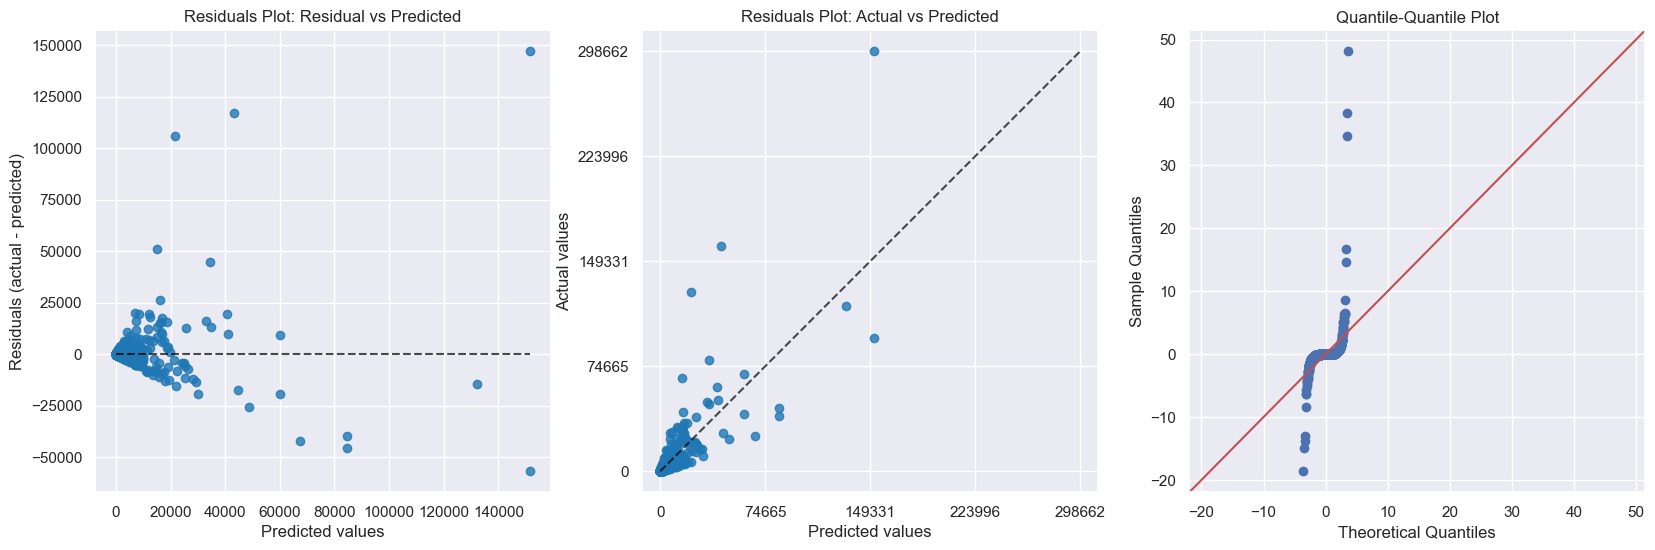

In [152]:
visualize_results(all_vars_unscaled_ytest, normal_gbr_y_pred, normal_gbr_residuals)

In [153]:
# Show which features were used the most in generation of trees
best_gbr_feature_importances = pd.DataFrame(zip(normal_gbr_regr.feature_names_in_, 
                                            normal_gbr_regr.feature_importances_), 
                                            columns=["Features", "Importance"]).round(5)
best_gbr_feature_importances

Features  Importance
0                 Is_Female     0.00092
1    Remote_Bank_Connection     0.00603
2     Household_Owns_Stocks     0.00487
3               Born_Abroad     0.00000
4              Total_Assets     0.96089
5   High_Risk_Rule_Violated     0.00263
6            Is_Risk_Averse     0.01787
7              Age_under_40     0.00047
8            Has_Employment     0.00149
9         Med_to_Low_Income     0.00013
10  Is_Financially_Literate     0.00470

The tuned GBR model is just a bit better than the rest, but still not even close to anything useful. 

At this point, we can safely say that not matter how much we tune the hyperparameters, the result is not going to significantly change for the better. Having already tried all four linear and non-linear models, the next step is to attempt a more powerful transformation of the variables to see if we can get a better result.

That is what I do in the next chapter.

# 5. Regression With Transformation of Variables
<a id="chapter_5"></a>

Since most of our variables are categorical, the only variables that I am able to transform are the "Total_Assets" and "Financial_Returns" variables. However, considering the "Feature_Importances" in Random Forest and GBR on the untouched data, one should not be surprised if the transformation of those two variables alone completely alters the landscape of our results.

What you should know is that both of these variables need to be transformed for the results to get better. If we transform only one of them, the results are actually worse (you'll have to take my word on that unless you want to read another 30 pages).

A few visualizations follow that indicate the kind of transformation that would best fit our data. What is shown is how the distributions of the two continuous variables change according to each transformation, and how a regression line would fit in both the original values and the transformed ones.

## 5.1 Choosing the Appropriate Transformation
<a id="chapter_5.1"></a>

In [154]:
# Create dataframes for visual representations of two variables
test_financial_returns = all_vars_unscaled_train.loc[:, ["Financial_Returns"]]
test_total_assets = all_vars_unscaled_train.loc[:, ["Total_Assets"]]

# List of the two variables
variables_of_interest = [test_financial_returns, test_total_assets]

# Merge the two variables in one dataframe
fin_data_for_reg_test = pd.merge(test_total_assets, test_financial_returns, left_index=True, right_index=True)
fin_data_for_reg_test 

Total_Assets  Financial_Returns
12471    7000.000000         121.823800
5762     1436.173530          16.383128
16283  212915.760930        1944.173538
29629   18428.222665         258.125975
33072    5338.299072          26.441039
...              ...                ...
20757   25735.154684         305.426528
32103   27600.000000         136.705095
30403   77683.010417         369.547226
21243    9365.446152         233.306853
2732     9524.654111          79.028274

[31265 rows x 2 columns]

**You can find all the custom functions used in this chapter in [Chapter 5 functions](#chapter_5_functions).**

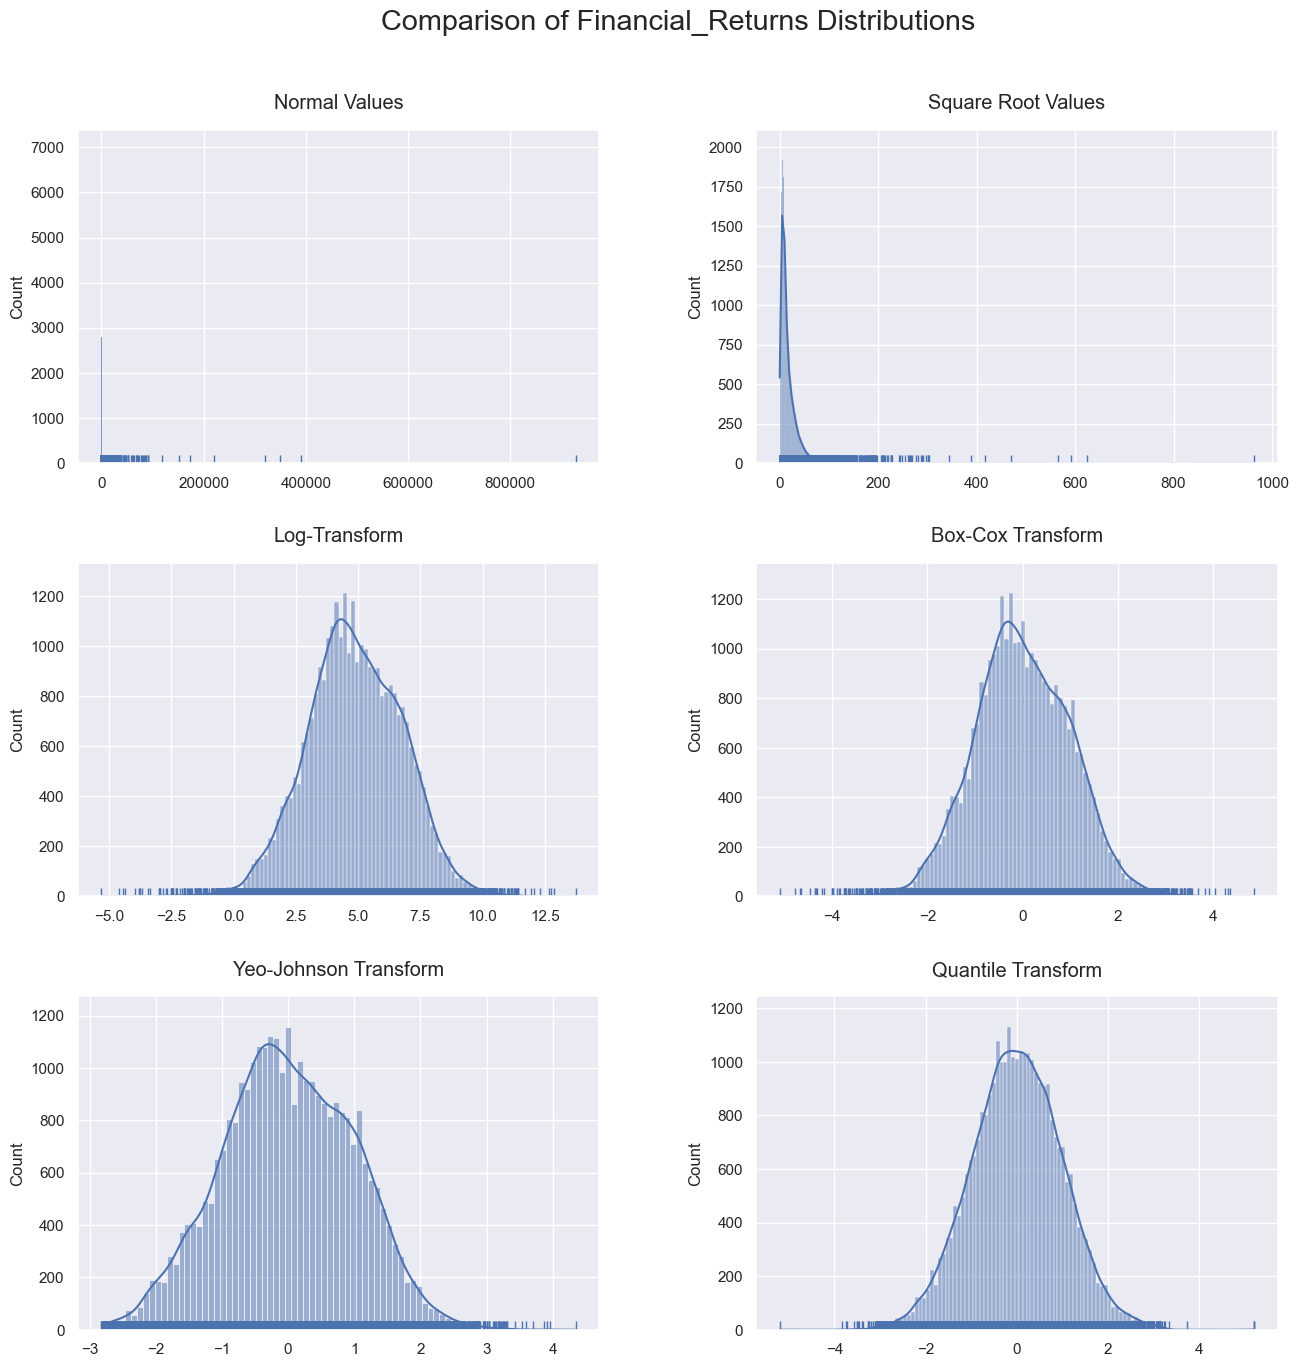

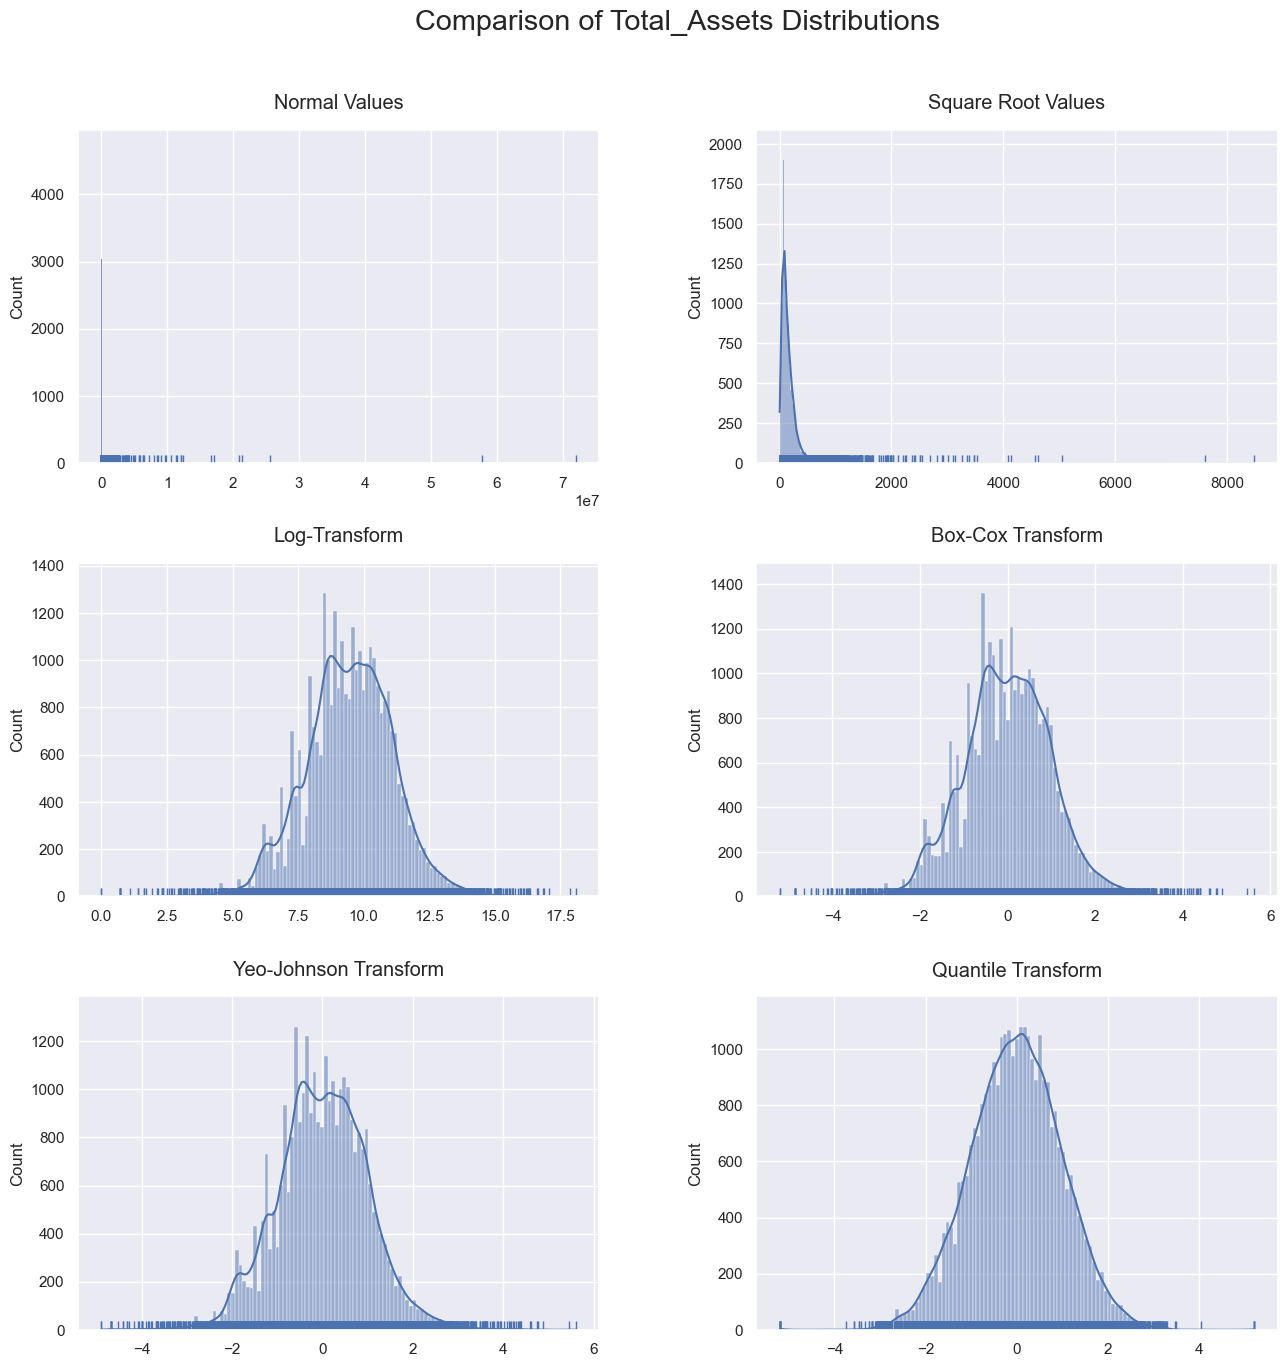

In [155]:
for variable in variables_of_interest:
    compare_transformations(variable)   

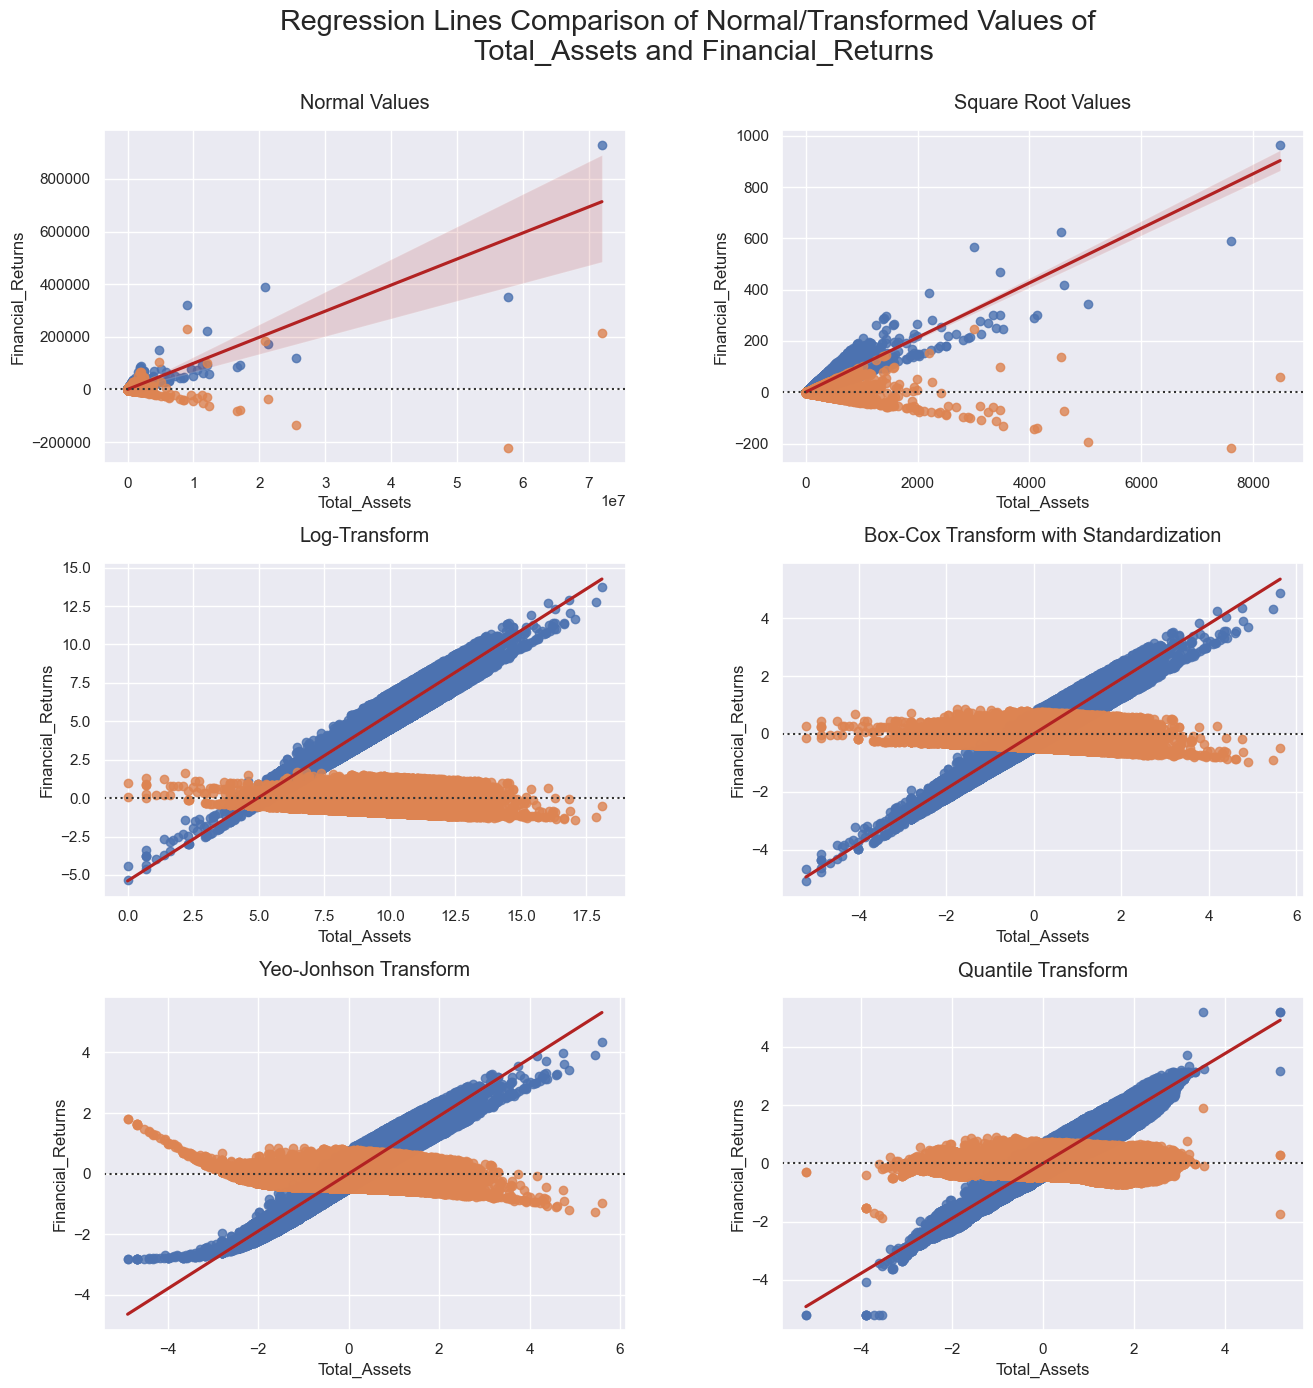

In [156]:
compare_transformations_regressions(fin_data_for_reg_test, "Total_Assets", 
                                    "Financial_Returns")

It would appear that the Quantile Transformer normalizes the two variables' distributions the most. On the other hand, the log and the Box-Cox transformations seem to be the ones that make the data smoother and more linear.

As discussed in the previous chapter when scaling was examined, when transforming variables, interpretation becomes tricky. In the case of linear regression, coefficients can no longer be interpreted in the dependent variable's units. Even though most ```scikit-learn``` transformer functions offer an inverse transform version method, I have yet to find satisfactory interpretations of regression coefficients when we transform the data with, say, the Yeo-Johnson Transform. On the other hand, the log transformation has a very clear and [well-documented interpretation](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/) of regression coefficients.

Considering the above, the log transformation seems to be the most appropriate both because we need to be able to interpret the regression coefficients and because the resulting transformation seems appropriate.

One thing to note is that while scaling data does not change the distribution of the variables, as shown in the below graph, it *does* change the interpretation of the coefficients in linear regression, as examined in [chapter 4](#chapter_4). While we could also scale our log-transformed data, I think that one should be careful with transformations when the interpretation of coefficients is required. Log transformation should suffice for these variables. 

[Text(0.5, 1.0, 'Log-Transformed and Scaled/Centered with RobustScaler')]

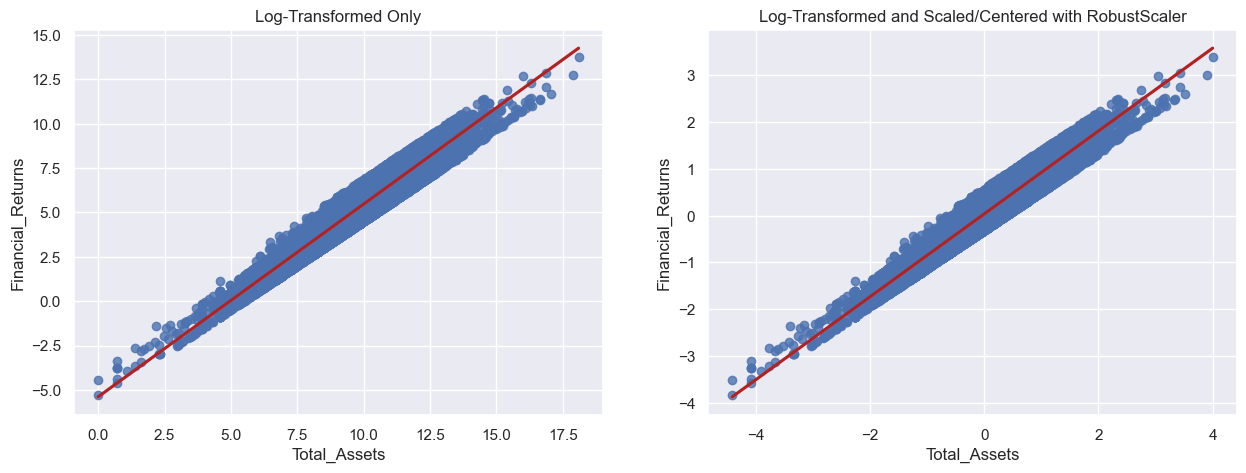

In [157]:
# Test show how different scaling does not affect distribution.
# Log-transform data
log_test = np.log(fin_data_for_reg_test)

# Scale data
robust_encoding_for_test = make_column_transformer((RobustScaler(),
                                                    ["Financial_Returns",
                                                     "Total_Assets"]), verbose_feature_names_out=False)

robust_encoded_for_test = robust_encoding_for_test .fit_transform(log_test)
robust_test = pd.DataFrame(robust_encoded_for_test, columns=robust_encoding_for_test.get_feature_names_out())

# Plot with/without scaling and centering
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
sns.regplot(log_test, x="Total_Assets", y="Financial_Returns", line_kws={"color": "firebrick"})
ax1.set(title="Log-Transformed Only")

ax2 = plt.subplot(122)
sns.regplot(robust_test, x="Total_Assets", y="Financial_Returns", line_kws={"color": "firebrick"})
ax2.set(title="Log-Transformed and Scaled/Centered with RobustScaler")

In [158]:
# Create copies
transformed_train = all_vars_unscaled_train.copy()
transformed_test = all_vars_unscaled_test.copy()

# Log-transform only the two variables
transformed_train["Financial_Returns"] = transformed_train["Financial_Returns"].apply(np.log)
transformed_train["Total_Assets"] = transformed_train["Total_Assets"].apply(np.log)

# Do the same for the test set
transformed_test["Financial_Returns"] = transformed_test["Financial_Returns"].apply(np.log)
transformed_test["Total_Assets"] = transformed_test["Total_Assets"].apply(np.log)

In [159]:
# Separate new transformed variables
transformed_ytrain = transformed_train["Financial_Returns"]
transformed_Xtrain = transformed_train.drop(["Financial_Returns"], axis=1)
transformed_ytest = transformed_test["Financial_Returns"]
transformed_Xtest = transformed_test.drop(["Financial_Returns"], axis=1)

## 5.2 Simple Linear Regression with Log-Transformed Variables
<a id="chapter_5.2"></a>

To perform backward elimination for our linear regression, we will create another copy of the transformed variables, so that we can preserve the original dataframe with all the variables for the rest of the models (as we did in the previous chapter):

In [160]:
transformed_linreg_train = transformed_train.copy()
transformed_linreg_test = transformed_test.copy()

In [161]:
linear_regression(transformed_linreg_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 3.319e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:58:39   Log-Likelihood:                -24765.
No. Observations:               31265   AIC:                         4.955e+04
Df Residuals:                   31253   BIC:                         4.965e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

**You can find all the custom functions used in this chapter in [Chapter 4 functions](#chapter_4_functions) and
[Chapter 5 functions](#chapter_5_functions).**

In [162]:
drop_variable(transformed_linreg_train, transformed_linreg_test, "Has_Employment")

In [163]:
linear_regression(transformed_linreg_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 3.548e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:58:39   Log-Likelihood:                -24105.
No. Observations:               30359   AIC:                         4.823e+04
Df Residuals:                   30348   BIC:                         4.832e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [164]:
drop_variable(transformed_linreg_train, transformed_linreg_test, "Is_Female")

In [165]:
linear_regression(transformed_linreg_train, "Financial_Returns")

                            OLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 3.790e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:58:40   Log-Likelihood:                -23206.
No. Observations:               29133   AIC:                         4.643e+04
Df Residuals:                   29123   BIC:                         4.651e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Check with weighted regr

In [166]:
weighted_linear_regression(transformed_linreg_train, "Financial_Returns")

                            WLS Regression Results                            
Dep. Variable:      Financial_Returns   R-squared:                       0.933
Model:                            WLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 4.473e+04
Date:                Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:58:40   Log-Likelihood:                -22832.
No. Observations:               29133   AIC:                         4.568e+04
Df Residuals:                   29123   BIC:                         4.577e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Quite clearly, the situation has vastly improved.

###  Coefficient Interpretation

In [167]:
# Separate new transformed variables
transformed_linreg_ytrain = transformed_linreg_train["Financial_Returns"]
transformed_linreg_Xtrain = transformed_linreg_train.drop(["Financial_Returns"], axis=1)
transformed_linreg_ytest = transformed_linreg_test["Financial_Returns"]
transformed_linreg_Xtest = transformed_linreg_test.drop(["Financial_Returns"], axis=1)

In [168]:
# Fit linear regression model on the transformed variables, calculate predictions and residuals 
lin_model_transformed = lin_regr.fit(transformed_linreg_Xtrain, transformed_linreg_ytrain)
transformed_linreg_y_pred = lin_model_transformed.predict(transformed_linreg_Xtest)
transformed_linreg_model_residuals = (transformed_linreg_ytest - transformed_linreg_y_pred)

# Define score, intercept, coefficients 
transformed_linreg_model_score = round(lin_model_transformed.score(transformed_linreg_Xtrain, transformed_linreg_ytrain), 3)
transformed_linreg_model_intercept = round(lin_model_transformed.intercept_.item(), 4)
transformed_linreg_model_coefficients = pd.DataFrame(zip(transformed_linreg_Xtrain.columns, lin_model_transformed.coef_))

# Show score, intercept, coefficients
print(f"The model's R2 score is {transformed_linreg_model_score} with an intercept of \
{transformed_linreg_model_intercept}. \n\
The coefficients of the independent variables are: {transformed_linreg_model_coefficients}.")

The model's R2 score is 0.921 with an intercept of -5.0711. 
The coefficients of the independent variables are:                          0         1
0   Remote_Bank_Connection -0.332693
1    Household_Owns_Stocks  0.209878
2              Born_Abroad -0.042542
3             Total_Assets  1.039987
4  High_Risk_Rule_Violated  0.378186
5           Is_Risk_Averse  0.031838
6             Age_under_40  0.068051
7        Med_to_Low_Income -0.043730
8  Is_Financially_Literate  0.262518.


In [169]:
cross_validate(lin_regr, transformed_linreg_Xtrain, transformed_linreg_ytrain, cv=5)

{'fit_time': array([0.0297308 , 0.02519894, 0.02493572, 0.02030826, 0.02030611]),
 'score_time': array([0.00506473, 0.00501132, 0.00613499, 0.01013923, 0.01010203]),
 'test_score': array([0.92093314, 0.91947948, 0.92048063, 0.91868753, 0.92626463])}

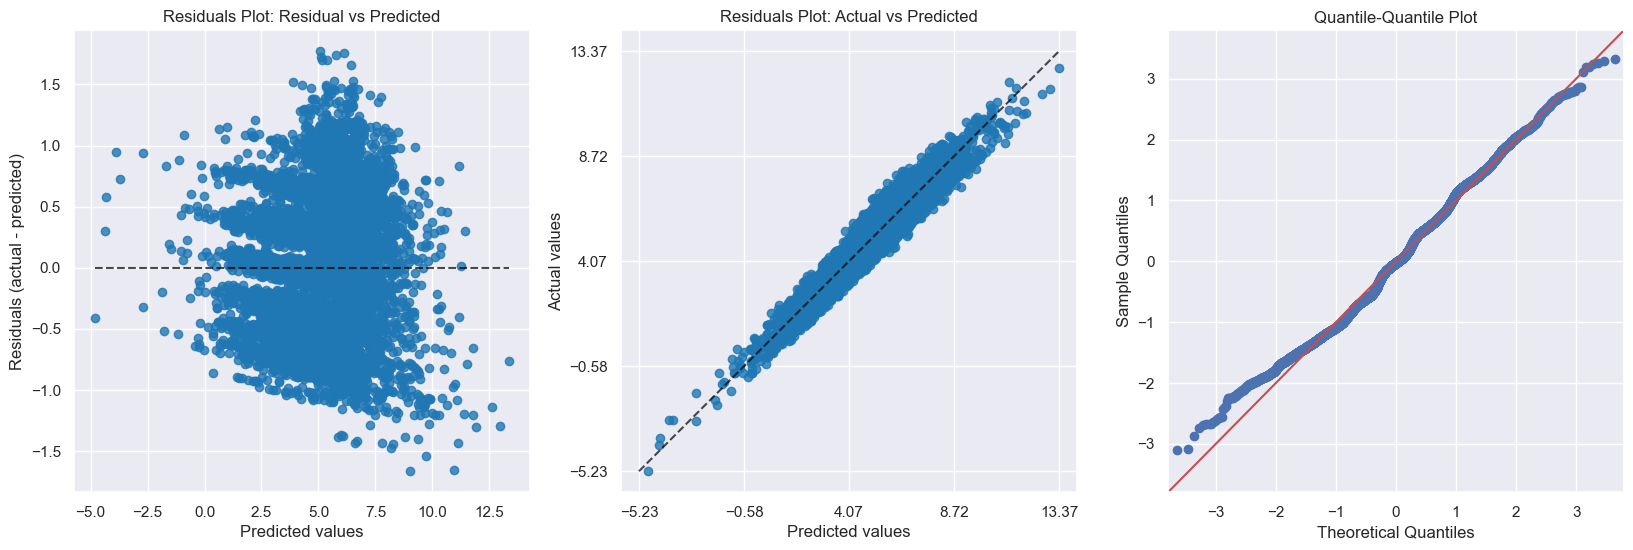

In [170]:
visualize_results(transformed_linreg_ytest, transformed_linreg_y_pred, transformed_linreg_model_residuals)

<AxesSubplot: >

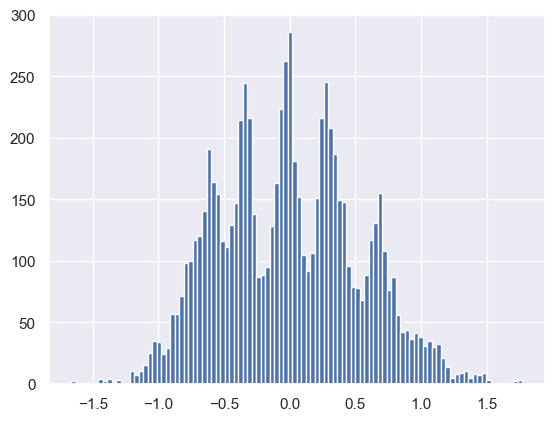

In [171]:
transformed_linreg_model_residuals.hist(bins=100)

In [172]:
kstest(transformed_linreg_model_residuals, "norm")

KstestResult(statistic=0.15909237311917557, pvalue=2.431616768262632e-169, statistic_location=-0.8145488558216876, statistic_sign=-1)

In [173]:
# Check for heteroscedasticity after transform
homoscedasticity_test(transformed_train, "Financial_Returns")

C:\Users\Unknown\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3189: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


Is_Female                  False
Remote_Bank_Connection     False
Household_Owns_Stocks      False
Born_Abroad                False
Financial_Returns          False
Total_Assets                True
High_Risk_Rule_Violated    False
Is_Risk_Averse             False
Age_under_40               False
Has_Employment              True
Med_to_Low_Income          False
Is_Financially_Literate    False
dtype: bool

Quite obviously, the log transformation of the two variables improved the results of Linear Regression. To begin with, our R2 skyrocketed to 0.921 for our normal linear regression and 0.933 for weighted regression, suggesting that around 92% of the variability of our logged dependent variable is due to its relationship with the variables present in the model (note that is true only for our logged "Financial_Returns", since the same cannot be said about the normal dependent variable).

We can see that the Jarque-Bera and Omnibus tests look better, though are still way above their suggested values. That indicates that the residuals are still not normally distributed, and the KS test agrees with that assessment. On the other hand, the residuals from the "Financial_Returns" and "Total_Assets" variables are no longer heteroscedastic, as proven by both the custom test and the graphs.  

What we can also notice is that there are some strange lines in the Residual vs. Predicted plot. It would seem that our "Financial_Returns" variable has many observations gathered at specific values, since this kind of plot usually appears [when the dependent variable takes integer values](https://dataanalyticsbook.info/chapter-6-diagnosis-residuals-heterogeneity.html).

I am unsure if these lines suggest any other implications that we have to take into consideration, but we can see that the histogram of the residuals agrees, showing a multi-modal distribution with many peaks. Considering that these lines are not present in residuals of non-linear models that follow, I will not delve any deeper into this, and simply take it as an indication of the model's imperfection. A related StackExchange discussion can be found [here](https://stats.stackexchange.com/questions/40780/regression-model-with-multimodal-outcome).

Nevertheless, the overall picture of our regression results generally makes me have a little more faith in it than I did with our models with the original data, so much so that what follows is an interpretation of the model's coefficients. According to [this article](https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model), when we have transformed both dependent and independent variables in a regression, we can interpret the coefficient as the percent increase in the dependent variable for every 1% increase in the independent variable. Thus in the case of our "Total_Assets" variable, we can interpret the coefficient as such: 

In [174]:
print(f"Provided that an investor invests successfully, \
for every 1% increase in their Total Assets, their Financials Returns \nincrease by a mean {1.0400}%. \
If we increase Total_Assets by 50%, the Financial Returns will increase by an average of \
{round(((1.50**1.0400-1)*100),2)}%.")

Provided that an investor invests successfully, for every 1% increase in their Total Assets, their Financials Returns 
increase by a mean 1.04%. If we increase Total_Assets by 50%, the Financial Returns will increase by an average of 52.45%.


The first sentence is added to account for the fact that our model does not include cases where investors suffered losses. Moreover, because the residuals are not normally distributed, it is questionable whether we can make that statement for the whole of Italy. The rest of the variables are categorical which, of course, cannot be log-transformed, and as such have a different interpretation. To properly interpret them, we need to exponentiate the coefficient, as I do below with the "High_Risk_Rule_Violated" variable:

In [175]:
print(f"Provided that an investor invests successfully, \
they will enjoy an average of {round(((np.exp(0.3782)-1)*100), 2)}% higher returns \
if high-risk \nassets, such as stocks, comprise more than 10% of their overall portfolio.")

Provided that an investor invests successfully, they will enjoy an average of 45.97% higher returns if high-risk 
assets, such as stocks, comprise more than 10% of their overall portfolio.


The above statement might seem strange, but it does make a little more sense if we take for granted that the investor is successful in their investments. Naturally, more risk will offer more reward when loss is not possible.

The rest of the coefficients can be interpreted similarly. The variable that is probably closer to what the original researchers were looking for is the "Is_Financially_Literate" variable and its interpretation is:

In [176]:
print(f"Provided that an investor invests successfully, financially literate investors have, \
on average, {round(((np.exp(0.2625)-1)*100), 2)}% higher financial\nreturns \
than financially illiterate investors.")

Provided that an investor invests successfully, financially literate investors have, on average, 30.02% higher financial
returns than financially illiterate investors.


The issue here is that the "average" we are talking about is, in fact, the [**geometric mean**](https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/) and not the normal arithmetic mean, since our variables have been log-transformed. This might not matter so much for coefficient interpretation but it is vital for prediction, analyzed in the next subchapter.

### Simple Linear Regression Model with Log-Transformed Variables Prediction

Log-tranforming our variables may have raised the R squared and improved our results, but there several issues to consider when we move from the interpretation of model coefficients to future prediction. It follows logically that the variables need to be inverse-transformed in order for us to be able to use the model for groundtruth predictions, but the inverse transformation of the log (exp) that needs to be applied to our data returns [different means that one would expect](https://stats.stackexchange.com/questions/115571/back-transforming-regression-results-when-modeling-logy) (more information can also be found [here](https://stats.stackexchange.com/questions/86808/back-transformed-confidence-intervals) , [here](https://stats.stackexchange.com/questions/87713/back-transformation) and [here](https://web.archive.org/web/20170712024346/https://www.herc.research.va.gov/include/page.asp?id=cost-regression#retransformation-bias)).

In his 1993 article "*Regression Analysis of Log Transformed Data: Statistical Bias and its Correction*", Michael C. Newman suggests that the retransformation bias originates in the fact that back-transforming predictions do not involve errors, thus resulting in less estimates. As such, the errors need to be accounted for in some way in our predictions. 

This is also the topic of this [blog post](https://andrewpwheeler.com/tag/linear-regression/) by Dr. Andrew Wheeler. Dr. Wheeler suggests that we verify the linearity of the transformation by drawing scatter plots of the original vs. the transformed value, as I do below. If the resulting graph is a straight line, as is the case with RobustScaler, then the transformation is linear and we can back-transform without worry. But if the transformation is non-linear, as is the case with our log transformation, the inverse transformation could create problems. 

A remedy to all the above is to back transform predictions and then multiply them with Duan's Smearing Estimator, which was originally presented in N. Duan's 1983 paper "*Smearing Estimate: a Non-Parametric Retranformation Method*". Unfortunately, the code Dr. Wheeler included in his blog post did not work for me, and I had to use a different formula.

Duan's Smearing Estimator has different forms depending on whether the regression residuals are normally distributed or not, and whether they are homoscedastic. Drawing from MC Newman's article, I use a variation of the Smearing Estimator which only depends on the variance of the residuals and does not take into account their distribution.

For the rest of this project, I will be showing the results of both the naively retransformed predictions and those that use Duan's Smearing Estimator. As you will see, the difference is massive and clearly outlines the necessity of using the Estimator to back-transform predictions.

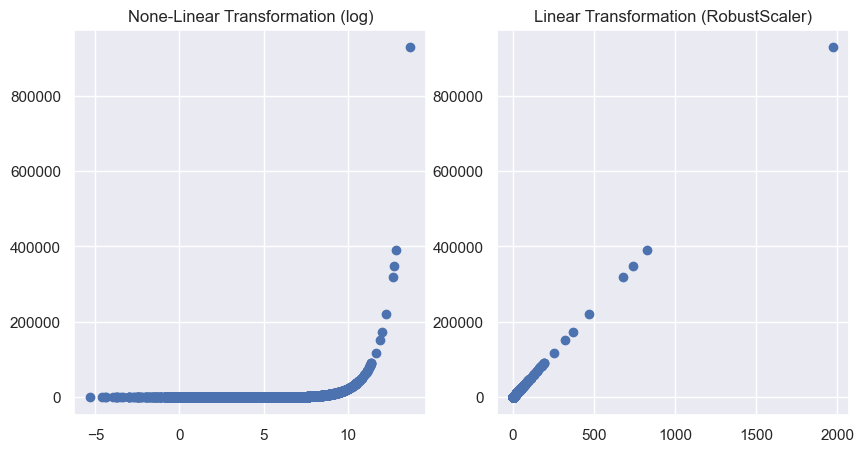

In [177]:
fig = plt.figure(figsize=(10, 5))

# Variable to use for transformation linearity testing 
not_transformed_train = all_vars_unscaled_train.copy()
not_transformed_train.drop(["Has_Employment", "Is_Female"], axis=1, inplace=True)
not_transformed_train.drop_duplicates(inplace=True)

# Plot transformation linearity test
ax1 = plt.subplot(121)
plt.scatter(x=transformed_linreg_train["Financial_Returns"], y=not_transformed_train["Financial_Returns"])
ax1.set_title("None-Linear Transformation (log)")
ax2 = plt.subplot(122)
plt.scatter(x=robust_train["Financial_Returns"], y=all_vars_unscaled_train["Financial_Returns"])
ax2.set_title("Linear Transformation (RobustScaler)");

### Simple Linear Regression Model: Naive Retransformation of Prediction 

In [178]:
# Naive retransformation
naive_retrans_linreg_ytest = np.exp(transformed_linreg_ytest)
naive_retrans_linreg_ypred = np.exp(transformed_linreg_y_pred) 

In [179]:
transformed_linreg_model_scores_naivere = model_score(lin_regr, transformed_linreg_Xtrain, 
                                                      transformed_linreg_ytrain, naive_retrans_linreg_ytest, 
                                                      naive_retrans_linreg_ypred, round_int=2)
transformed_linreg_model_scores_naivere .rename({"Score Values":  "Linear Regression Model Scores \
(Naive Back-Transformation of Variables)"}, axis=1, inplace=True)
transformed_linreg_model_scores_naivere 

Linear Regression Model Scores (Naive Back-Transformation of Variables)
Mean Absolute Error                                                     552.93                      
Max Error                                                            339799.20                      
MAPE                                                                     47.17                      
Mean R2 Score after 5 CV                                                  0.92                      
R2 Score Standard Deviation                                               0.00                      
Root Mean Squared Error                                                6453.50                      
Mean Squared Error                                                 41647714.72

### Linear Regression Model: Retransformation of Prediction with Duan's Smearing Estimator

**You can find all the custom functions used in this chapter in [Chapter 5 functions](#chapter_5_functions).**

In [180]:
# Calculate variance of residuals
linreg_resid_var = transformed_linreg_model_residuals.var()

In [181]:
# Define Duan's Smearing Estimator
linreg_duan = duans_smearing_bias_correction(linreg_resid_var)

In [182]:
# Multiply predictions and test with Duan's Smearing Estimator
duans_retrans_linreg_pred = naive_retrans_linreg_ypred*linreg_duan
duans_retrans_linreg_ytest = naive_retrans_linreg_ytest*linreg_duan

In [183]:
transformed_linreg_model_scores_duansre = model_score(lin_regr, transformed_linreg_Xtrain, transformed_linreg_ytrain, 
                                                      duans_retrans_linreg_ytest, 
                                                      duans_retrans_linreg_pred, round_int=2)

transformed_linreg_model_scores_duansre .rename({"Score Values":  "Linear Regression Model Scores \
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
transformed_linreg_model_scores_duansre

Linear Regression Model Scores (Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     212.86                                
Max Error                                                            130809.38                                
MAPE                                                                     47.17                                
Mean R2 Score after 5 CV                                                  0.92                                
R2 Score Standard Deviation                                               0.00                                
Root Mean Squared Error                                                2484.35                                
Mean Squared Error                                                  6171976.14

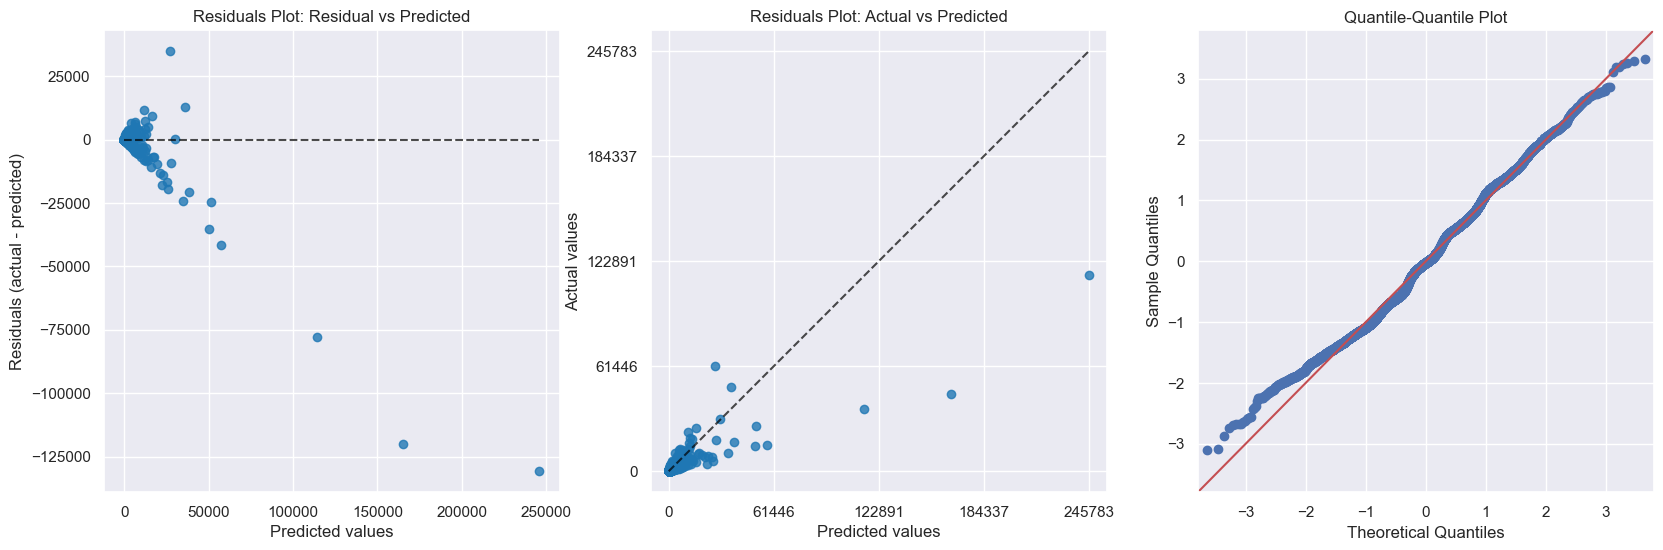

In [184]:
visualize_results(duans_retrans_linreg_ytest, duans_retrans_linreg_pred, transformed_linreg_model_residuals)

Seeing the above tables clearly proves that the naive retransformation has horrible results! Despite the high R2, the actual MAE is far worse than even the first model in chapter 4. On the other hand, using Duan's Estimator minimizes the MAE to less than half of that of the model with the naive estimates, making it much better than even the two non-linear algorithms trained on the original data.

The MAPE has fallen to a more okay-ish level (less than 50%), though obviously, it's still bad. Nevertheless, if we consider the ground truth for a moment, we currently have a prediction of investment returns based *only* on total assets and some investor traits. I would be surprised if any prediction with only these variables were accurate, and a MAPE of 47% is actually much better than I expected.

Now let's move on to see how the rest of the models fare with the same methodology we used for Simple Linear Regression.

## 5.3 Elastic Net Regression with Log-Transformed Variables
<a id="chapter_5.3"></a>

Moving on with the rest of the models, we will again be using the dataframe we created in chapter 5.1, which contains all the variables:

In [185]:
# Cross validate the best parameters of elastic net for our tranformed data
elastic_cross_validation = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
elastic_model_cv = ElasticNetCV(cv=elastic_cross_validation)

elastic_model_cv.fit(transformed_Xtrain, transformed_ytrain)

ElasticNetCV(cv=RepeatedKFold(n_repeats=10, n_splits=10, random_state=42))

In [186]:
print("alpha: %f" % elastic_model_cv.alpha_)
print("l1_ratio_: %f" % elastic_model_cv.l1_ratio_)

alpha: 0.006038
l1_ratio_: 0.500000


In [187]:
# Define elastic regression model, calculate predictions and residuals
trans_ela_net_reg = ElasticNet(alpha=elastic_model_cv.alpha_, l1_ratio=elastic_model_cv.l1_ratio_)
elastic_model_trans = trans_ela_net_reg.fit(transformed_Xtrain, transformed_ytrain)
elastic_ypred_trans = elastic_model_trans.predict(transformed_Xtest)
elastic_trans_residuals = (transformed_ytest - elastic_ypred_trans)

# Define score, intercept, coefficients
trans_elastic_model_score = round(elastic_model_trans.score(transformed_Xtrain, transformed_ytrain), 3)
trans_elastic_model_intercept = round(elastic_model_trans.intercept_.item(), 4)
trans_elastic_model_coefficients = pd.DataFrame(zip(transformed_Xtrain.columns, 
                                                    elastic_model_trans.coef_))

# Show score, intercept, coefficients
print(f"The model's R2 score is {trans_elastic_model_score} with an intercept of \
{trans_elastic_model_intercept}. \nThe coefficients of the independent variables are: \
{trans_elastic_model_coefficients}.")

The model's R2 score is 0.921 with an intercept of -5.0928. 
The coefficients of the independent variables are:                           0         1
0                 Is_Female -0.000000
1    Remote_Bank_Connection -0.299556
2     Household_Owns_Stocks  0.172228
3               Born_Abroad -0.000000
4              Total_Assets  1.043808
5   High_Risk_Rule_Violated  0.365660
6            Is_Risk_Averse  0.000000
7              Age_under_40  0.045066
8            Has_Employment -0.000000
9         Med_to_Low_Income -0.027186
10  Is_Financially_Literate  0.245641.


Interestingly, the Elastic Net's penalization automatically eliminated certain variables by drastically minimizing their coefficients. While most of the variables eliminated are the same as the ones we manually eliminated using backward elimination in the case of Simple Linear Regression, the Elastic Net Regressor also eliminated the "Risk_Averse" and "Has_Employment" variables. 

This is similar to what the Weighted Regression model did with the original variables, although the "Med_to_Low_Income" variable is kept in this case, when it was judged as insignificant by the Weighted Regression model. Still, the variable's coefficient is drastically reduced. 

Considering all the other results and models I fit in this project, I could say that even by looking at the coefficients of the Elastic Net Regressor, I can see the effect sizes of each variable, and they do not disagree with what both the other models and logic would dictate. Even though we cannot use units or percentages to measure them as we would with standardized coefficients, I would say that the "smaller the coefficient, the smaller the effect size" would not be entirely, if at all, incorrect.

The Elastic Net Regressor's power becomes more obvious here.

In [188]:
cross_validate(elastic_model_trans, transformed_Xtrain, transformed_ytrain, cv=5)

{'fit_time': array([0.03620172, 0.03011847, 0.03465796, 0.03061795, 0.0305829 ]),
 'score_time': array([0.00457692, 0.00510216, 0.00610685, 0.00813055, 0.00756001]),
 'test_score': array([0.92094622, 0.92038465, 0.91921534, 0.91786788, 0.92579635])}

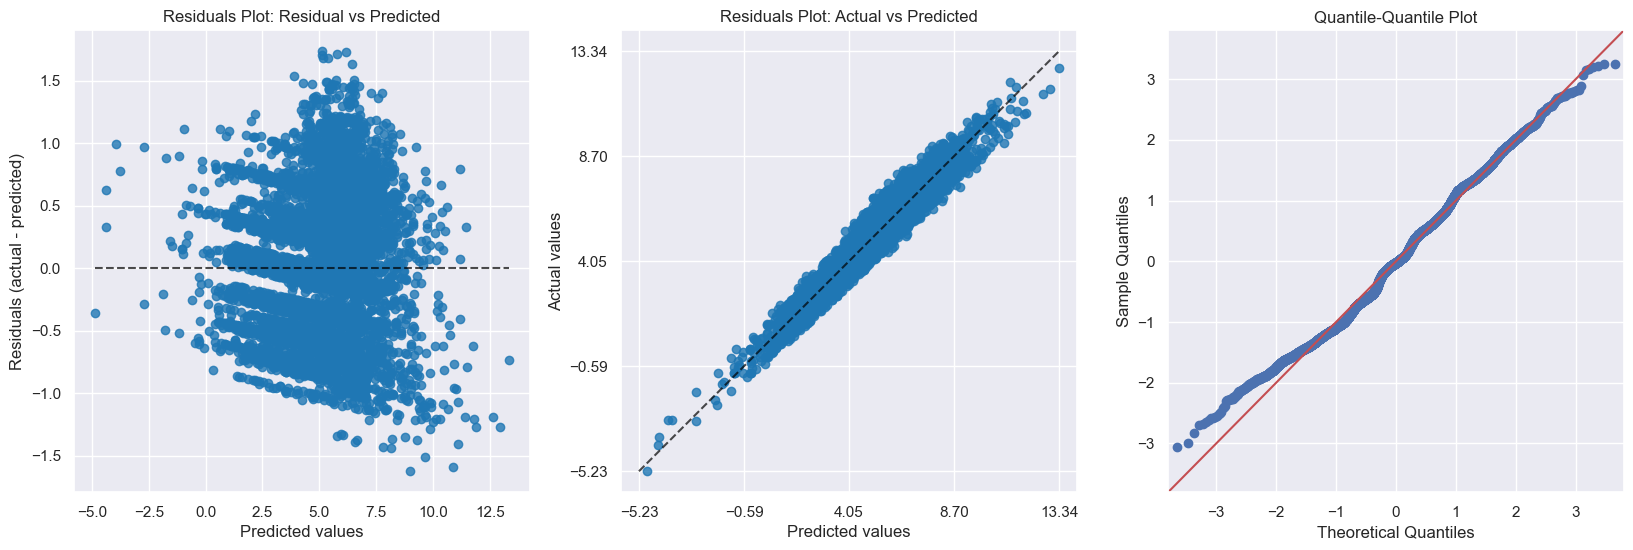

In [189]:
visualize_results(transformed_ytest, elastic_ypred_trans, elastic_trans_residuals)

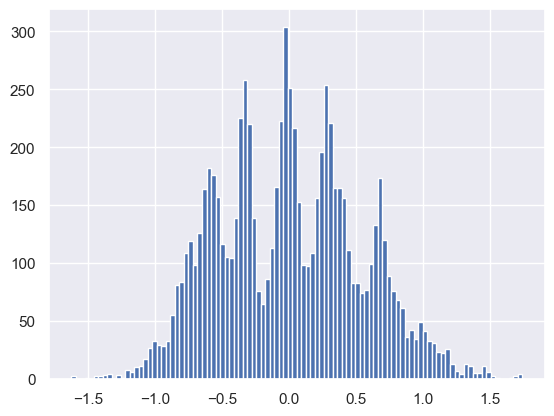

In [190]:
elastic_trans_residuals.hist(bins=100);

### Elastic Net Predictions: Naive Retransformation of Predictions

In [191]:
# Naive retrasformation 
naive_retrans_ytest = np.exp(transformed_ytest)
naive_retrans_elastic_ypred = np.exp(elastic_ypred_trans)  

In [192]:
trans_elastic_model_scores_naivere = model_score(elastic_model_trans, transformed_Xtrain, 
                                                 transformed_ytrain, naive_retrans_ytest, 
                                                 naive_retrans_elastic_ypred, round_int=2)
trans_elastic_model_scores_naivere.rename({"Score Values": "Transformed Elastic Model Scores \
(Naive Back-Transformation of Variables)"}, axis=1, inplace=True)
trans_elastic_model_scores_naivere

Transformed Elastic Model Scores (Naive Back-Transformation of Variables)
Mean Absolute Error                                                     540.34                        
Max Error                                                            324553.27                        
MAPE                                                                     46.68                        
Mean R2 Score after 5 CV                                                  0.92                        
R2 Score Standard Deviation                                               0.00                        
Root Mean Squared Error                                                6255.49                        
Mean Squared Error                                                 39131170.55

### Elastic Net Predictions: Retransformation of Predictions with Duan's Smearing Estimator

In [193]:
# Calculate variance of residuals
elastic_resid_var = elastic_trans_residuals.var()

In [194]:
# Define Duan's Smearing Estimator for our elastic net model
elastic_duan = duans_smearing_bias_correction(elastic_resid_var)

In [195]:
# Multiply predictions and test with Duan's Smearing Estimator
duans_retrans_elastic_pred = naive_retrans_elastic_ypred*elastic_duan
duans_retrans_elastic_ytest = naive_retrans_ytest*elastic_duan

In [196]:
trans_elastic_model_scores_duansre = model_score(elastic_model_trans, transformed_Xtrain, 
                                                 transformed_ytrain, duans_retrans_elastic_ytest, 
                                                 duans_retrans_elastic_pred, round_int=2)
trans_elastic_model_scores_duansre.rename({"Score Values": "Transformed Elastic Model Scores \
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
trans_elastic_model_scores_duansre

Transformed Elastic Model Scores (Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     206.67                                  
Max Error                                                            124136.06                                  
MAPE                                                                     46.68                                  
Mean R2 Score after 5 CV                                                  0.92                                  
R2 Score Standard Deviation                                               0.00                                  
Root Mean Squared Error                                                2392.62                                  
Mean Squared Error                                                  5724621.42

Once again, we see how Duan's Estimator significantly improves the result. We can also see a slight, but not totally insignificant, improvement in the results of the Elastic Net Regressor when compared to those from Simple Linear Regression. 

Similarly, the interpretation of the coefficients is exactly the same as the one we used in Simple Linear Regression. The coefficient values themselves are not that far off either. The issues that persist are those affecting the residuals: the errors still show those strange lines, and our residuals are similar to those of the Simple Linear Regression model.

Next, we will see how non-linear models are affected by the log transformation of the two variables. 

## 5.4 Random Forest with Log-Transformed Variables
<a id="chapter_5.4"></a>

### Default Random Forest Model with Log-Transformed Variables

In [197]:
# Default random forest regressor defined in chapter 4
# Define default random forest model, fit on transformed variables and calculate predictions and residuals
trans_default_forest = fo_regr.fit(transformed_Xtrain, transformed_ytrain)
trans_default_forest_y_pred = trans_default_forest.predict(transformed_Xtest)
trans_default_forest_residuals = (transformed_ytest - trans_default_forest_y_pred)

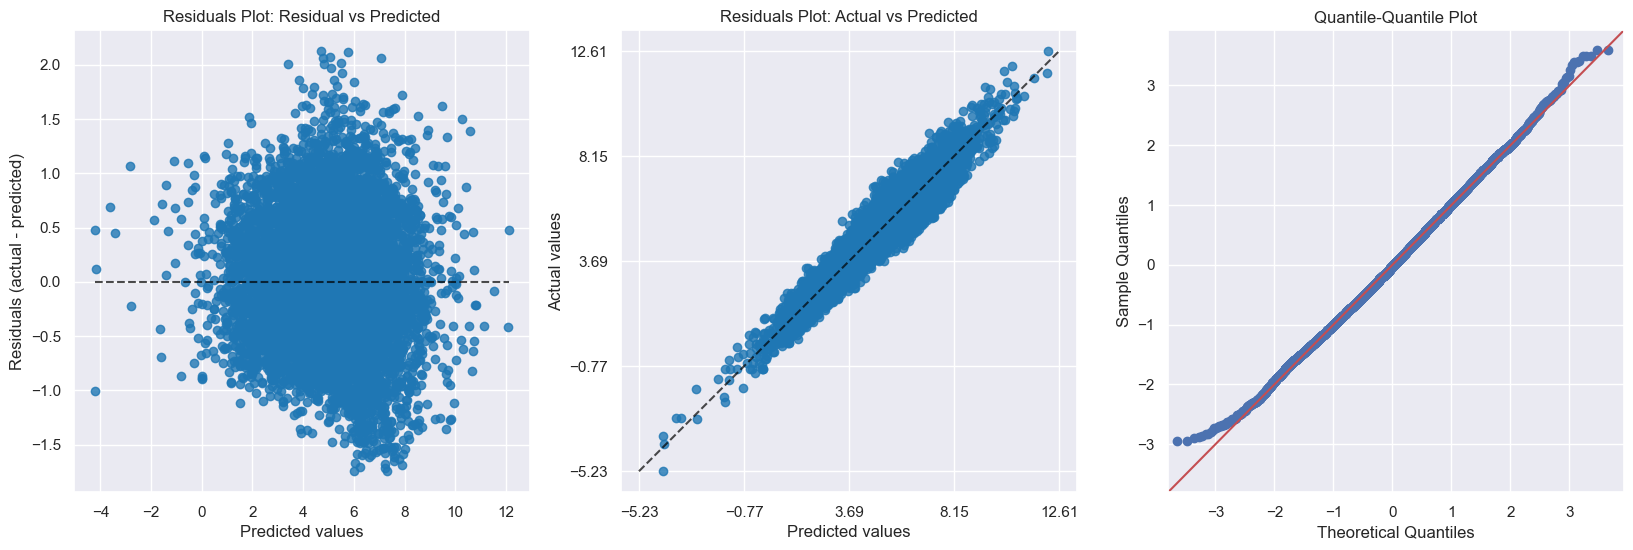

In [198]:
visualize_results(transformed_ytest, trans_default_forest_y_pred, trans_default_forest_residuals)

<AxesSubplot: >

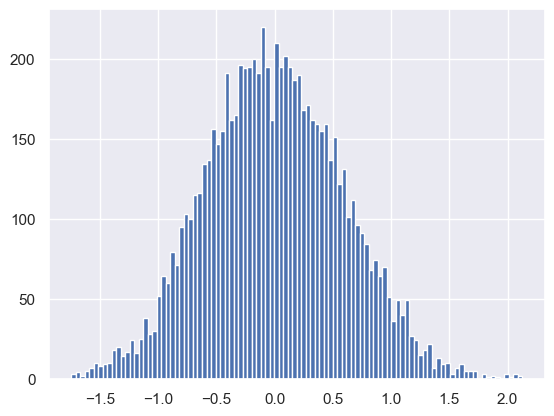

In [199]:
trans_default_forest_residuals.hist(bins=100)

In [200]:
kstest(trans_default_forest_residuals, "norm")

KstestResult(statistic=0.12935966237198207, pvalue=1.6634074236843776e-114, statistic_location=-0.8123681840019805, statistic_sign=-1)

### Default Random Forest Model: Naive Retransformation of Predictions

In [201]:
# Naive retransformation 
forest_naive_back_transform_ypred = np.exp(trans_default_forest_y_pred) 

In [202]:
trans_default_forest_model_scores_naivere = model_score(trans_default_forest, transformed_Xtrain, transformed_ytrain, 
                                                        naive_retrans_ytest, forest_naive_back_transform_ypred, 
                                                        round_int=2)
trans_default_forest_model_scores_naivere.rename({"Score Values": "Transformed Default Forest Model Scores\
(Naive Back-Transformation of Variables)"},  axis=1, inplace=True)
trans_default_forest_model_scores_naivere

Transformed Default Forest Model Scores(Naive Back-Transformation of Variables)
Mean Absolute Error                                                     415.97                              
Max Error                                                            120273.65                              
MAPE                                                                     52.55                              
Mean R2 Score after 5 CV                                                  0.90                              
R2 Score Standard Deviation                                               0.00                              
Root Mean Squared Error                                                2835.42                              
Mean Squared Error                                                  8039610.91

### Default Random Forest Model: Retransformation of Predictions with Duan's Smearing Estimator

In [203]:
# Calculate variance of default random forest residuals
def_forest_res_var = trans_default_forest_residuals.var()

In [204]:
# Define Duan's Smearing Estimator for default random forest model
def_forest_duan = duans_smearing_bias_correction(def_forest_res_var)

In [205]:
# Multiply predictions and test with Duan's Smearing Estimator
forest_duans_back_transform_ypred = forest_naive_back_transform_ypred*def_forest_duan
forest_duans_back_transform_ytest = naive_retrans_ytest*def_forest_duan

In [206]:
default_forest_model_scores_duansre = model_score(trans_default_forest, transformed_Xtrain, transformed_ytrain,
                                                  forest_duans_back_transform_ytest,
                                                  forest_duans_back_transform_ypred, round_int=2)
default_forest_model_scores_duansre.rename({"Score Values": "Transformed Default Forest Model Scores \
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
default_forest_model_scores_duansre

Transformed Default Forest Model Scores (Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     210.34                                         
Max Error                                                             60818.67                                         
MAPE                                                                     52.55                                         
Mean R2 Score after 5 CV                                                  0.90                                         
R2 Score Standard Deviation                                               0.00                                         
Root Mean Squared Error                                                1433.78                                         
Mean Squared Error                                                  2055738.33

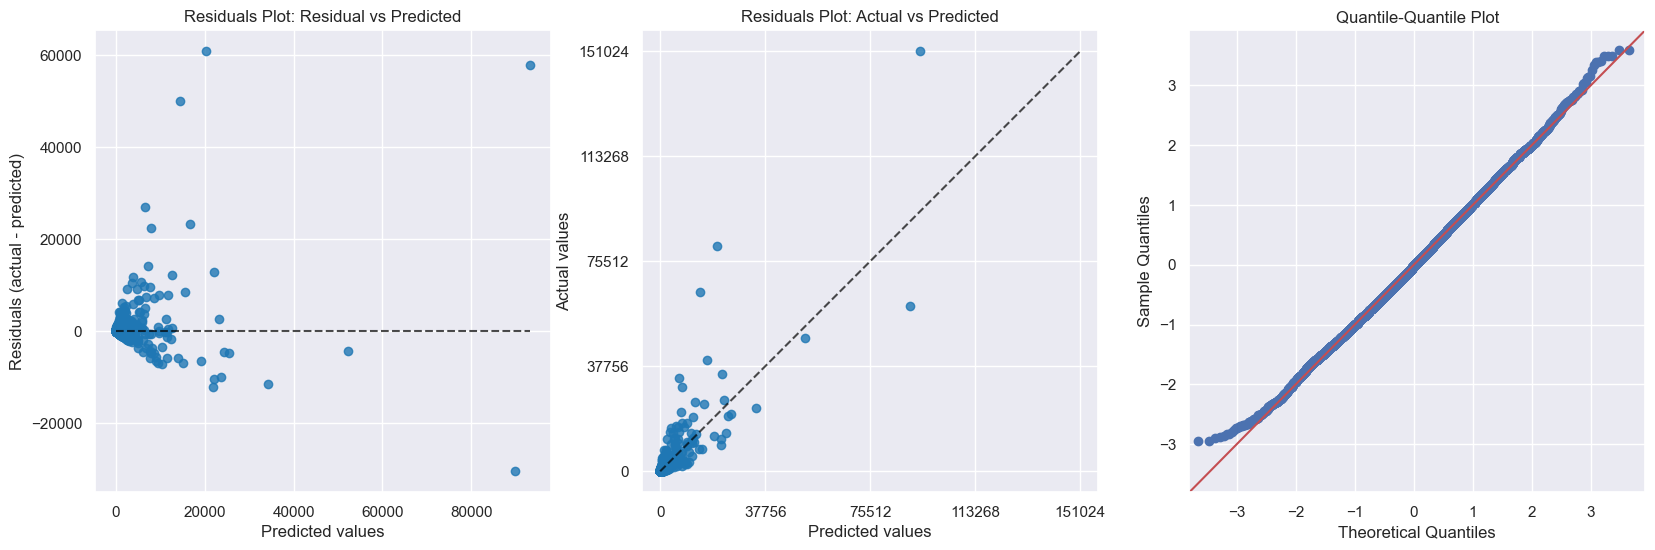

In [207]:
visualize_results(forest_duans_back_transform_ytest, forest_duans_back_transform_ypred, trans_default_forest_residuals)

Contrary to what [some would claim online](https://stats.stackexchange.com/questions/58697/when-to-log-exp-your-variables-when-using-random-forest-models), the log transformation again significantly improves our Random Forest model.

An interesting question is whether we need to perform additional hyperparameter tuning than the one we did with the original variables or if the best hyperparameters are the same in both cases. This will be explored below. 

### Random Forest Hyperparameter Tuning with Transformed Variables

Let's see if the transformation affects hyperparameter tuning:

In [208]:
# Original hyperparameters dict defined in chapter 4
randomized_forest_search_trans = RandomizedSearchCV(fo_regr, 
                                                    param_distributions=random_forest_param_distributions_1rst_iter, 
                                                    n_jobs=-1, random_state=42, 
                                                    scoring=["neg_mean_absolute_error", "r2"], 
                                                    refit="neg_mean_absolute_error")

randomized_forest_search_trans.fit(transformed_Xtrain, transformed_ytrain)

show_param_cv_results(random_forest_param_distributions_1rst_iter, randomized_forest_search_trans)

param_max_features param_max_leaf_nodes param_min_samples_leaf  R2 Score  \
0                  5                 None                     10  0.919001   
3               None                  100                      1  0.920952   
9                  5                 None                     20  0.917315   
8                  5                 1000                    100  0.907313   
6                  3                 None                     20  0.897693   
4                  2                 1000                      1  0.889110   
1                  3                  100                     20  0.879079   
7                  3                  100                    100  0.864373   
5                  1                  100                     50  0.765315   
2                  2                   10                     10  0.709025   

   R2 Standard Deviation  Mean Absolute Error  \
0               0.002552             0.439786   
3               0.002342             0.440647   
9               0.002452             0.442519   
8               0.002294             0.460715   
6               0.001646             0.474940   
4               0.002052             0.494127   
1               0.002831             0.508713   
7               0.003251             0.529646   
5               0.004352             0.678665   
2               0.005232             0.758205   

   Absolute Error Standard Deviation  
0                           0.003073  
3                           0.002811  
9                           0.002621  
8                           0.002710  
6                           0.002018  
4                           0.001921  
1                           0.004354  
7                           0.004943  
5                           0.007321  
2                           0.010237

In [209]:
# 2nd dict of hyperparameter distributions, taking first 2 results
random_forest_param_distributions_2nd_iter_trans = {"max_features": [5, None],
                                                    "max_leaf_nodes": [None, 100],
                                                    "min_samples_leaf": [20, 1, 10],
                                                    "min_samples_split": [2, 250, 500, 750, 1000]}

In [210]:
randomized_forest_search_2nd_iter_trans = RandomizedSearchCV(
    fo_regr,
    param_distributions=random_forest_param_distributions_2nd_iter_trans, 
    n_jobs=-1, random_state=42, 
    scoring=["neg_mean_absolute_error", "r2"], 
    refit="neg_mean_absolute_error"
)

randomized_forest_search_2nd_iter_trans.fit(transformed_Xtrain, transformed_ytrain)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_features': [5, None],
                                        'max_leaf_nodes': [None, 100],
                                        'min_samples_leaf': [20, 1, 10],
                                        'min_samples_split': [2, 250, 500, 750,
                                                              1000]},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'])

In [211]:
show_param_cv_results(random_forest_param_distributions_2nd_iter_trans, randomized_forest_search_2nd_iter_trans)

param_max_features param_max_leaf_nodes param_min_samples_leaf  \
3               None                  100                     20   
0                  5                 None                     20   
2               None                 None                      1   
9               None                  100                     10   
6               None                 None                     20   
7               None                  100                     20   
8                  5                 None                     10   
5               None                  100                      1   
1                  5                 None                      1   
4                  5                 None                     10   

  param_min_samples_split  R2 Score  R2 Standard Deviation  \
3                       2  0.920382               0.002247   
0                       2  0.917315               0.002452   
2                     250  0.918109               0.002709   
9                     500  0.915782               0.002817   
6                     750  0.905083               0.002516   
7                     750  0.905083               0.002516   
8                     500  0.900707               0.001643   
5                    1000  0.900500               0.001910   
1                       2  0.899329               0.003397   
4                     750  0.891868               0.002097   

   Mean Absolute Error  Absolute Error Standard Deviation  
3             0.441345                           0.002488  
0             0.442519                           0.002621  
2             0.445973                           0.003416  
9             0.453469                           0.003391  
6             0.470549                           0.003664  
7             0.470549                           0.003664  
8             0.471695                           0.002401  
5             0.478335                           0.003530  
1             0.483515                           0.005005  
4             0.486290                           0.003787

In [212]:
# Dict for grid search for min_samples_split, n_estimators
forest_param_grid_trans = {"max_features": [None], 
                           "max_leaf_nodes": [100],
                           "min_samples_leaf": [20],
                           "min_samples_split": [2],
                           "n_estimators": [50, 100, 500, 1000]}

In [213]:
# Grid search object for best hyperparameters
grid_forest_search_trans = GridSearchCV(fo_regr, param_grid=forest_param_grid_trans, 
                                        n_jobs=-1, scoring=["neg_mean_absolute_error", "r2"], 
                                        refit="neg_mean_absolute_error")
# Fit
grid_forest_search_trans.fit(transformed_Xtrain, transformed_ytrain)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [None], 'max_leaf_nodes': [100],
                         'min_samples_leaf': [20], 'min_samples_split': [2],
                         'n_estimators': [50, 100, 500, 1000]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [214]:
show_param_cv_results(forest_param_grid_trans, grid_forest_search_trans)

param_max_features param_max_leaf_nodes param_min_samples_leaf  \
2               None                  100                     20   
3               None                  100                     20   
1               None                  100                     20   
0               None                  100                     20   

  param_min_samples_split param_n_estimators  R2 Score  R2 Standard Deviation  \
2                       2                500  0.920423               0.002266   
3                       2               1000  0.920421               0.002268   
1                       2                100  0.920382               0.002247   
0                       2                 50  0.920306               0.002197   

   Mean Absolute Error  Absolute Error Standard Deviation  
2             0.441243                           0.002435  
3             0.441258                           0.002415  
1             0.441345                           0.002488  
0             0.441546                           0.002370

It seems that the best hyperparameters of the Random Forest with transformed variables are different than those of the same algorithm with the original values.

### Tuned Random Forest: Naive Retransformation of Predictions

In [215]:
forest_best_params_trans = grid_forest_search_trans.best_params_

In [216]:
# Fit with the best hyperparameters, calculate predictions and residuals
fo_regr_tuned_trans = RandomForestRegressor(**forest_best_params_trans, random_state=42)
trans_tuned_forest = fo_regr_tuned_trans.fit(transformed_Xtrain, transformed_ytrain)
trans_tuned_forest_y_pred = trans_tuned_forest.predict(transformed_Xtest)
trans_tuned_forest_residuals = (transformed_ytest - trans_tuned_forest_y_pred)

In [217]:
# Naive retransformation
forest_naive_back_transform_ypred_tuned = np.exp(trans_tuned_forest_y_pred) 

In [218]:
tuned_forest_model_scores = model_score(fo_regr_tuned_trans, transformed_Xtrain, transformed_ytrain, 
                                        naive_retrans_ytest, forest_naive_back_transform_ypred_tuned,
                                        round_int=2)
tuned_forest_model_scores.rename({"Score Values": "Transformed Tuned Forest Model Scores \
(Naive Back-Transformation of Variables)"}, axis=1, inplace=True)
tuned_forest_model_scores

Transformed Tuned Forest Model Scores (Naive Back-Transformation of Variables)
Mean Absolute Error                                                     429.58                             
Max Error                                                            228689.57                             
MAPE                                                                     47.04                             
Mean R2 Score after 5 CV                                                  0.92                             
R2 Score Standard Deviation                                               0.00                             
Root Mean Squared Error                                                3546.38                             
Mean Squared Error                                                 12576799.05

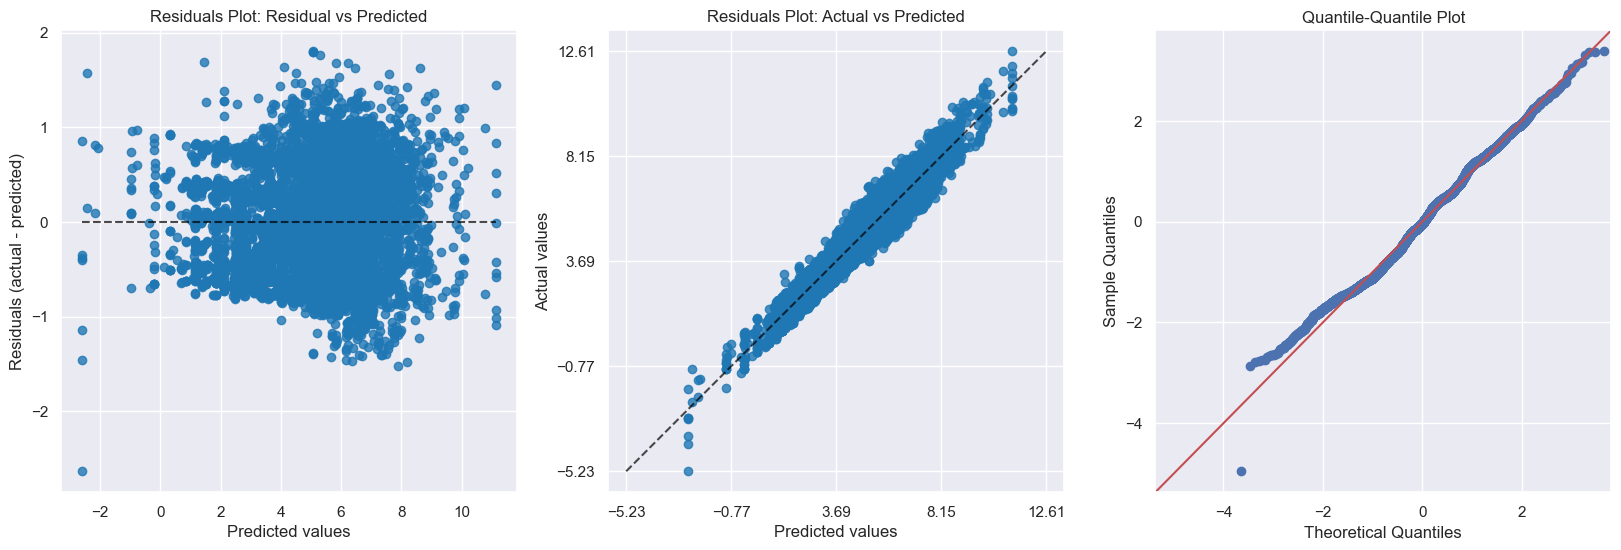

In [219]:
visualize_results(transformed_ytest, trans_tuned_forest_y_pred, trans_tuned_forest_residuals)

Interestingly, the lines that appeared in the residual plots of the linear models are still visible but much less prevalent. 

### Tuned Random Forest: Retransformation of Predictions Duan's Smearing Estimator

In [220]:
# Calculate variance of tuned random forest residuals
trans_tuned_forest_res_var = trans_tuned_forest_residuals.var()

In [221]:
# Define Duan's Smearing Estimator for tuned random forest model
tuned_forest_duan = duans_smearing_bias_correction(trans_tuned_forest_res_var)

In [222]:
# Multiply predictions and test with Duan's Smearing Estimator
forest_duans_back_transform_ypred_tuned = forest_naive_back_transform_ypred_tuned*tuned_forest_duan
forest_duans_back_transform_ytest_tuned = naive_retrans_ytest*tuned_forest_duan

**You can find all the custom functions used in this chapter in [Chapter 5 functions](#chapter_5_functions).**

In [223]:
tuned_forest_model_scores_duansre = model_score(fo_regr_tuned_trans, transformed_Xtrain, transformed_ytrain,
                                                forest_duans_back_transform_ytest_tuned, 
                                                forest_duans_back_transform_ypred_tuned,
                                                round_int=2)
tuned_forest_model_scores_duansre.rename({"Score Values": "Transformed Tuned Forest Model Scores \
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
tuned_forest_model_scores_duansre

Transformed Tuned Forest Model Scores (Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     163.55                                       
Max Error                                                             87069.23                                       
MAPE                                                                     47.04                                       
Mean R2 Score after 5 CV                                                  0.92                                       
R2 Score Standard Deviation                                               0.00                                       
Root Mean Squared Error                                                1350.22                                       
Mean Squared Error                                                  1823084.47

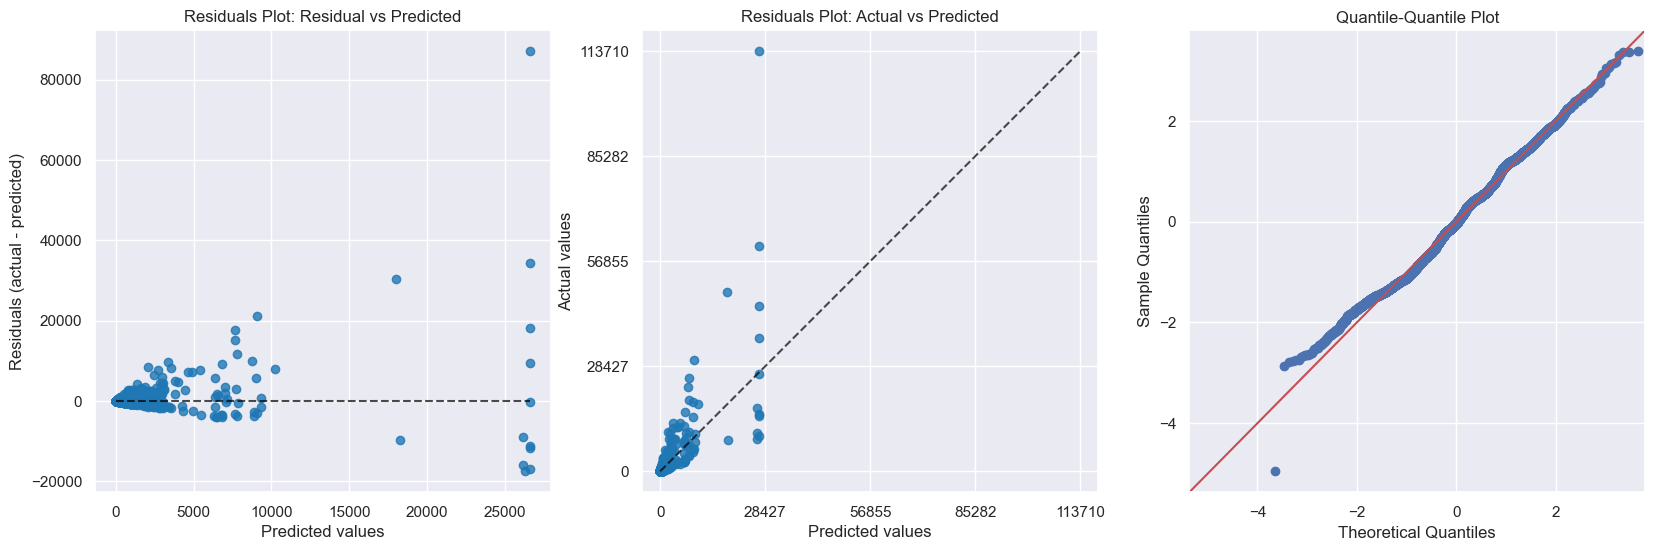

In [224]:
visualize_results(forest_duans_back_transform_ytest_tuned,
                  forest_duans_back_transform_ypred_tuned, 
                  trans_tuned_forest_residuals)

<AxesSubplot: >

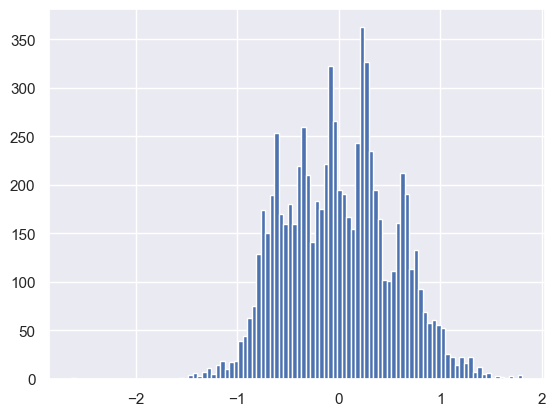

In [225]:
trans_tuned_forest_residuals.hist(bins=100)

We can see that the Random Forest algorithm performs even better than both linear models. All the errors I have chosen for evaluation are better, even though certain patterns in the residuals, such as the lines and the multimodal histogram, are still present.

Finally, let's look at the last algorithm before we can compare all results.

## 5.5 Gradient Boosting Regression with Log-Transformed Vars
<a id="chapter_5.5"></a>

### Default Gradient Boosting Regression with Log-Transformed Variables

In [226]:
# Fit default gbr model, calculate predictions and residuals 
def_trans_gbr_reg = gbr_reg.fit(transformed_Xtrain, transformed_ytrain)
def_trans_gbr_y_pred = def_trans_gbr_reg.predict(transformed_Xtest)
def_trans_gbr_residuals = (transformed_ytest - def_trans_gbr_y_pred)

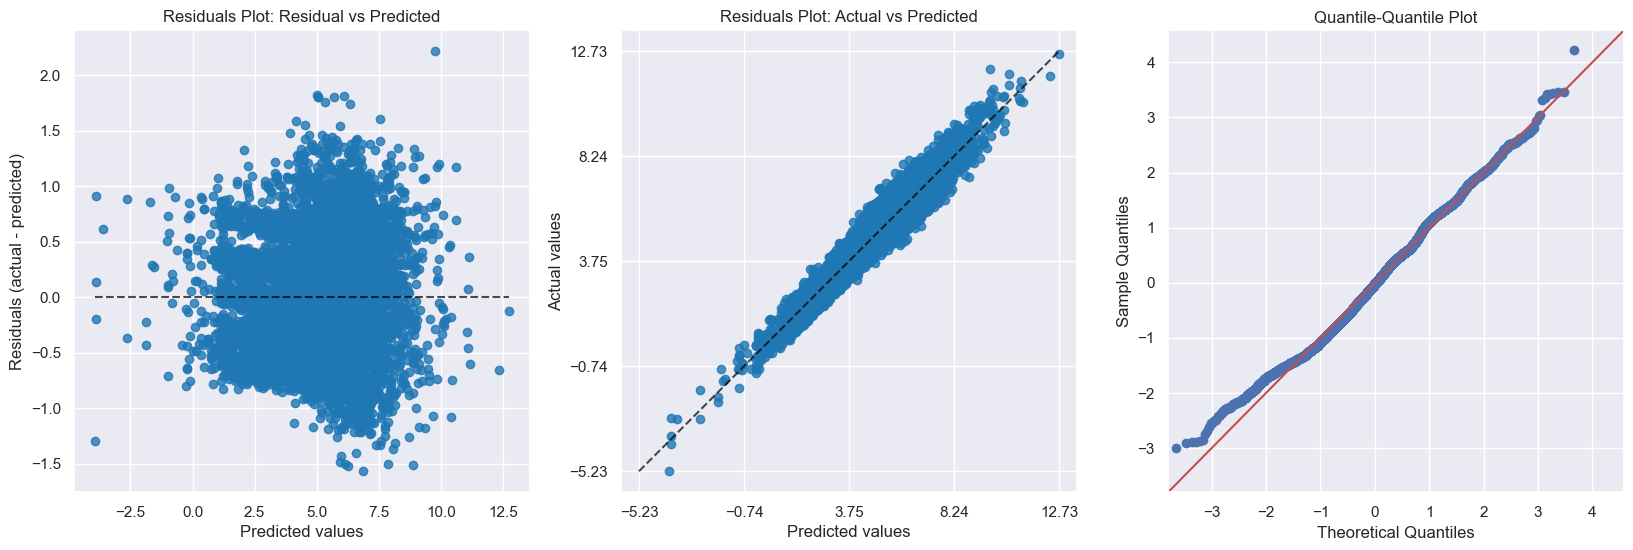

In [227]:
visualize_results(transformed_ytest, def_trans_gbr_y_pred, def_trans_gbr_residuals)

In [228]:
#Kolmogorov–Smirnov test on residuals
kstest(def_trans_gbr_residuals, "norm")

KstestResult(statistic=0.16698639757750575, pvalue=5.469875643039708e-191, statistic_location=-0.8221624680190498, statistic_sign=-1)

### Default Gradient Boosting Regression Model: Naive Retransformation of Predictions

In [229]:
# Naive retransformation
def_trans_gbr_naive_back_transform_ypred = np.exp(def_trans_gbr_y_pred) 

In [230]:
def_trans_gbr_scores_naivere = model_score(def_trans_gbr_reg, transformed_Xtrain, 
                                           transformed_ytrain, naive_retrans_ytest, 
                                           def_trans_gbr_naive_back_transform_ypred, round_int=2)
def_trans_gbr_scores_naivere.rename({"Score Values": "Transformed Default GBR Model Scores \
(Naive Back-Transformation of Variables)"}, axis=1, inplace=True)
def_trans_gbr_scores_naivere

Transformed Default GBR Model Scores (Naive Back-Transformation of Variables)
Mean Absolute Error                                                     394.63                            
Max Error                                                            142895.02                            
MAPE                                                                     45.68                            
Mean R2 Score after 5 CV                                                  0.92                            
R2 Score Standard Deviation                                               0.00                            
Root Mean Squared Error                                                2813.77                            
Mean Squared Error                                                  7917327.92

### Default Gradient Boosting Regression Model: Retransformation of Predictions with Duan's Smearing Estimator

In [231]:
# Calculate variance of residuals
def_trans_gradient_res_var = def_trans_gbr_residuals.var()

In [232]:
# Define Duan's Smearing Estimator
def_gbr_trans_duan = duans_smearing_bias_correction(def_trans_gradient_res_var)

In [233]:
# Multiply predictions and test with Duan's Smearing Estimator
def_gbr_duans_back_transform_ypred = def_trans_gbr_naive_back_transform_ypred*def_gbr_trans_duan 
def_gbr_duans_back_transform_ytest = naive_retrans_ytest*def_gbr_trans_duan

In [234]:
def_gbr_model_scores_duansre = model_score(def_trans_gbr_reg, transformed_Xtrain, transformed_ytrain,
                                           def_gbr_duans_back_transform_ytest, def_gbr_duans_back_transform_ypred, 
                                           round_int=2)
def_gbr_model_scores_duansre.rename({"Score Values": "Transformed Default GBR Model Scores\
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
def_gbr_model_scores_duansre

Transformed Default GBR Model Scores(Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     144.43                                     
Max Error                                                             52295.76                                     
MAPE                                                                     45.68                                     
Mean R2 Score after 5 CV                                                  0.92                                     
R2 Score Standard Deviation                                               0.00                                     
Root Mean Squared Error                                                1029.77                                     
Mean Squared Error                                                  1060418.74

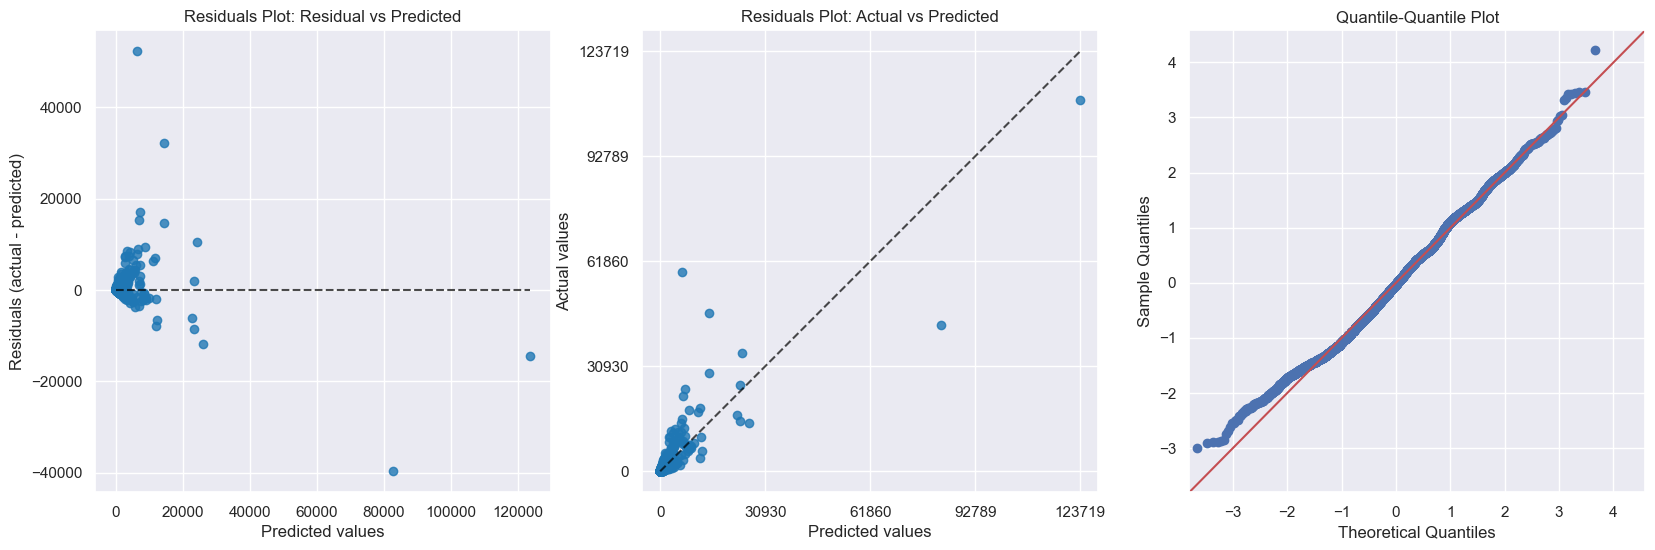

In [235]:
visualize_results(def_gbr_duans_back_transform_ytest, 
                  def_gbr_duans_back_transform_ypred, 
                  def_trans_gbr_residuals)

### Gradient Boosting Regression Hyperparameter Tuning with Transformed Variables

In [236]:
# Use random search to find the best hyperparameters
# Hyperparameter distributions dict was defined in chapter 4
# We use the original gbr model from chapter 4
trans_gradient_random_search =  RandomizedSearchCV(gbr_reg, 
                                                   param_distributions=gbr_param_distributions, 
                                                   n_jobs=-1, random_state=42, scoring=["neg_mean_absolute_error", "r2"], 
                                                   refit="neg_mean_absolute_error", n_iter=15)

# Fit the random search object to the data
trans_gradient_random_search.fit(transformed_Xtrain, transformed_ytrain)

RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_leaf_nodes': [10, 100, 1000, None],
                                        'min_samples_leaf': [1, 10, 20, 50],
                                        'n_estimators': [50, 100, 150, 200],
                                        'n_iter_no_change': [10], 'tol': [0.02],
                                        'validation_fraction': [0.2]},
                   random_state=42, refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'])

In [237]:
show_param_cv_results(gbr_param_distributions, trans_gradient_random_search)

param_learning_rate param_max_depth param_n_estimators  \
11                 0.3               4                150   
7                  0.2               7                 50   
6                  0.5               5                 50   
1                  0.3               7                200   
13                 0.3               8                150   
5                  0.2               8                200   
8                  0.5               4                150   
4                  0.2               8                150   
2                  0.2               4                 50   
0                  0.2               8                150   
3                  0.3               5                150   
10                 0.1               4                150   
14                0.05               4                200   
9                 0.05               4                100   
12                0.05               8                150   

   param_max_leaf_nodes param_min_samples_leaf param_n_iter_no_change  \
11                  100                     10                     10   
7                   100                     10                     10   
6                  None                     50                     10   
1                  None                      1                     10   
13                   10                     20                     10   
5                    10                     10                     10   
8                  1000                     10                     10   
4                  1000                     20                     10   
2                   100                     50                     10   
0                  1000                     10                     10   
3                    10                     50                     10   
10                  100                      1                     10   
14                  100                     10                     10   
9                  None                     20                     10   
12                   10                     20                     10   

   param_tol param_validation_fraction  R2 Score  R2 Standard Deviation  \
11      0.02                       0.2  0.922854               0.002506   
7       0.02                       0.2  0.922556               0.002408   
6       0.02                       0.2  0.921687               0.002689   
1       0.02                       0.2  0.921812               0.002566   
13      0.02                       0.2  0.922212               0.002629   
5       0.02                       0.2  0.922561               0.002742   
8       0.02                       0.2  0.921899               0.002650   
4       0.02                       0.2  0.921640               0.002337   
2       0.02                       0.2  0.921901               0.002502   
0       0.02                       0.2  0.921567               0.002533   
3       0.02                       0.2  0.921431               0.002715   
10      0.02                       0.2  0.921544               0.002588   
14      0.02                       0.2  0.918408               0.002408   
9       0.02                       0.2  0.918264               0.002330   
12      0.02                       0.2  0.917334               0.002374   

    Mean Absolute Error  Absolute Error Standard Deviation  
11             0.433062                           0.003350  
7              0.433369                           0.003198  
6              0.433757                           0.004065  
1              0.434160                           0.003612  
13             0.434512                           0.003397  
5              0.434793                           0.003975  
8              0.434830                           0.003638  
4              0.434994                           0.002879  
2              0.435258                           0.003206  
0              0.435290                       

We will not be using early stopping in this final result to obtain the best outcome:

In [238]:
# Exhaustive search for best hyperparameters
trans_gbr_grid_params = {"learning_rate": [0.2, 0.3],
                         "max_depth": [4, 7, 8],
                         "n_estimators": [50, 150],
                         "max_leaf_nodes": [100],
                         "min_samples_leaf": [10]}

In [239]:
trans_grid_gbr_search = GridSearchCV(gbr_reg, param_grid=trans_gbr_grid_params, 
                                     n_jobs=-1, scoring=["neg_mean_absolute_error", "r2"], 
                                     refit="neg_mean_absolute_error")

trans_grid_gbr_search.fit(transformed_Xtrain, transformed_ytrain)

GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3], 'max_depth': [4, 7, 8],
                         'max_leaf_nodes': [100], 'min_samples_leaf': [10],
                         'n_estimators': [50, 150]},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'])

In [240]:
show_param_cv_results(trans_gbr_grid_params, trans_grid_gbr_search)

param_learning_rate param_max_depth param_n_estimators  \
1                  0.2               4                150   
0                  0.2               4                 50   
6                  0.3               4                 50   
7                  0.3               4                150   
2                  0.2               7                 50   
4                  0.2               8                 50   
8                  0.3               7                 50   
3                  0.2               7                150   
10                 0.3               8                 50   
5                  0.2               8                150   
9                  0.3               7                150   
11                 0.3               8                150   

   param_max_leaf_nodes param_min_samples_leaf  R2 Score  \
1                   100                     10  0.923326   
0                   100                     10  0.923510   
6                   100                     10  0.923245   
7                   100                     10  0.922724   
2                   100                     10  0.922619   
4                   100                     10  0.922375   
8                   100                     10  0.922118   
3                   100                     10  0.922024   
10                  100                     10  0.921614   
5                   100                     10  0.921462   
9                   100                     10  0.920796   
11                  100                     10  0.920040   

    R2 Standard Deviation  Mean Absolute Error  \
1                0.002648             0.430158   
0                0.002581             0.430533   
6                0.002524             0.430688   
7                0.002551             0.431415   
2                0.002511             0.431536   
4                0.002514             0.431761   
8                0.002578             0.432225   
3                0.002506             0.432551   
10               0.002492             0.433560   
5                0.002545             0.433582   
9                0.002634             0.434890   
11               0.002431             0.436986   

    Absolute Error Standard Deviation  
1                            0.003805  
0                            0.003470  
6                            0.003372  
7                            0.003412  
2                            0.003254  
4                            0.003309  
8                            0.003523  
3                            0.003103  
10                           0.003516  
5                            0.003479  
9                            0.003294  
11                           0.002908

### Tuned Gradient Boosting Regression Model: Naive Retransformation of Predictions

In [241]:
# Naive retransformation
trans_tuned_gbr_best_params = trans_grid_gbr_search.best_params_ 

In [242]:
# Fit gbr model with the best hyperparameters, calculate predictions and residuals 
tuned_trans_gbr_reg = GradientBoostingRegressor(**trans_tuned_gbr_best_params, random_state=42)
tuned_trans_gradient = tuned_trans_gbr_reg.fit(transformed_Xtrain, transformed_ytrain)
tuned_trans_gbr_y_pred = tuned_trans_gbr_reg.predict(transformed_Xtest)
tuned_trans_gbr_residuals = (transformed_ytest - tuned_trans_gbr_y_pred)

In [243]:
cross_validate(tuned_trans_gbr_reg, transformed_Xtrain, transformed_ytrain, cv=5)

{'fit_time': array([10.4692142 , 11.14424729, 11.09193468, 10.48903131, 10.85968351]),
 'score_time': array([0.03299952, 0.03000045, 0.03199744, 0.03098822, 0.02901435]),
 'test_score': array([0.92349796, 0.92290192, 0.92208628, 0.92005958, 0.92808503])}

In [244]:
tuned_trans_gbr_naive_back_transform_ypred = np.exp(tuned_trans_gbr_y_pred) 

In [245]:
tuned_trans_gbr_scores_naivere = model_score(tuned_trans_gradient, transformed_Xtrain, transformed_ytrain, 
                                             naive_retrans_ytest, tuned_trans_gbr_naive_back_transform_ypred, 
                                             round_int=2)

tuned_trans_gbr_scores_naivere.rename({"Score Values": "Transformed Tuned GBR Model Scores \
(Naive Back-Transformation of Variables)"}, axis=1, inplace=True)
tuned_trans_gbr_scores_naivere #412.72

Transformed Tuned GBR Model Scores (Naive Back-Transformation of Variables)
Mean Absolute Error                                                     387.82                          
Max Error                                                            127708.39                          
MAPE                                                                     45.71                          
Mean R2 Score after 5 CV                                                  0.92                          
R2 Score Standard Deviation                                               0.00                          
Root Mean Squared Error                                                2598.87                          
Mean Squared Error                                                  6754105.75

### Tuned Gradient Boosting Regression Model: Retransformation of Predictions with Duan's Smearing Estimator 

In [246]:
# Calculate variance of residuals
tuned_trans_gbr_res_var = tuned_trans_gbr_residuals.var()

In [247]:
# Define Duan's Smearing Estimator
tuned_gbr_trans_duan = duans_smearing_bias_correction(tuned_trans_gbr_res_var)

In [248]:
# Multiply predictions and test with Duan's Smearing Estimator
tuned_gbr_duans_back_transform_ypred = tuned_trans_gbr_naive_back_transform_ypred*tuned_gbr_trans_duan  
tuned_gbr_duans_back_transform_ytest = naive_retrans_ytest*tuned_gbr_trans_duan 

In [249]:
tuned_gbr_model_scores_duansre = model_score(tuned_trans_gradient, transformed_Xtrain, transformed_ytrain,
                                             tuned_gbr_duans_back_transform_ytest, 
                                             tuned_gbr_duans_back_transform_ypred, round_int=2)
tuned_gbr_model_scores_duansre.rename({"Score Values": "Transformed Tuned GBR Model Scores \
(Variables Back-Transformed with Duan's Estimator)"}, axis=1, inplace=True)
tuned_gbr_model_scores_duansre

Transformed Tuned GBR Model Scores (Variables Back-Transformed with Duan's Estimator)
Mean Absolute Error                                                     142.41                                    
Max Error                                                             46896.88                                    
MAPE                                                                     45.71                                    
Mean R2 Score after 5 CV                                                  0.92                                    
R2 Score Standard Deviation                                               0.00                                    
Root Mean Squared Error                                                 954.35                                    
Mean Squared Error                                                   910787.00

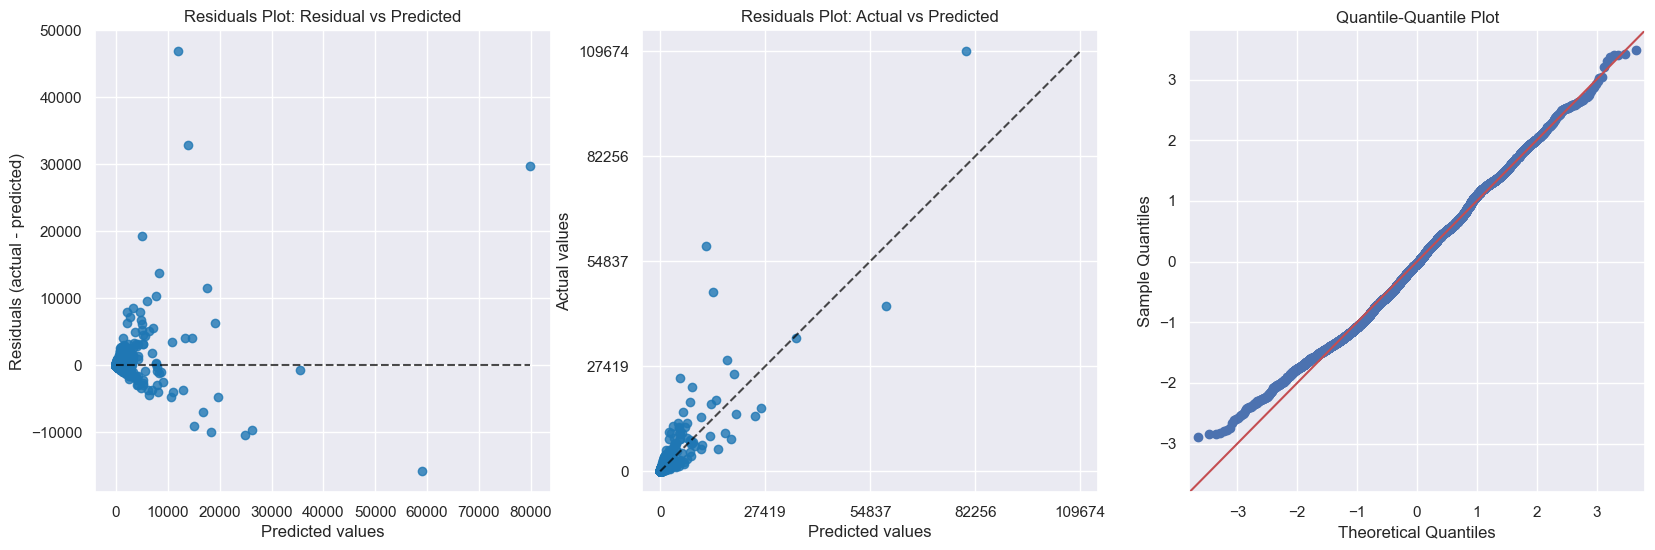

In [250]:
visualize_results(tuned_gbr_duans_back_transform_ytest, 
                  tuned_gbr_duans_back_transform_ypred, 
                  tuned_trans_gbr_residuals)

Similar to the Random Forests algorithm but even better, it would seem that the GBR model outperforms all others. In the next and final chapter, we will compare the results of all the models in one table.

# 6. Final Evaluation of All Models,  Prediction Intervals and Cake Maybe
<a id="chapter_6"></a>

In [251]:
# Create final dataframe will best model scores
all_scores = pd.concat([dummy_median_model_scores, unscaled_model_scores, 
                        weighted_unscaled_model_scores, unscaled_elastic_model_scores,
                        gbr_model_scores, forest_model_scores, transformed_linreg_model_scores_duansre, 
                        trans_elastic_model_scores_duansre, tuned_forest_model_scores_duansre,
                        tuned_gbr_model_scores_duansre], axis=1)

# Transpose
final_scores = all_scores.T
# Sort by MAE
final_scores.sort_values(by="Mean Absolute Error")

Mean Absolute Error  \
Transformed Tuned GBR Model Scores (Variables B...              142.410   
Transformed Tuned Forest Model Scores (Variable...              163.550   
Transformed Elastic Model Scores (Variables Bac...              206.670   
Linear Regression Model Scores (Variables Back-...              212.860   
GBR Model Scores                                                421.840   
Forest Model Scores                                             426.040   
Weighted Unscaled Model Scores                                  518.340   
Unscaled Model Scores                                           539.830   
Unscaled Elastic Model Scores                                   556.186   
Dummy Median Model Scores                                       811.900   

                                                     Max Error      MAPE  \
Transformed Tuned GBR Model Scores (Variables B...   46896.880    45.710   
Transformed Tuned Forest Model Scores (Variable...   87069.230    47.040   
Transformed Elastic Model Scores (Variables Bac...  124136.060    46.680   
Linear Regression Model Scores (Variables Back-...  130809.380    47.170   
GBR Model Scores                                    146976.210   217.170   
Forest Model Scores                                 157525.861   124.719   
Weighted Unscaled Model Scores                      153467.560   282.440   
Unscaled Model Scores                                85585.640  1244.770   
Unscaled Elastic Model Scores                        86009.201  1835.619   
Dummy Median Model Scores                           298537.700  1073.200   

                                                    Mean R2 Score after 5 CV  \
Transformed Tuned GBR Model Scores (Variables B...                     0.920   
Transformed Tuned Forest Model Scores (Variable...                     0.920   
Transformed Elastic Model Scores (Variables Bac...                     0.920   
Linear Regression Model Scores (Variables Back-...                     0.920   
GBR Model Scores                                                       0.550   
Forest Model Scores                                                    0.596   
Weighted Unscaled Model Scores                                         0.620   
Unscaled Model Scores                                                  0.620   
Unscaled Elastic Model Scores                                          0.620   
Dummy Median Model Scores                                             -0.000   

                                                    R2 Score Standard Deviation  \
Transformed Tuned GBR Model Scores (Variables B...                        0.000   
Transformed Tuned Forest Model Scores (Variable...                        0.000   
Transformed Elastic Model Scores (Variables Bac...                        0.000   
Linear Regression Model Scores (Variables Back-...                        0.000   
GBR Model Scores                                                          0.150   
Forest Model Scores                                                       0.162   
Weighted Unscaled Model Scores                                            0.140   
Unscaled Model Scores                                                     0.140   
Unscaled Elastic Model Scores                                             0.126   
Dummy Median Model Scores                                                 0.000   

                                                    Root Mean Squared Error  \
Transformed Tuned GBR Model Scores (Variables B...                  954.350   
Transformed Tuned Forest Model Scores (Variable...                 1350.220   
Transformed Elastic Model Scores (Variables Bac...                 2392.620   
Linear Regression Model Scores (Variables Back-...                 2484.350   
GBR Model Scores                                                   3052.790   
Forest Model Scores                                                3076.956   
Weighted Unscaled Model Scores           

We can very clearly see that the Tuned GBR model fit on log-transformed variables would be the best model for prediction. Of course, the errors are way too high for the model to be useful (unless you consider a 142 euros deviation to be negligible).

Still, when compared to the original Dummy model we created as a baseline, the results are not at all disappointing. Had I wanted to keep any of these models, the next issue would be to account for uncertainty. That would lead me to try and calculate prediction intervals.

The issue with calculating PIs is that classic statistics make it very clear that [we cannot draw reliable prediction intervals or even confidence intervals](https://timeseriesreasoning.com/contents/assumptions-of-linear-regression/) when our error term is not normally distributed, a fact which seems to cripple our capacity for predictions or inference.

Enter [MAPIE](https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor) to the rescue! The Model Agnostic Prediction Intervals Estimator is a library that allows for the creation of prediction intervals regardless of the model used and with strong theoretical guarantees, even when the model produces [heteroscedastic errors](https://towardsdatascience.com/with-mapie-uncertainties-are-back-in-machine-learning-882d5c17fdc3)!

MAPIE offers a variety of methods to produce reliable PIs, with the catch being that these methods are ***HEAVY*** computationally, to the point where my current operating system does not have the necessary memory to perform a normal CV+ calculation for the entire dataset.  

Normally, we would have to separate our training dataset a second time, train the model on one part and train the MAPIE regressor on the other, to avoid information leaking into MAPIE ([as described here](https://towardsdatascience.com/with-mapie-uncertainties-are-back-in-machine-learning-882d5c17fdc3)). But since none of the models of this project are usable in reality, I'll settle for creating the prediction intervals out of a smaller sample of the original dataset:

In [252]:
# Variables for MAPIE
train_y_sample = transformed_ytrain.sample(n=5000, replace=False, random_state=42).to_numpy()

train_X_var = transformed_Xtrain[["Total_Assets"]]
train_X_sample = train_X_var.sample(n=5000, replace=False, random_state=42).to_numpy()

In [253]:
# 95% and 68% Prediction Intervals
alpha = [0.05, 0.32]

# Mapie fit and prediction
mapie = MapieRegressor(estimator=GradientBoostingRegressor(**trans_tuned_gbr_best_params, random_state=42))
mapie_reg = mapie.fit(train_X_sample, train_y_sample)
y_pred, y_pis = mapie_reg.predict(train_X_sample, alpha=alpha)

In [254]:
# Back transformation using Duan's Estimator
train_X_sample = np.exp(train_X_sample)*tuned_gbr_trans_duan 
train_y_sample = np.exp(train_y_sample)*tuned_gbr_trans_duan 
y_pis_back = np.exp(y_pis)*tuned_gbr_trans_duan 
y_pred_back = np.exp(y_pred)*tuned_gbr_trans_duan 

In [255]:
# Dataframe to use with Seaborn Lineplot
train_X_df = pd.DataFrame(train_X_sample, columns=["train_X"])
train_y_df = pd.DataFrame(train_y_sample, columns=["train_y"])
y_pred_df = pd.DataFrame(y_pred_back, columns=["Ypred"])
overall_dataframe = pd.concat([train_X_df, train_y_df, y_pred_df], axis=1)

In [256]:
coverage_scores = [
    regression_coverage_score(train_y_sample, y_pis_back[:, 0, i], y_pis_back[:, 1, i])
    for i, _ in enumerate(alpha)
]

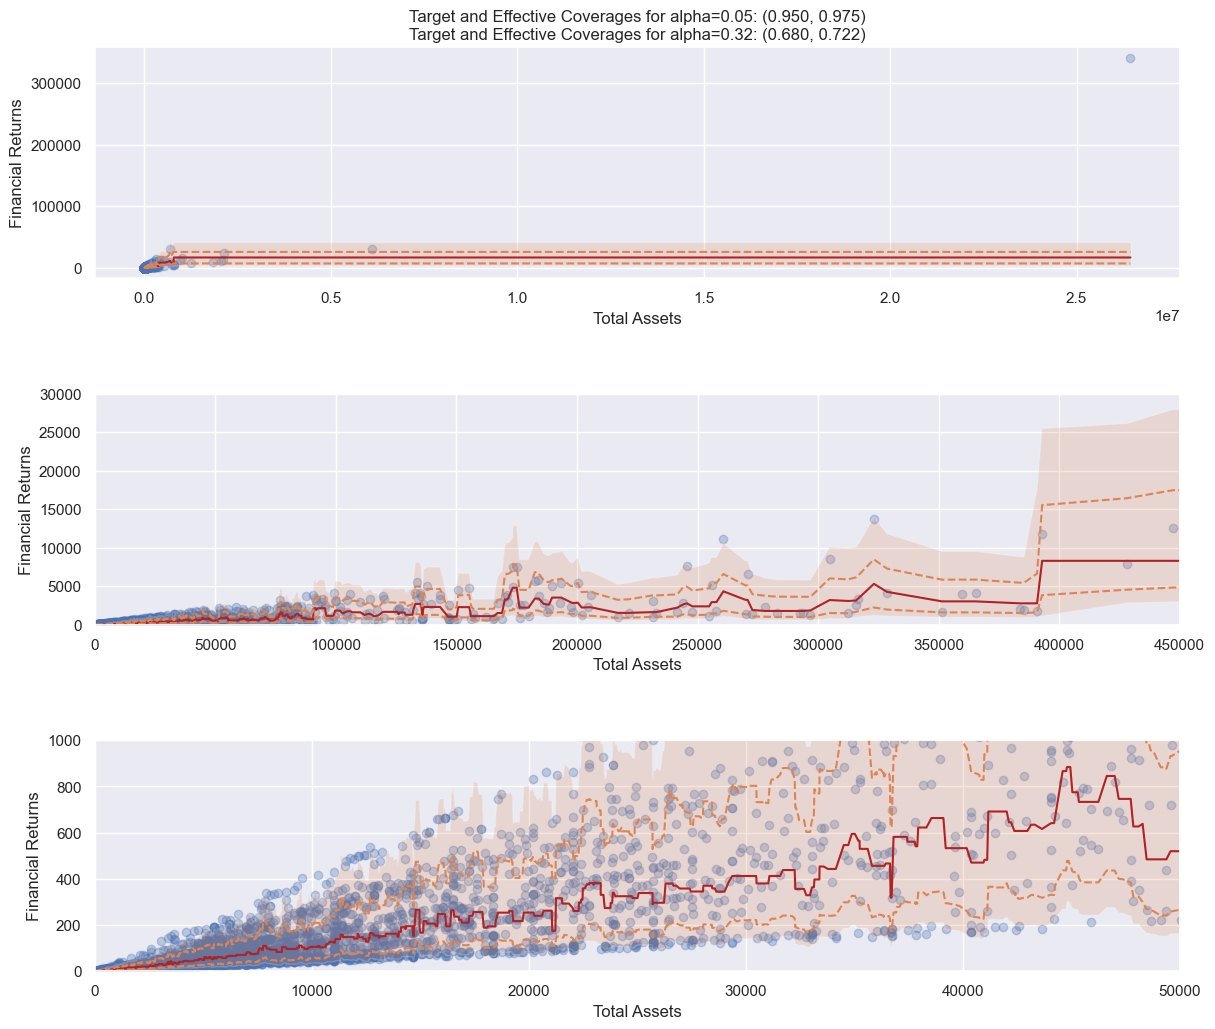

In [257]:
# Taken from MAPIE documentation
fig = plt.figure(figsize=(14, 12))

ax1 = plt.subplot(311)

plt.scatter(train_X_sample, train_y_sample, alpha=0.3)
sns.lineplot(data=overall_dataframe, x = "train_X", y="Ypred", color="firebrick")
order = np.argsort(train_X_sample[:, 0])
plt.plot(train_X_sample[order], y_pis_back[order][:, 0, 1], color="C1", ls="--")
plt.plot(train_X_sample[order], y_pis_back[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    train_X_sample[order].ravel(),
    y_pis_back[order][:, 0, 0].ravel(),
    y_pis_back[order][:, 1, 0].ravel(),
    alpha=0.2
)
plt.xlabel("Total Assets")
plt.ylabel("Financial Returns")
plt.title(
    f"Target and Effective Coverages for "
    f"alpha={alpha[0]:.2f}: ({1-alpha[0]:.3f}, {coverage_scores[0]:.3f})\n"
    f"Target and Effective Coverages for "
    f"alpha={alpha[1]:.2f}: ({1-alpha[1]:.3f}, {coverage_scores[1]:.3f})"
)

ax2 = plt.subplot(312)

plt.scatter(train_X_sample, train_y_sample, alpha=0.3)
sns.lineplot(data=overall_dataframe, x = "train_X", y="Ypred", color="firebrick")
order = np.argsort(train_X_sample[:, 0])
plt.plot(train_X_sample[order], y_pis_back[order][:, 0, 1], color="C1", ls="--")
plt.plot(train_X_sample[order], y_pis_back[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    train_X_sample[order].ravel(),
    y_pis_back[order][:, 0, 0].ravel(),
    y_pis_back[order][:, 1, 0].ravel(),
    alpha=0.2
)
plt.xlabel("Total Assets")
plt.ylabel("Financial Returns")

# Zoom 
plt.xlim((0, 450000))
plt.ylim((0, 30000))

ax2 = plt.subplot(313)

plt.scatter(train_X_sample, train_y_sample, alpha=0.3)
sns.lineplot(data=overall_dataframe, x = "train_X", y="Ypred", color="firebrick")
order = np.argsort(train_X_sample[:, 0])
plt.plot(train_X_sample[order], y_pis_back[order][:, 0, 1], color="C1", ls="--")
plt.plot(train_X_sample[order], y_pis_back[order][:, 1, 1], color="C1", ls="--")
plt.fill_between(
    train_X_sample[order].ravel(),
    y_pis_back[order][:, 0, 0].ravel(),
    y_pis_back[order][:, 1, 0].ravel(),
    alpha=0.2
)
plt.xlabel("Total Assets")
plt.ylabel("Financial Returns")

# Zoom further
plt.xlim((0, 50000))
plt.ylim((0, 1000))

plt.subplots_adjust(hspace=0.5);

This is probably the best I can do with this dataset. Any further improvement would possibly require numerous omitted variables that affect financial returns to be included in the original dataset. But that is a story for another time.  

I'm sure you came all this way expecting the cake to be a lie.

Turns out, the cake was inside us all along.

I should've been a comedian.